# Import Libraries

In [1]:
from __future__ import print_function

# to get function name
import inspect

# io capture & redirection
import io
import itertools
import logging
import sys
import time
from datetime import timedelta
from typing import List, Tuple

import keras
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics_sk
import tensorflow as tf
from IPython.display import Image, Markdown, display
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model
from keras.utils import plot_model
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from ydata_profiling import ProfileReport


def dispd(obj: object):
    if logging.getLogger().isEnabledFor(logging.DEBUG):
        display(obj)


def dispi(obj: object):
    if logging.getLogger().isEnabledFor(logging.INFO):
        display(obj)


def printi(obj: object):
    if logging.getLogger().isEnabledFor(logging.INFO):
        print(obj)


def printd(obj: object):
    if logging.getLogger().isEnabledFor(logging.DEBUG):
        print(obj)


def dispd_df(df: pd.DataFrame):
    frame = inspect.currentframe().f_back
    df_var_name = [name for name, value in frame.f_locals.items() if value is df]
    dispd(df_var_name)
    dispd(df)


def dispi_df(df: pd.DataFrame):
    frame = inspect.currentframe().f_back
    df_var_name = [name for name, value in frame.f_locals.items() if value is df]
    dispi(df_var_name)
    dispi(df)


logging.getLogger().setLevel(logging.DEBUG)

%precision 2
pd.options.display.precision = 2
pd.options.display.float_format = (
    '{:.2f}'.format
)  # don't use scientific notation 4.95e-01 ==> 0.49
# Magic keyword also sets numpy printoption, let's set it explicitly as well
np.set_printoptions(precision=2)
# display(np.get_printoptions())

pd.set_option('display.max_columns', 504)


# Easy to grasp
def print(*args):
    __builtins__.print(*('%.2f' % a if isinstance(a, float) else a for a in args))


# Apply the default theme
sns.set_theme()

img_format = 'png'


def save_fig(file_name: str):
    plt.savefig(f'plots/{file_name}.{img_format}', format=img_format)


def new_df(num_rows: int, cols: List[str]):
    return pd.DataFrame(np.zeros((num_rows, len(cols))), columns=cols)

2024-11-14 17:36:43.270658: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 17:36:43.291503: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Log level

In [2]:
logging.getLogger().setLevel(logging.INFO)
logging.getLogger().setLevel(logging.DEBUG)

# Common variables

In [3]:
# Reference for columns
(
    col_index,
    col_season,
    col_day_num,
    col_wteam,
    col_WScore,
    col_lteam,
    col_LScore,
    col_wloc,
    col_num_ot,
    col_wfgm,
    col_wfga,
    col_wfgm3,
    col_wfga3,
    col_wftm,
    col_wfta,
    col_wor,
    col_wdr,
    col_wast,
    col_wto,
    col_wstl,
    col_wblk,
    col_wpf,
    col_lfgm,
    col_lfga,
    col_lfgm3,
    col_lfga3,
    col_lftm,
    col_lfta,
    col_lor,
    col_ldr,
    col_last,
    col_lto,
    col_lstl,
    col_lblk,
    col_lpf,
) = (
    'index',
    'Season',
    'DayNum',
    'WTeamID',
    'WScore',
    'LTeamID',
    'LScore',
    'WLoc',
    'NumOT',
    'WFGM',
    'WFGA',
    'WFGM3',
    'WFGA3',
    'WFTM',
    'WFTA',
    'WOR',
    'WDR',
    'WAst',
    'WTO',
    'WStl',
    'WBlk',
    'WPF',
    'LFGM',
    'LFGA',
    'LFGM3',
    'LFGA3',
    'LFTM',
    'LFTA',
    'LOR',
    'LDR',
    'LAst',
    'LTO',
    'LStl',
    'LBlk',
    'LPF',
)
cols_w = [
    col_wteam,
    col_WScore,
    col_wfgm,
    col_wfga,
    col_wfgm3,
    col_wfga3,
    col_wftm,
    col_wfta,
    col_wor,
    col_wdr,
    col_wast,
    col_wto,
    col_wstl,
    col_wblk,
    col_wpf,
]
cols_l = [
    col_lteam,
    col_LScore,
    col_lfgm,
    col_lfga,
    col_lfgm3,
    col_lfga3,
    col_lftm,
    col_lfta,
    col_lor,
    col_ldr,
    col_last,
    col_lto,
    col_lstl,
    col_lblk,
    col_lpf,
]

# Some strings
str_mncaa = 'MNCAA'
str_wncaa = 'WNCAA'
str_mreg = 'M Reg'
str_wreg = 'W Reg'
col_outcome = 'Outcome'
col_tru_outcome = 'True_Outcome'
col_score = 'Score'
col_percent_ul = 'percent_ul'
col_metric_ul = 'metric_ul'
col_prob_ul = 'prob_ul'
col_percent_ll = 'percent_ll'
col_metric_ll = 'metric_ll'
col_prob_ll = 'prob_ll'
# col_tru_stnt = "True_Strength(W|W,L)"  # Special chars might affect the SQL query in data frame
col_tru_stnt = 'True_Strength'
col_tru_prob = 'True_Prob'
col_id = 'ID'
col_pred = 'Pred'
col_pred_st = 'Pred_Strength'
col_pred_prb = 'Pred_Prob'
cols_teams = [col_wteam, col_lteam]
path_data_23 = './data23/'
path_data_24 = './data24/'

day_ncaa_start = 134  # 132 is last day for regular season

str_aprch_next = """___
##### **Approach next** | Some questions?
 | using other functions than relu?  
 | Training & predicting men & women seperately?  
 | How does unscaled data looks?  
 | Not supposed to use 2024 data.  
 | Using softmax & cross entropy as its more meaningfull  
"""
str_aprch_18 = """___
##### **Approach 18** | **increase memory further** of model  
'Training for year: 2022 | epochs: 200 | years_cap: None | aprch: 18 ...'  
'0.58858 Loss (binary_crossentropy) 0.65344 val_loss | 0.20607 mse (Brier score) 0.22818 val_mse | Epoch 10 / 200'  
'0.55379 Loss (binary_crossentropy) 0.96637 val_loss | 0.19416 mse (Brier score) 0.27326 val_mse | Epoch 20 / 200'  
'0.53477 Loss (binary_crossentropy) 1.83196 val_loss | 0.18755 mse (Brier score) 0.30468 val_mse | Epoch 30 / 200'  
'0.48131 Loss (binary_crossentropy) 18.48592 val_loss | 0.16889 mse (Brier score) 0.28990 val_mse | Epoch 180 / 200  
'0.48008 Loss (binary_crossentropy) 17.63218 val_loss | 0.16898 mse (Brier score) 0.29508 val_mse | Epoch 190 / 200  
'0.48789 Loss (binary_crossentropy) 23.29853 val_loss | 0.16906 mse (Brier score) 0.34621 val_mse | Epoch 200 / 200  
'Time taken to fit the model: 6:34:22'  
Model: "sequential_21"  
| Layer (type)  | Output Shape   |Param # |
|------|------|------|
|dense_71 (Dense) | (None, 760) | 571,520 |
|dense_72 (Dense) | (None, 760) | 578,360 |
|dense_73 (Dense) | (None, 760) | 578,360 |
|dense_74 (Dense) | (None, 1) | 101 |

 Total params: 5,187,005 (19.79 MB)  
 Trainable params: 1,729,001 (6.60 MB)  
 Non-trainable params: 0 (0.00 B)  
 Optimizer params: 3,458,004 (13.19 MB)
 
why its printing in **scientific notation?**

'0.293086 brier_score for year 2022'
||Pred_Prob| 	True_Outcome|
|-|-|-|
|0 	4.95e-01| 	1|
|1| 	2.46e-12| 	0|
|2 	|4.95e-01 	|1|
|3 	|4.95e-01 	|0|
|4 	|4.95e-01 	|1|

'0.394866 brier_score for year 2023'
||	Pred_Prob| 	True_Outcome|
|-|-|-|
|0| 	6.41e-01 	|0|
|1| 	1.00e+00 	|0|
|2| 	1.56e-06 	|1|
|3| 	1.18e-16 	|1|
|4| 	1.00e+00| 	1|
"""
str_aprch_17 = """___
##### **Approach 17** | **increase memory of model**  
 >| **model should have memory**: for prediction it need to remember the teams & their weights  
 | 364 men + 361 woment ==> total = 725 teams  
 | Say 3 hidden layers with 100 nodes each ==> (100*100)+(100*100) = 20,000 weigths
 
'Training for year: 2022 | epochs: 200 | years_cap: None | aprch: 16  ...'  
'0.60741 Loss (binary_crossentropy) 0.70025 val_loss | 0.21298 mse (Brier score) 0.23602 val_mse | Epoch 10 / 200'  
'0.51047 Loss (binary_crossentropy) 2.77062 val_loss | 0.17848 mse (Brier score) 0.35104 val_mse | Epoch 200 / 200   
Model: "sequential_14"
| Layer (type)  | Output Shape   |Param # |
|------|------|------|
|dense_43 (Dense) | (None, 100) | 75,200 |
|dense_44 (Dense) | (None, 100) | 10,100 |
|dense_45 (Dense) | (None, 100) | 10,100 |
|dense_46 (Dense) | (None, 1) | 101 |

Total params: 286,505 (1.09 MB)  
 Trainable params: 95,501 (373.05 KB)  
 Non-trainable params: 0 (0.00 B)  
 Optimizer params: 191,004 (746.11 KB)  

'0.360923 brier_score for year 2022'
||Pred_Prob| 	True_Outcome|
|-|-|-|
|3| 	0.06| 	0|
|4 	|0.90| 	1|

'0.400066 brier_score for year 2023'
||Pred_Prob| 	True_Outcome|
|-|-|-|
|0| 	7.53e-01| 	0|
|1| 	9.69e-01 |	0|
|2 |	5.44e-01 	|1|
|3 	|2.87e-02| 	1|
|4 	|1.63e-01 |	1|
"""
str_aprch_16 = """___
##### **Approach 16** | train full data  
 'Training for year: 2022 | epochs: 200 | years_cap: None | nodes_hidn_lyr: 50 | aprch: 16 ...'  
 Model: "sequential_12"  
| Layer (type)  | Output Shape   |Param # |
|------|------|------|
|dense_36 (Dense) | (None, 50) | 37,600 |
|dense_37 (Dense) | (None, 50) | 2,550 |
|dense_38 (Dense) | (None, 1) | 51 |

 Total params: 120,605 (471.12 KB)  
 Trainable params: 40,201 (157.04 KB)  
 Non-trainable params: 0 (0.00 B)  
 Optimizer params: 80,404 (314.08 KB)  

'0.61877 Loss (binary_crossentropy) 0.64040 val_loss | 0.21722 mse (Brier score) 0.21811 val_mse | Epoch 10 / 200'  
'0.60193 Loss (binary_crossentropy) 0.61871 val_loss | 0.21066 mse (Brier score) 0.20955 val_mse | Epoch 20 / 200'  
'0.55719 Loss (binary_crossentropy) 0.86180 val_loss | 0.19384 mse (Brier score) 0.25455 val_mse | Epoch 200 / 200'  
'0.254551 brier_score for year 2022'  
'0.343427 brier_score for year 2023'  
>optimizing cross entropy (this) vs mse  (aproch 14)  
training brier score is similar (0.1938 vs 0.1988) | val loss improved a bit (0.254 vs 0.275)  
**worse score** due to **capped training data**
"""
str_aprch_15 = """___
##### **Approach 15** | output node = Sigmoid, **cross entropy for loss function**  
| training data **restricted to 2 years**  
| 2 hidden layers with 100 nodes each ==> 50 x 50 = 2500 weigths  
'Training for year: 2022 | epochs: 200 | years_cap: 2 | nodes_hidn_lyr: 50 | aprch: 15 ...'  
 2022  
'0.43268 Loss (binary_crossentropy) 2.79712 val_loss | 0.15513 mse (Brier score) 0.42693 val_mse | Epoch 200 / 200'  
**worse score** than optimizing with mse (0.4269 vs 0.245)
"""
str_aprch_14 = """___
##### **Approach 14** | Correct **Briar score** (outcome than probability)  
| What metric compares with score? mse is far off!! **Briar score matches it**  
'Training for year 2022 ...'  
'0.198936 Loss | 0.267952 val_loss | Brier score with mse | Epoch 195 / 200'  
'0.198883 Loss | 0.291184 val_loss | Brier score with mse | Epoch 196 / 200'  
'0.198833 Loss | 0.279018 val_loss | Brier score with mse | Epoch 197 / 200'  
'0.198817 Loss | 0.282074 val_loss | Brier score with mse | Epoch 198 / 200'  
'0.198847 Loss | 0.280075 val_loss | Brier score with mse | Epoch 199 / 200'  
'0.198808 Loss | 0.275084 val_loss | Brier score with mse | Epoch 200 / 200'  
'0.198808 | Best loss '  
**training loss went down** (0.19) but not the **evaluation loss** (0.24)  
'0.245065 brier_score for year 2022'  
'0.267237 brier_score for year 2023'  
"""
str_aprch_13 = """**Approach 13** |  
 | Sample Submission (prediction=0.5) for all matches | Kaggle score: **0.2500**  
 | our prediction 0.24xx is better only **1  
 | mse on sample submission 0.5 is '**0.0048** | Metric mean_squared_error on Probability'  
 | Kaggle score is different than mse, though on its website is clamis to be mse  
 | or some calculation in this notebooks is wrong  
"""
str_aprch_12 = """**Approach 12** | check again kaggle score on unscaled | Kaggle score: **0.24811**  
'4m callback | best Loss: 0.025430 | corresponding miss_pred: 0.222222'  
"Evaluating best_loss model's predictions for year 2023 ..."  
'**0.0057** | Metric mean_squared_error on Probability' | **metric not matching with score**  
'0.0990 | Metric mean_squared_error on Strength'  
"0.4627 | 62/134 | Mis predicted Match's outcome | Probabilities"  

11 vs 12 | **NAN is present in 12 but not in 11 !!**  
**Why is tru prob is NAN as well?**  
Pred_Prob 	True_Prob 	Pred_Prob 	True_Prob  
 	1.17 	0.43 	NaN 	NaN  
 	1.15 	0.49 	NaN 	NaN  
 	1.16 	0.45 	NaN 	NaN  
 	1.17 	0.34 	NaN 	NaN  
 	1.15 	0.34 	NaN 	NaN  

**NaN is coming due to concat**  | **Not a prediction issue**
Final concat  
Pred_Prob  True_Prob  Pred_Prob  True_Prob  
0         0.51       0.50       0.57       0.50  
1         0.51       0.49       0.60       0.49  
**10**        0.51       0.41        NaN        NaN  

**index 10** is **present in only 1 mis pred**  
     Pred_Prob  True_Prob  
0         0.51       0.50  
1         0.51       0.49  
**10**        0.51       0.41  

 Pred_Prob  True_Prob  
0         0.57       0.50  
1         0.60       0.49  
8         0.39       0.50  
**11**        0.46       0.51  

**Intersting** thing is with **appr 11 | unscaled** most of the **predictions are same = 0.51 | 1.04 **  
**Scaling is the way to go**  
Looking in apr11 submition most of the predictions are **2023_1158_1396│0.5098786**
>**apr 11 | Scaled**  
'Predicted vs actual | Strength | Winning prob'  
     Pred_Strength  True_Strength  Pred_Prob  True_Prob  
0             1.04           0.98       **0.51**       0.50  
1             1.04           0.95       **0.51**       0.49  
2             1.04           1.34       **0.51**       0.57  
3             1.04           1.38       0.51       0.58  
4             1.04           1.28       **0.51**       0.56  
5             1.04           1.16       0.51       0.54  
6             1.04           1.11       **0.51**       0.53  
7             1.04           1.45       0.51       0.59  
8             1.04           1.01       **0.51**       0.50  
9             1.04           1.21       0.51       0.55  
10            1.04           0.71       0.51       0.41  

>**apr 12 | UnScaled**  
'Predicted vs actual | Strength | Winning prob'  
     Pred_Strength  True_Strength  Pred_Prob  True_Prob  
0             1.34           0.98       **0.57**       0.50  
1             1.48           0.95       **0.60**       0.49  
2             1.04           1.34       **0.51**       0.57  
3             1.05           1.38       0.51       0.58  
4             2.04           1.28       **0.67**       0.56  
5             1.30           1.16       0.57       0.54  
6             1.41           1.11       **0.59**       0.53  
7             2.10           1.45       0.68       0.59  
8             0.64           1.01       **0.39**       0.50  
9             1.55           1.21       0.61       0.55  
10            0.84           0.71       0.46       0.41  
"""
str_aprch_11 = """**Approach 11** | Unscaled | Kaggle score: **0.24988**  
'4m callback | best Loss: 0.072745 | corresponding miss_pred: 0.555556'  
"Evaluating best_loss model's predictions for year 2023 ..."  
'**0.2848** | Metric mean_squared_error on Probability' | **metric is close to kaggle score**  
'804.3482 | Metric mean_squared_error on Strength'  
"0.4851 | 65/134 | Mis predicted Match's outcome | Probabilities"  
"0.5373 | 72/134 | Mis predicted Match's outcome | Strength"  
"""
str_aprch_10 = """**Approach 10** |  How does **training with probablity** compare with strength?  
 | Train on probability  
 | How does it compare with Strength?  
 | Save best miss pred when loss < 0.00146  
 | **Looks probability & strength are similar**: Probability is slightly worst **kaggle score 0.28 vs 0.24**  
 | **Its varying run to run** *Lets stick to Strength*  
'4m callback | best Loss: 0.001445 | corresponding miss_pred: 0.166667'  
'4m callback | best miss_pred: 0.055556 | corresponding loss: 0.001450'  
"Evaluating best_loss model's predictions for year 2023 ... | Kaggle score: **0.28311**"  
'0.0035 | Metric mean_squared_error on Probability'  
'0.0737 | Metric mean_squared_error on Strength'  
"0.3731 | 50/134 | Mis predicted Match's outcome | Probabilities"  
"0.3731 | 50/134 | Mis predicted Match's outcome | Strength"  
"Evaluating best_mis_pred model's predictions for year 2023 ...| Kaggle score: **0.2826**"  
'0.0036 | Metric mean_squared_error on Probability'  
'0.0736 | Metric mean_squared_error on Strength'  
"0.3806 | 51/134 | Mis predicted Match's outcome | Probabilities"  
"0.3806 | 51/134 | Mis predicted Match's outcome | Strength"  
"""
str_aprch_9 = """**Approach 9** |  How does **training with probablity** compare with strength?  
 | Train on probability  
 | How does it compare with Strength?  
"""
str_aprch_8 = """**Approach 8** |  **optimize mis calculations than mse** it failed to differntiate  
 | Save the best_fit & best_mis_pred models (constrained such that loss <0.26 as well)  
 | **May be predictions did not improve**  
 | all the ANN predictions scores are **0.24ish**  
 | May be **need a drastically new approach** to better scores further  
 "Evaluating best_loss model's predictions for year 2023 ... | Kaggle score: **0.24310**"  
'0.0040 | Metric mean_squared_error on Probability'  
'0.0792 | Metric mean_squared_error on Strength'  
"0.4104 | 55/134 | Mis predicted Match's outcome | Probabilities"  
"0.4104 | 55/134 | Mis predicted Match's outcome | Strength"  

"Evaluating best_mis_pred model's predictions for year 2023 ... | Kaggle score: **0.24270**"  
'0.0039 | Metric mean_squared_error on Probability'  
'0.0790 | Metric mean_squared_error on Strength'  
"0.4030 | 54/134 | Mis predicted Match's outcome | Probabilities"  
"0.4030 | 54/134 | Mis predicted Match's outcome | Strength"  
 """
str_aprch_7 = """**Approach 7** | Kaggle score: ****  
 | Save the best_fit & best_mis_pred models  
 "Evaluating best_loss model's predictions for year 2023 ..."  
'0.0046 | Metric mean_squared_error on Probability'  
'0.0909 | Metric mean_squared_error on Strength'  
"0.4328 | 58/134 | Mis predicted Match's outcome | Probabilities"  
"0.4328 | 58/134 | Mis predicted Match's outcome | Strength"  

"Evaluating best_mis_pred model's predictions for year 2023 ..."  
'0.0042 | Metric mean_squared_error on Probability'  
'0.0824 | Metric mean_squared_error on Strength'  
"0.4030 | 54/134 | Mis predicted Match's outcome | Probabilities"  
"0.4030 | 54/134 | Mis predicted Match's outcome | Strength"  
 """
str_aprch_6 = """**Approach 6** | Kaggle score: ****  
 | Save the best model  
 'Loss: 0.026098 | mse: 0.026098 | prcnt_miss_preds_strnt: **0.055556** | Epoch 180 / 200'  
'Loss: 0.026028 | mse: 0.026028 | prcnt_miss_preds_strnt: 0.166667 | Epoch 190 / 200'  
'Loss: 0.025889 | mse: 0.025889 | prcnt_miss_preds_strnt: 0.333333 | Epoch 200 / 200'  
'Loss: 0.025889 | Best loss | save_best_model.best'  
'4m callback | best Loss: 0.025889 | miss_pred_corsp_best_loss: 0.333333'  
How about **saving best prcnt_miss_preds_strnt ** | even though it can't be used as loss function
 """
str_aprch_5 = """**Approach 5** | Kaggle score: **0.24850**  
 | Refit with updated variable names  
 | Correcting the Mis predictions query  
 | Most of the predictions are around 0.5 only !! like 0.52 | 0.48 ...  
 """
str_aprch_4 = """**Approach 4** | 11% -- good for submission | score: 0.24748, leaderboard: 940 / 1033 = 91%  
 | Strength ordered by default = its of small teamID  
 | scaled, 1hot encoded  
 | combined M & W  
 | How is score: 0.24748 is coming ?  
 50 = neuron's count  
 02 = hidden layer's count  """
str_aprch_3 = """**Approach 3** | To submit need to predict for Women as well  
 | Strength by default is ordered = its of small teamID  
 | scaled, encoded  
 | only men  
 50 = neuron's count  
 02 = hidden layer's count  """
str_aprch_2 = """**Approach 2** | 25%  
 | Strength by default is ordered = its of small teamID  
 | unscaled & not encoded  
 50 = neuron's count  
 02 = hidden layer's count  """
str_aprch_1 = """**Approach 1** | 50% -- Failed: Could predict with only prob 0.5%  
 | Using inverted strength for the order.  
 16 = neuron's count  
 02 = hidden layer's count  """

 index Season DayNum WTeamID WScore LTeamID LScore WLoc NumOT WFGM WFGA WFGM3 WFGA3 WFTM WFTA WOR WDR WAst WTO WStl WBlk WPF LFGM LFGA LFGM3 LFGA3 LFTM LFTA LOR LDR LAst LTO LStl LBlk LPF


# Import data

In [5]:
data_file = 'data/MMasseyOrdinals_thru_Season2023_Day128'


def csv_df(path: str, file: str):
    df = pd.read_csv(f'{path}{file}.csv', skipinitialspace=True)
    df.reset_index(inplace=True)
    return df


matches_mncaa_df = csv_df(path=path_data_23, file='MNCAATourneyDetailedResults')
matches_mreg_df = csv_df(path=path_data_23, file='MRegularSeasonDetailedResults')
matches_wncaa_df = csv_df(path=path_data_23, file='WNCAATourneyDetailedResults')
matches_wreg_df = csv_df(path=path_data_23, file='WRegularSeasonDetailedResults')
matches_wreg_cmpct = csv_df(path=path_data_23, file='WRegularSeasonCompactResults')
matches_mreg_cmpct = csv_df(path=path_data_23, file='MRegularSeasonCompactResults')

mtm_cnfr = csv_df(path=path_data_23, file='MTeamConferences')
wtm_cnfr = csv_df(path=path_data_23, file='WTeamConferences')

df = pd.DataFrame(matches_mncaa_df)  # previous calculations were made usign variable df

dispi(matches_mncaa_df.columns)


def print_data(df: pd.DataFrame, label: str):
    dispd(f'--------- {label} ----------')
    dispd('head')
    dispd(df.head())
    dispd('tail')
    dispd(df.tail())
    dispd('describe')
    dispd(df.describe())


print_data(matches_mncaa_df, 'm ncaa')
print_data(matches_mreg_df, 'm reg')
print_data(matches_wncaa_df, 'w ncaa')
print_data(matches_wreg_df, 'w reg')

Index(['index', 'Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore',
       'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA',
       'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA',
       'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl',
       'LBlk', 'LPF'],
      dtype='object')

'--------- m ncaa ----------'

'head'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  \
0      0    2003     134     1421      92     1411      84    N      1    32   
1      1    2003     136     1112      80     1436      51    N      0    31   
2      2    2003     136     1113      84     1272      71    N      0    31   
3      3    2003     136     1141      79     1166      73    N      0    29   
4      4    2003     136     1143      76     1301      74    N      1    27   

   WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  \
0    69     11     29    17    26   14   30    17   12     5     3   22    29   
1    66      7     23    11    14   11   36    22   16    10     7    8    20   
2    59      6     14    16    22   10   27    18    9     7     4   19    25   
3    53      3      7    18    25   11   20    15   18    13     1   19    27   
4    64      7     20    15    23   18   20    17   13     8     2   14    25   

   LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0    67     12     31    14    31   17   28    16   15     5     0   22  
1    64      4     16     7     7    8   26    12   17    10     3   15  
2    69      7     28    14    21   20   22    11   12     2     5   18  
3    60      7     17    12    17   14   17    20   21     6     6   21  
4    56      9     21    15    20   10   26    16   14     5     8   19

'tail'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  \
1243   1243    2022     146     1242      76     1274      50    N      0   
1244   1244    2022     146     1314      69     1389      49    N      0   
1245   1245    2022     152     1242      81     1437      65    N      0   
1246   1246    2022     152     1314      81     1181      77    N      0   
1247   1247    2022     154     1242      72     1314      69    N      0   

      WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  \
1243    29    58      5     14    13    26    6   33    18   10     7     3   
1244    25    61      6     22    13    21   12   33    15    6     6     5   
1245    29    54     13     24    10    13   10   25    18    7     4     4   
1246    27    64     10     26    17    24   15   33     7   10     2     5   
1247    29    66      6     17     8    14    7   27    11    9     6     5   

      WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  \
1243   16    19    55      3     21     9    13    5   21     7   14     7   
1244   12    18    60      4     16     9    10    4   25    11    7     4   
1245    8    22    57     13     31     8    10   12   17    12    9     3   
1246   19    30    72      5     22    12    20   13   25    12    4     7   
1247   16    23    73      5     23    18    22   20   29     9   13     2   

      LBlk  LPF  
1243     4   20  
1244     7   18  
1245     0   11  
1246     4   18  
1247     6   13

'describe'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore   NumOT  \
count 1248.00 1248.00 1248.00  1248.00 1248.00  1248.00 1248.00 1248.00   
mean   623.50 2012.21  139.10  1293.35   75.21  1294.18   63.66    0.07   
std    360.41    5.64    4.23   102.62   10.73   106.05   10.32    0.30   
min      0.00 2003.00  134.00  1101.00   47.00  1101.00   29.00    0.00   
25%    311.75 2007.00  136.00  1211.00   68.00  1209.00   56.00    0.00   
50%    623.50 2012.00  137.00  1277.00   75.00  1293.00   63.00    0.00   
75%    935.25 2017.00  139.00  1393.00   82.00  1393.00   71.00    0.00   
max   1247.00 2022.00  154.00  1463.00  121.00  1463.00  105.00    2.00   

         WFGM    WFGA   WFGM3   WFGA3    WFTM    WFTA     WOR     WDR    WAst  \
count 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00   
mean    26.35   55.57    7.03   18.38   15.48   21.24   10.42   25.89   14.29   
std      4.76    7.20    2.98    5.69    6.04    7.68    3.96    5.00    4.38   
min     13.00   34.00    0.00    4.00    0.00    1.00    0.00   13.00    3.00   
25%     23.00   51.00    5.00   14.00   11.00   16.00    8.00   22.00   11.00   
50%     26.00   55.00    7.00   18.00   15.00   21.00   10.00   26.00   14.00   
75%     29.00   60.00    9.00   22.00   19.00   26.00   13.00   29.00   17.00   
max     44.00   84.00   18.00   41.00   38.00   48.00   26.00   43.00   29.00   

          WTO    WStl    WBlk     WPF    LFGM    LFGA   LFGM3   LFGA3    LFTM  \
count 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00   
mean    11.39    6.38    3.96   16.29   22.91   57.84    6.25   20.59   11.59   
std      3.82    2.97    2.52    3.88    4.13    7.36    2.76    5.80    5.11   
min      2.00    0.00    0.00    5.00   11.00   37.00    0.00    5.00    0.00   
25%      9.00    4.00    2.00   14.00   20.00   53.00    4.00   17.00    8.00   
50%     11.00    6.00    4.00   16.00   23.00   58.00    6.00   20.00   11.00   
75%     14.00    8.00    5.00   19.00   26.00   63.00    8.00   24.00   15.00   
max     28.00   20.00   15.00   30.00   36.00   85.00   18.00   42.00   31.00   

         LFTA     LOR     LDR    LAst     LTO    LStl    LBlk     LPF  
count 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00 1248.00  
mean    16.56   10.87   21.39   11.43   12.10    5.70    2.96   18.78  
std      6.60    4.21    4.47    3.63    3.91    2.67    2.04    4.23  
min      2.00    1.00    8.00    2.00    3.00    0.00    0.00    7.00  
25%     12.00    8.00   18.00    9.00    9.00    4.00    1.00   16.00  
50%     16.00   11.00   21.00   11.00   12.00    6.00    3.00   19.00  
75%     21.00   13.25   24.00   14.00   14.25    7.00    4.00   22.00  
max     39.00   29.00   42.00   23.00   27.00   19.00   13.00   33.00

'--------- m reg ----------'

'head'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  \
0      0    2003      10     1104      68     1328      62    N      0    27   
1      1    2003      10     1272      70     1393      63    N      0    26   
2      2    2003      11     1266      73     1437      61    N      0    24   
3      3    2003      11     1296      56     1457      50    N      0    18   
4      4    2003      11     1400      77     1208      71    N      0    30   

   WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  \
0    58      3     14    11    18   14   24    13   23     7     1   22    22   
1    62      8     20    10    19   15   28    16   13     4     4   18    24   
2    58      8     18    17    29   17   26    15   10     5     2   25    22   
3    38      3      9    17    31    6   19    11   12    14     2   18    18   
4    61      6     14    11    13   17   22    12   14     4     4   20    24   

   LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0    53      2     10    16    22   10   22     8   18     9     2   20  
1    67      6     24     9    20   20   25     7   12     8     6   16  
2    73      3     26    14    23   31   22     9   12     2     5   23  
3    49      6     22     8    15   17   20     9   19     4     3   23  
4    62      6     16    17    27   21   15    12   10     7     1   14

'tail'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  \
107629  107629    2023     132     1104      82     1401      63    N      0   
107630  107630    2023     132     1272      75     1222      65    A      0   
107631  107631    2023     132     1343      74     1463      65    H      0   
107632  107632    2023     132     1345      67     1336      65    N      0   
107633  107633    2023     132     1433      68     1173      56    N      0   

        WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  \
107629    27    66     12     36    16    22   21   29    16   12     6     7   
107630    27    53      6     12    15    21    9   27    11   11     4     2   
107631    23    57      9     23    19    24   11   25    11    5     3     2   
107632    24    62      6     28    13    20   13   25    17    7     5     0   
107633    24    52      8     17    12    20   11   22    17    6     4     3   

        WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  \
107629   19    19    64      5     15    20    24   17   20     6   13     5   
107630   18    20    64      6     25    19    28   22   20    11   10     5   
107631   18    22    50      8     22    13    19    6   25    12   10     3   
107632   14    22    51      7     23    14    15    4   27    14   10     4   
107633   19    18    56      3     22    17    20   16   22    11    8     1   

        LBlk  LPF  
107629     2   21  
107630     4   19  
107631     7   20  
107632     2   20  
107633     6   21

'describe'

index    Season    DayNum   WTeamID    WScore   LTeamID    LScore  \
count 107634.00 107634.00 107634.00 107634.00 107634.00 107634.00 107634.00   
mean   53816.50   2013.18     71.12   1287.98     75.60   1282.39     63.64   
std    31071.40      5.96     35.60    105.09     11.01    104.36     10.86   
min        0.00   2003.00      0.00   1101.00     34.00   1101.00     20.00   
25%    26908.25   2008.00     40.00   1199.00     68.00   1191.00     56.00   
50%    53816.50   2013.00     75.00   1287.00     75.00   1281.00     63.00   
75%    80724.75   2018.00    102.00   1380.00     83.00   1373.00     71.00   
max   107633.00   2023.00    132.00   1477.00    149.00   1477.00    144.00   

          NumOT      WFGM      WFGA     WFGM3     WFGA3      WFTM      WFTA  \
count 107634.00 107634.00 107634.00 107634.00 107634.00 107634.00 107634.00   
mean       0.07     26.28     55.55      7.27     19.08     15.77     22.11   
std        0.31      4.68      7.48      3.10      5.96      6.23      8.11   
min        0.00     10.00     26.00      0.00      1.00      0.00      0.00   
25%        0.00     23.00     50.00      5.00     15.00     11.00     16.00   
50%        0.00     26.00     55.00      7.00     19.00     15.00     22.00   
75%        0.00     29.00     60.00      9.00     23.00     20.00     27.00   
max        6.00     57.00    103.00     26.00     56.00     50.00     67.00   

            WOR       WDR      WAst       WTO      WStl      WBlk       WPF  \
count 107634.00 107634.00 107634.00 107634.00 107634.00 107634.00 107634.00   
mean      10.51     25.70     14.69     12.76      6.97      3.78     16.83   
std        4.14      4.89      4.41      4.01      3.10      2.43      4.89   
min        0.00      5.00      1.00      1.00      0.00      0.00      0.00   
25%        8.00     22.00     12.00     10.00      5.00      2.00     14.00   
50%       10.00     26.00     14.00     13.00      7.00      3.00     17.00   
75%       13.00     29.00     17.00     15.00      9.00      5.00     20.00   
max       38.00     54.00     41.00     33.00     26.00     21.00     41.00   

           LFGM      LFGA     LFGM3     LFGA3      LFTM      LFTA       LOR  \
count 107634.00 107634.00 107634.00 107634.00 107634.00 107634.00 107634.00   
mean      22.71     56.64      6.16     19.96     12.05     17.75     10.65   
std        4.36      7.59      2.80      6.03      5.34      7.10      4.23   
min        6.00     26.00      0.00      1.00      0.00      0.00      0.00   
25%       20.00     51.00      4.00     16.00      8.00     13.00      8.00   
50%       23.00     56.00      6.00     20.00     12.00     17.00     10.00   
75%       26.00     61.00      8.00     24.00     15.00     22.00     13.00   
max       53.00    106.00     22.00     59.00     42.00     61.00     36.00   

            LDR      LAst       LTO      LStl      LBlk       LPF  
count 107634.00 107634.00 107634.00 107634.00 107634.00 107634.00  
mean      21.68     11.40     14.07      6.00      2.86     18.99  
std        4.53      3.72      4.38      2.75      2.02      5.42  
min        4.00      0.00      0.00      0.00      0.00      0.00  
25%       19.00      9.00     11.00      4.00      1.00     16.00  
50%       22.00     11.00     14.00      6.00      3.00     19.00  
75%       25.00     14.00     17.00      8.00      4.00     22.00  
max       49.00     31.00     41.00     22.00     18.00     45.00

'--------- w ncaa ----------'

'head'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  \
0      0    2010     138     3124      69     3201      55    N      0    28   
1      1    2010     138     3173      67     3395      66    N      0    23   
2      2    2010     138     3181      72     3214      37    H      0    26   
3      3    2010     138     3199      75     3256      61    H      0    25   
4      4    2010     138     3207      62     3265      42    N      0    24   

   WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  \
0    57      1      5    12    19   13   24    22   12     6     2   12    21   
1    59      9     26    12    19   13   34    13   16     3    10   14    22   
2    57      4     13    16    22   13   34    15   11    10     7   11    15   
3    63      3     15    22    26   20   27    13   17     8     3   21    21   
4    68      8     25     6     8   20   29    16    8     5     5   18    13   

   LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0    61     10     34     3     5   17   19    12   18     4     1   18  
1    73      8     27    14    15   18   26     8    8     8     6   22  
2    56      4     15     3     8   10   21     4   16     6     4   20  
3    62      2     20    17    22   16   21    13   16     5     4   24  
4    60      5     26    11    17   16   22     9   10     3     4   12

'tail'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  \
755    755    2022     147     3163      91     3301      87    N      2   
756    756    2022     147     3257      62     3276      50    N      0   
757    757    2022     151     3163      63     3390      58    N      0   
758    758    2022     151     3376      72     3257      59    N      0   
759    759    2022     153     3376      64     3163      49    N      0   

     WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  \
755    37    77      5     21    12    20   12   23    10    7     5     2   
756    25    58      5     15     7     9    6   20    12   11    15     4   
757    21    57      5     14    16    20   12   30    14   19     5     2   
758    27    57      6     17    12    17    8   24    19   14    11     4   
759    22    60      3     16    17    26   18   23     9   14     6     4   

     WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  \
755   16    32    66      7     23    16    19    6   30    20   13     4   
756   17    16    46      3     14    15    20   10   24     9   21     6   
757   16    23    66      4     23     8    13   11   23    10   11    11   
758   11    27    63      1      8     4     7   11   18     5   15    13   
759   11    22    54      4     16     1     4    3   16    14   14     4   

     LBlk  LPF  
755     7   16  
756     2   12  
757     3   16  
758     2   17  
759     5   21

'describe'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore  NumOT   WFGM  \
count 760.00  760.00  760.00   760.00  760.00   760.00  760.00 760.00 760.00   
mean  379.50 2015.70  140.71  3281.00   76.33  3282.50   59.31   0.04  27.90   
std   219.54    3.73    4.03    96.81   11.84    98.98   11.51   0.21   5.26   
min     0.00 2010.00  135.00  3104.00   48.00  3101.00   21.00   0.00  14.00   
25%   189.75 2013.00  138.00  3199.00   69.00  3203.00   52.00   0.00  24.00   
50%   379.50 2016.00  139.00  3280.00   75.00  3277.00   60.00   0.00  27.00   
75%   569.25 2019.00  141.00  3376.00   84.00  3371.00   67.00   0.00  31.00   
max   759.00 2022.00  155.00  3462.00  140.00  3462.00  100.00   2.00  59.00   

        WFGA  WFGM3  WFGA3   WFTM   WFTA    WOR    WDR   WAst    WTO   WStl  \
count 760.00 760.00 760.00 760.00 760.00 760.00 760.00 760.00 760.00 760.00   
mean   60.11   6.04  16.29  14.48  19.70  12.61  27.97  15.86  13.38   7.79   
std     7.47   3.20   6.33   5.75   7.29   4.63   5.56   5.01   4.36   3.58   
min    40.00   0.00   1.00   2.00   2.00   1.00   3.00   4.00   3.00   1.00   
25%    55.00   4.00  12.00  10.00  14.00   9.00  24.00  12.00  10.00   5.00   
50%    60.00   6.00  16.00  14.00  19.00  12.00  28.00  15.00  13.00   7.00   
75%    65.00   8.00  20.00  18.25  24.25  16.00  32.00  19.00  16.00  10.00   
max    91.00  18.00  38.00  34.00  43.00  27.00  54.00  38.00  34.00  24.00   

        WBlk    WPF   LFGM   LFGA  LFGM3  LFGA3   LFTM   LFTA    LOR    LDR  \
count 760.00 760.00 760.00 760.00 760.00 760.00 760.00 760.00 760.00 760.00   
mean    4.56  14.65  22.03  60.85   5.42  19.12   9.83  13.88  11.82  21.47   
std     2.81   4.11   4.74   7.82   2.87   7.09   5.01   6.54   4.82   4.72   
min     0.00   3.00   8.00  37.00   0.00   3.00   0.00   0.00   1.00   8.00   
25%     2.00  12.00  19.00  55.00   3.00  14.00   6.00   9.00   8.00  18.00   
50%     4.00  14.00  22.00  61.00   5.00  18.00   9.00  13.00  12.00  21.00   
75%     6.00  17.00  25.00  66.00   7.00  23.00  13.00  18.00  15.00  24.00   
max    16.00  31.00  38.00  84.00  17.00  57.00  26.00  38.00  29.00  35.00   

        LAst    LTO   LStl   LBlk    LPF  
count 760.00 760.00 760.00 760.00 760.00  
mean   11.38  14.64   6.61   3.00  17.72  
std     3.79   4.74   3.09   2.10   4.16  
min     2.00   2.00   0.00   0.00   3.00  
25%     9.00  11.00   4.00   1.00  15.00  
50%    11.00  14.00   6.00   3.00  18.00  
75%    14.00  18.00   8.00   4.00  20.00  
max    29.00  32.00  22.00  13.00  31.00

'--------- w reg ----------'

'head'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  \
0      0    2010      11     3103      63     3237      49    H      0    23   
1      1    2010      11     3104      73     3399      68    N      0    26   
2      2    2010      11     3110      71     3224      59    A      0    29   
3      3    2010      11     3111      63     3267      58    A      0    27   
4      4    2010      11     3119      74     3447      70    H      1    30   

   WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  \
0    54      5      9    12    19   10   26    14   18     7     0   15    20   
1    62      5     12    16    28   16   31    15   20     5     2   25    25   
2    62      6     15     7    12   14   23    18   13     6     2   17    19   
3    52      4     11     5     9    6   40    14   27     5    10   18    18   
4    74      7     20     7    11   14   33    18   11     5     3   18    25   

   LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0    54      3     13     6    10   11   27    11   23     7     6   19  
1    63      4     21    14    27   14   26     7   20     4     2   27  
2    58      2     14    19    23   17   23     8   15     6     0   15  
3    74      6     26    16    25   22   22    15   11    14     5   14  
4    74      9     17    11    21   21   32    12   14     4     2   14

'tail'

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  \
70778  70778    2023     132     3179      89     3125      71    N      0   
70779  70779    2023     132     3221      66     3131      61    A      0   
70780  70780    2023     132     3235      61     3400      51    N      0   
70781  70781    2023     132     3284      80     3406      55    A      0   
70782  70782    2023     132     3357      72     3192      60    A      0   

       WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  \
70778    31    53      9     22    18    19    5   32    22   12     1    10   
70779    23    44      4     12    16    16    6   29    12   18     3     3   
70780    20    59      7     17    14    20   15   26     7    8     7     2   
70781    26    51      7     18    21    27   10   30    10   18     8     4   
70782    29    58      3     10    11    18   10   31     8   14     9     0   

       WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  \
70778   10    28    69     13     26     2     6   11   17    14    8     6   
70779   15    22    55      6     17    11    16    6   13     7    6    11   
70780   16    21    63      3     14     6    14   19   26    13   14     5   
70781   11    22    63      6     14     5     7   10   16     8   15     6   
70782   16    22    59      5     26    11    15    7   22    14   13     5   

       LBlk  LPF  
70778     2   16  
70779     3   20  
70780    12   19  
70781     2   20  
70782     3   18

'describe'

index   Season   DayNum  WTeamID   WScore  LTeamID   LScore    NumOT  \
count 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00   
mean  35391.00  2016.44    70.29  3284.55    71.55  3285.86    57.21     0.05   
std   20433.44     4.01    36.03   103.69    11.50   104.94    11.00     0.26   
min       0.00  2010.00     1.00  3101.00    30.00  3101.00    11.00     0.00   
25%   17695.50  2013.00    37.00  3196.00    64.00  3194.00    50.00     0.00   
50%   35391.00  2016.00    74.00  3283.00    71.00  3286.00    57.00     0.00   
75%   53086.50  2020.00   102.00  3376.00    79.00  3375.00    64.00     0.00   
max   70782.00  2023.00   132.00  3477.00   140.00  3477.00   130.00     5.00   

          WFGM     WFGA    WFGM3    WFGA3     WFTM     WFTA      WOR      WDR  \
count 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00   
mean     25.77    58.94     6.20    17.71    13.82    19.48    12.42    26.91   
std       4.96     7.99     3.10     6.61     5.76     7.56     4.75     5.32   
min       9.00    30.00     0.00     0.00     0.00     0.00     0.00     3.00   
25%      22.00    53.00     4.00    13.00    10.00    14.00     9.00    23.00   
50%      25.00    59.00     6.00    17.00    13.00    19.00    12.00    27.00   
75%      29.00    64.00     8.00    22.00    17.00    24.00    15.00    30.00   
max      58.00   113.00    25.00    58.00    49.00    66.00    45.00    58.00   

          WAst      WTO     WStl     WBlk      WPF     LFGM     LFGA    LFGM3  \
count 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00   
mean     14.94    15.16     8.66     3.70    16.00    20.86    58.11     4.93   
std       4.65     4.66     3.78     2.45     4.39     4.47     8.05     2.66   
min       1.00     1.00     0.00     0.00     0.00     3.00    25.00     0.00   
25%      12.00    12.00     6.00     2.00    13.00    18.00    53.00     3.00   
50%      15.00    15.00     8.00     3.00    16.00    21.00    58.00     5.00   
75%      18.00    18.00    11.00     5.00    19.00    24.00    63.00     7.00   
max      45.00    40.00    36.00    20.00    37.00    45.00   111.00    25.00   

         LFGA3     LFTM     LFTA      LOR      LDR     LAst      LTO     LStl  \
count 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00 70783.00   
mean     17.78    10.55    15.61    11.73    22.66    10.94    17.26     7.13   
std       6.46     4.95     6.66     4.63     4.93     3.80     5.29     3.20   
min       0.00     0.00     0.00     0.00     1.00     0.00     1.00     0.00   
25%      13.00     7.00    11.00     8.00    19.00     8.00    14.00     5.00   
50%      17.00    10.00    15.00    11.00    22.00    11.00    17.00     7.00   
75%      22.00    14.00    20.00    15.00    26.00    13.00    21.00     9.00   
max      80.00    37.00    52.00    38.00    53.00    34.00    49.00    26.00   

          LBlk      LPF  
count 70783.00 70783.00  
mean      2.84    18.15  
std       2.08     4.71  
min       0.00     0.00  
25%       1.00    15.00  
50%       2.00    18.00  
75%       4.00    21.00  
max      17.00    47.00

# Filter df to specific season

In [79]:
# df.query('Season == 2022',inplace=True)
df.reset_index(inplace=True)
data_file += '_2022'

# For quick check's
# df = df.iloc[0:10,:]
""" there are 67 rows in 2022 season
"""

' there are 67 rows in 2022 season\n'

# EDA

## Probability | Strength

In [9]:
df[col_tru_prob] = df[col_WScore] / (df[col_WScore] + df[col_LScore])
data_file += '_winScoreProb'

col_tru_stnt = 'Strength (W| W,L)'
df[col_tru_stnt] = df[col_WScore] / df[col_LScore]
data_file += '_winStrnt'

# for index, row in df.iterrows():
#    print(row[col_tru_stnt])
df.reset_index(inplace=True)
# df[col_index] = df.index

display(df.head())
df.describe()

level_0  index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  \
0        0      0    2003     134     1421      92     1411      84    N   
1        1      1    2003     136     1112      80     1436      51    N   
2        2      2    2003     136     1113      84     1272      71    N   
3        3      3    2003     136     1141      79     1166      73    N   
4        4      4    2003     136     1143      76     1301      74    N   

   NumOT  ...  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  Win Score Prob  \
0      1  ...    31   17   28    16   15     5     0   22        0.522727   
1      0  ...     7    8   26    12   17    10     3   15        0.610687   
2      0  ...    21   20   22    11   12     2     5   18        0.541935   
3      0  ...    17   14   17    20   21     6     6   21        0.519737   
4      1  ...    20   10   26    16   14     5     8   19        0.506667   

   Strength (W| W,L)  
0           1.095238  
1           1.568627  
2           1.183099  
3           1.082192  
4           1.027027  

[5 rows x 38 columns]

level_0        index       Season       DayNum      WTeamID  \
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000   
mean    623.500000   623.500000  2012.205929   139.100962  1293.354968   
std     360.410877   360.410877     5.636409     4.234248   102.619749   
min       0.000000     0.000000  2003.000000   134.000000  1101.000000   
25%     311.750000   311.750000  2007.000000   136.000000  1211.000000   
50%     623.500000   623.500000  2012.000000   137.000000  1277.000000   
75%     935.250000   935.250000  2017.000000   139.000000  1393.000000   
max    1247.000000  1247.000000  2022.000000   154.000000  1463.000000   

            WScore      LTeamID       LScore        NumOT         WFGM  ...  \
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000  ...   
mean     75.213942  1294.177083    63.663462     0.072917    26.354968  ...   
std      10.729520   106.053382    10.324512     0.297496     4.755932  ...   
min      47.000000  1101.000000    29.000000     0.000000    13.000000  ...   
25%      68.000000  1209.000000    56.000000     0.000000    23.000000  ...   
50%      75.000000  1293.000000    63.000000     0.000000    26.000000  ...   
75%      82.000000  1393.000000    71.000000     0.000000    29.000000  ...   
max     121.000000  1463.000000   105.000000     2.000000    44.000000  ...   

              LFTA          LOR          LDR         LAst          LTO  \
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000   
mean     16.557692    10.868590    21.391827    11.427885    12.099359   
std       6.598209     4.206045     4.467776     3.628223     3.913426   
min       2.000000     1.000000     8.000000     2.000000     3.000000   
25%      12.000000     8.000000    18.000000     9.000000     9.000000   
50%      16.000000    11.000000    21.000000    11.000000    12.000000   
75%      21.000000    13.250000    24.000000    14.000000    14.250000   
max      39.000000    29.000000    42.000000    23.000000    27.000000   

              LStl         LBlk          LPF  Win Score Prob  \
count  1248.000000  1248.000000  1248.000000     1248.000000   
mean      5.703526     2.961538    18.777244        0.542151   
std       2.665576     2.044053     4.232807        0.031804   
min       0.000000     0.000000     7.000000        0.502618   
25%       4.000000     1.000000    16.000000        0.516949   
50%       6.000000     3.000000    19.000000        0.535714   
75%       7.000000     4.000000    22.000000        0.559650   
max      19.000000    13.000000    33.000000        0.707071   

       Strength (W| W,L)  
count        1248.000000  
mean            1.195894  
std             0.171116  
min             1.010526  
25%             1.070175  
50%             1.153846  
75%             1.270922  
max             2.413793  

[8 rows x 37 columns]

## Scores

### Logistic regression | Sigmoid

### Scores summary function

In [7]:
class values:
    def __init__(self, prob: float = 0, percent: float = 0, metric: float = 0):
        self.prob = prob  # Instance variable for name
        self.percent = percent
        self.metric = metric


def print_scores_summary(df: pd.DataFrame, label: str, ul: int, ll: int):
    """
    ul  score upper limit
    ll  score lower limit
    """
    org_out = sys.stdout
    # Create a StringIO object to capture the prints
    captured_output = io.StringIO()
    # Redirect standard output to the StringIO object
    sys.stdout = captured_output

    print(f'------------- {label} --------------------')
    matches_count = df[col_index].count()
    w_scores_above_ul = df[col_WScore][df[col_WScore] > ul].count()
    l_scores_above_ul = df[col_LScore][df[col_LScore] > ul].count()

    v = values()
    prob = w_scores_above_ul / (w_scores_above_ul + l_scores_above_ul)
    v.prob = prob
    print('upper limit:')
    # 2% which is close to nothing
    print(
        f'{prob:.2f} | prob of winning when scored >{ul} | '
        + 'w_scores_above_ul/(w_scores_above_ul+l_scores_above_ul)'
    )
    percent = w_scores_above_ul / matches_count
    v.percent = percent
    print(
        f'{percent:.4f} | % winning scores > {ul} | w_scores_above_ul / matches_count'
    )

    metric_2_maximize = prob * percent
    v.metric = metric_2_maximize
    print(
        f'{metric_2_maximize:.4f} | metric_2_maximize = prob * (% winning scores > {ul})'
    )

    print('')
    print('lower limit:')
    l_scores_below_ll = df[col_LScore][df[col_LScore] < ll].count()
    w_scores_below_ll = df[col_WScore][df[col_WScore] < ll].count()

    v1 = values()
    prob = l_scores_below_ll / (w_scores_below_ll + l_scores_below_ll)
    v1.prob = prob
    # 2% which is close to nothing
    print(
        f'{prob:.2f} | prob of lossing when scored <{ll} | '
        + 'l_scores_below_ll/(w_scores_below_ll+l_scores_below_ll)'
    )
    percent = l_scores_below_ll / matches_count
    v1.percent = percent
    print(
        f'{percent:.4f} | % lossing scores < {ll} | l_scores_below_ll / matches_count'
    )

    metric_2_maximize = prob * percent
    v1.metric = metric_2_maximize
    print(
        f'{metric_2_maximize:.2f} | metric_2_maximize = prob * (% lossing scores < {ll})'
    )

    # Reset redirect
    sys.stdout = org_out
    # Get all the printed output as a string
    return captured_output.getvalue(), v, v1

In [15]:
# Directly plottin with sns
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(random_state = 0)
# classifier.fit(df_scores.loc[:,[col_score]], df_scores[col_outcome])

### Plot function

In [20]:
image_format = 'png'
image_scores_lr_regular_2022 = 'scores_LR_regular_2022.' + image_format
image_scores_dist_regular_2022 = 'scores_Dist_regular_2022.' + image_format
image_scores_lr_regular_2022 = 'scores_LR_NCAA_2022.' + image_format
image_scores_dist_regular_2022 = 'scores_Dist_NCAA_2022.' + image_format

# lr = sns.lmplot(x=col_score, y=col_outcome, data=df_scores, logistic=True, ci=None, y_jitter=0.05)
# lr.fig.suptitle(image_scores_lr_regular_2022,y=1)
# # plt.savefig(image_scores_lr_regular_2022, format=image_format)

# joint plot: Sigmoid + distribution
# g = sns.JointGrid(data=df_scores, x=col_score, y=col_outcome, ) # hue=col_outcome
# g.plot_joint(sns.regplot, logistic=True, ci=None, y_jitter=0.05)
# g.plot_marginals(sns.histplot, kde=True)

# --------------------- Logistic regression plot ----------------
# --------- did not find this useful
# g = sns.JointGrid()
# d, x, y = df_scores, col_score, col_outcome
# # sns.scatterplot(data=d, x=x, y=y, ec="b", fc="none", s=100, linewidth=1.5, ax=g.ax_joint)
# sns.regplot(x=col_score, y=col_outcome, data=df_scores, logistic=True, ci=None, y_jitter=0.05, ax=g.ax_joint)
# sns.histplot(data=d, x=x, fill=False, linewidth=2, ax=g.ax_marg_x, hue=col_outcome)
# sns.kdeplot(data=d, y=y, linewidth=2, ax=g.ax_marg_y)
# # hue=col_outcome, legend=False)


def identify_n_show_limits(
    df: pd.DataFrame, ul: int, ll: int, ul_larg_num: int, ll_larg_num: int, label: str
):
    # Summary: how the scores of matches looks like ?
    # ecmf instead of kde on Y axis
    df_scores = df.melt(
        value_vars=[col_WScore, col_LScore], var_name=col_outcome, value_name=col_score
    )
    df_scores.reset_index(inplace=True)

    jg = sns.JointGrid(data=df_scores, x=col_index, y=col_score, hue=col_outcome)
    jg.plot(sns.scatterplot, sns.ecdfplot, alpha=0.7, linewidth=0.5)
    jg.refline(y=ul, color='red', lw=0.5)
    jg.refline(y=ll, color='red', lw=0.5)
    jg.fig.suptitle(f'{label}: Match scores & upper, lower limits | ecmf', y=1.02)
    summary_txt, _, _ = print_scores_summary(df, label, ul=ul, ll=ll)
    # print(summary_txt)
    jg.fig.text(
        0.01, -0.25, summary_txt, ha='left', va='baseline', fontsize=9, color='black'
    )
    plt.show()

    # joint.fig.suptitle(image_scores_dist_regular_2022)
    # plt.suptitle(image_scores_dist_regular_2022, y=1)
    # plt.savefig(image_scores_dist_regular_2022, format=image_format)

    # identify the fluctuation point
    # maxima of below curve
    # we want to maximize winning no & minimize loosing no
    # --> x such that, max(win), min(loss)
    # --> x such that, max(win-loss)
    # Say, f(x) = for all scores y, wins#(y >= x) - los(y >= x)

    # unique scores for plotting | or we could just get number from 0 to 150 (min, max of all scores)
    col_scores_unique = 'unique scores'
    col_scores_win_gr = '>= win count'
    col_scores_los_gr = '>= los count'
    col_scores_win_los_dif = 'win - los'
    col_scores_win_los_div = 'win / los'
    df_scores_unique = pd.DataFrame(
        {
            col_scores_unique: pd.concat(
                [df[col_WScore], df[col_LScore]], ignore_index=True
            ).unique()
        }
    )
    df_scores_unique.sort_values(by=col_scores_unique, inplace=True)
    df_scores_unique.reset_index(inplace=True)
    df_scores_unique[col_index] = df_scores_unique.index
    # display(df_scores_unique)

    # identifying upper limit cut off
    def win_scores_above_limit(row):
        return df[col_WScore][df[col_WScore] >= row[col_scores_unique]].count()

    def los_scores_above_limit(row):
        return df[col_LScore][df[col_LScore] >= row[col_scores_unique]].count()

    df_scores_unique[col_scores_win_gr] = df_scores_unique.apply(
        win_scores_above_limit, axis=1
    )
    df_scores_unique[col_scores_los_gr] = df_scores_unique.apply(
        los_scores_above_limit, axis=1
    )
    df_scores_unique[col_scores_win_los_dif] = (
        df_scores_unique[col_scores_win_gr] - df_scores_unique[col_scores_los_gr]
    )
    df_scores_unique[col_scores_win_los_div] = (
        df_scores_unique[col_scores_win_gr] / df_scores_unique[col_scores_los_gr]
    )
    # remove the variation in graph: replace infinity a constant with relative large number
    df_scores_unique.replace(
        {col_scores_win_los_div: np.inf}, ul_larg_num, inplace=True
    )  # ulimit

    def set_fig_title(gr: sns.FacetGrid, title: str):
        gr.fig.suptitle(title, y=1.02)

    def plot_fluctuation_point(
        df: pd.DataFrame, x: str, y: str, ref: int, labelStudyPt: str
    ):
        print('')
        lp = sns.relplot(data=df, x=x, y=y, kind='line')
        lp.refline(x=ref, color='red', lw=0.5)
        lp.fig.suptitle(f'{labelStudyPt}: indentifying the steady point {ref}', y=1.02)
        plt.show()

    plot_fluctuation_point(
        df=df_scores_unique,
        x=col_scores_unique,
        y=col_scores_win_los_div,
        ref=ul,
        labelStudyPt='uLimit: ' + label,
    )

    # identifying lower limit cut off
    def win_scores_above_limit(row):
        return df[col_WScore][df[col_WScore] <= row[col_scores_unique]].count()

    def los_scores_above_limit(row):
        return df[col_LScore][df[col_LScore] <= row[col_scores_unique]].count()

    df_scores_unique[col_scores_win_gr] = df_scores_unique.apply(
        win_scores_above_limit, axis=1
    )
    df_scores_unique[col_scores_los_gr] = df_scores_unique.apply(
        los_scores_above_limit, axis=1
    )
    df_scores_unique[col_scores_win_los_div] = (
        df_scores_unique[col_scores_los_gr] / df_scores_unique[col_scores_win_gr]
    )
    # remove the variation in graph: replace infinity a constant with relative large number
    df_scores_unique.replace(
        {col_scores_win_los_div: np.inf}, ll_larg_num, inplace=True
    )

    plot_fluctuation_point(
        df=df_scores_unique,
        x=col_scores_unique,
        y=col_scores_win_los_div,
        ref=ll,
        labelStudyPt='lLimit: ' + label,
    )

    # ECDF plot is also not useful
    # kde_scores = sns.displot(data=df_scores, x=col_score, kind='ecdf', hue=col_outcome)
    # kde_scores.refline(x = ul, color = "red", lw = 0.5)
    # kde_scores.refline(x = ll, color = "red", lw = 0.5)
    # set_fig_title(kde_scores, f'{label}: ecdf plot of winning & loosing scores ul: {ul} ll: {ll}')
    # plt.show()

#### MNCAA

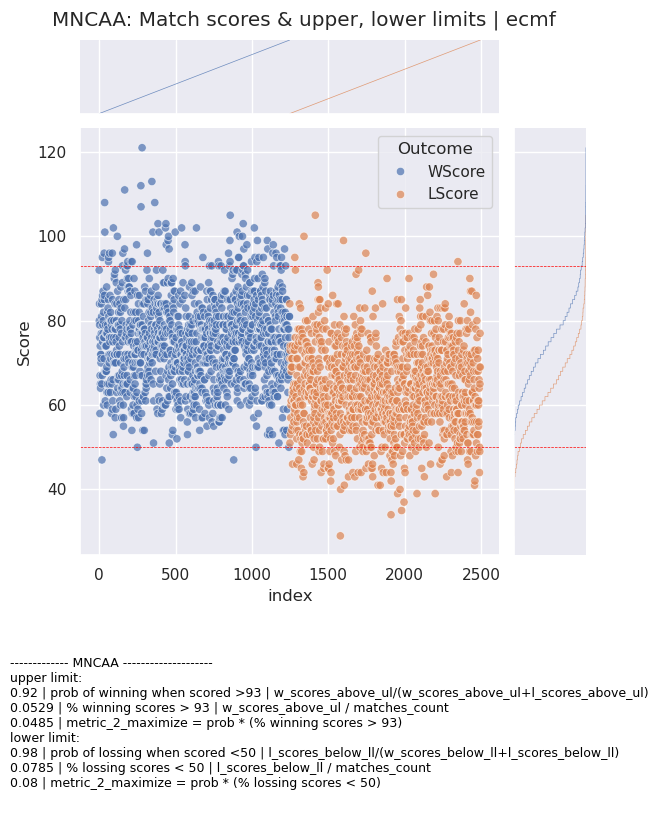

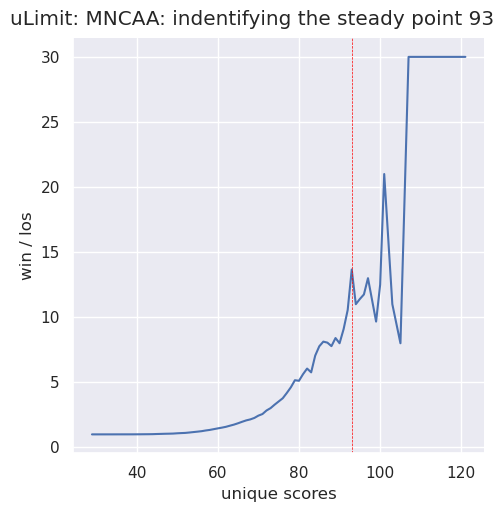

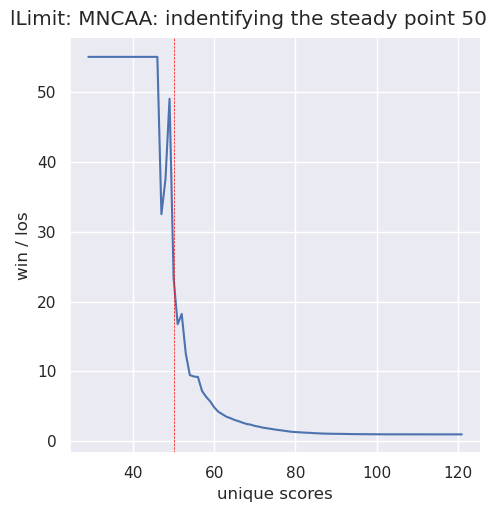


Above ecdf plot says ---> the gap b/w winning loosing socres lines are present.
    gap length looks similar on both low point & high point
    Only thing is 
        in low point, winning ecdf line is almost 0
        in high point, loosing ecdf not fully 1, there is a small gap



In [7]:
score_ulimit_mncaa = 93
score_llimit_mncaa = 50
scores_summary, _, _ = print_scores_summary(
    matches_mncaa_df, 'MNCAA till 2022', ul=score_ulimit_mncaa, ll=score_llimit_mncaa
)
identify_n_show_limits(
    df=matches_mncaa_df,
    ul=score_ulimit_mncaa,
    ll=score_llimit_mncaa,
    ul_larg_num=30,
    ll_larg_num=55,
    label=str_mncaa,
)

a = """
Above ecdf plot says ---> the gap b/w winning loosing socres lines are present.
    gap length looks similar on both low point & high point
    Only thing is 
        in low point, winning ecdf line is almost 0
        in high point, loosing ecdf not fully 1, there is a small gap
"""
print(a)

#### WNCAA

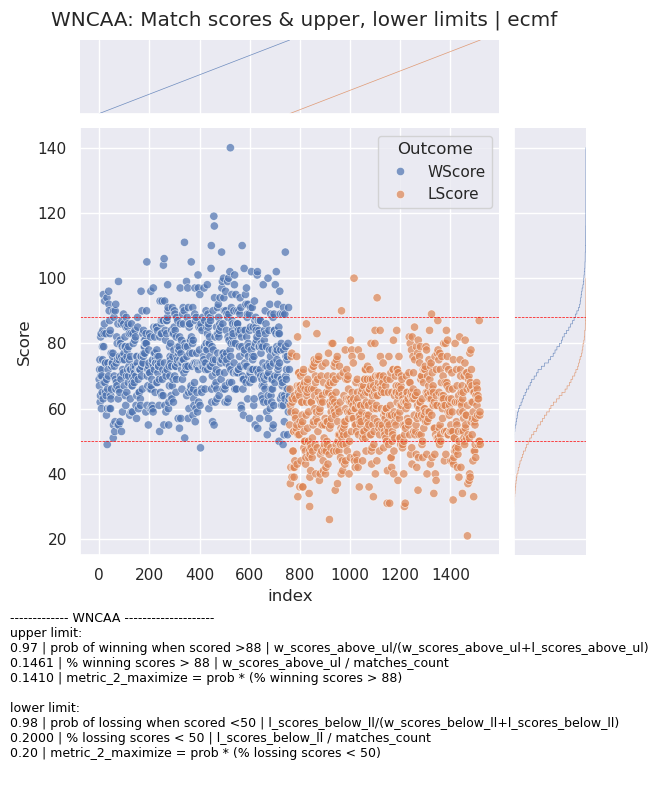

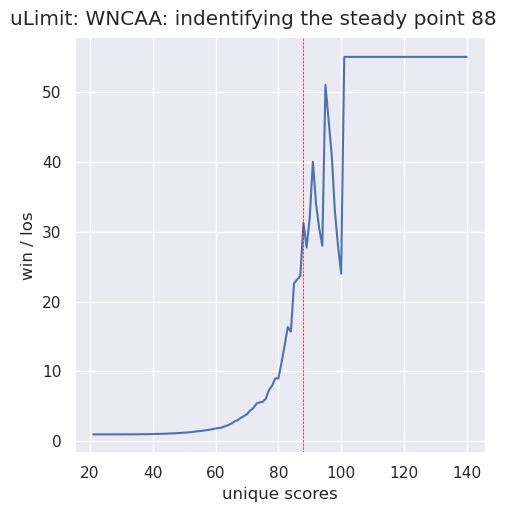

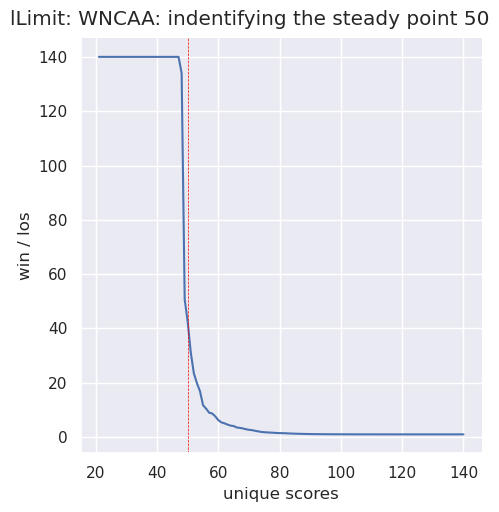

In [26]:
score_ulimit_wncaa = 88
score_llimit_wncaa = 50
identify_n_show_limits(
    df=matches_wncaa_df,
    ul=score_ulimit_wncaa,
    ll=score_llimit_wncaa,
    ul_larg_num=55,
    ll_larg_num=140,
    label=str_wncaa,
)

#### M reg

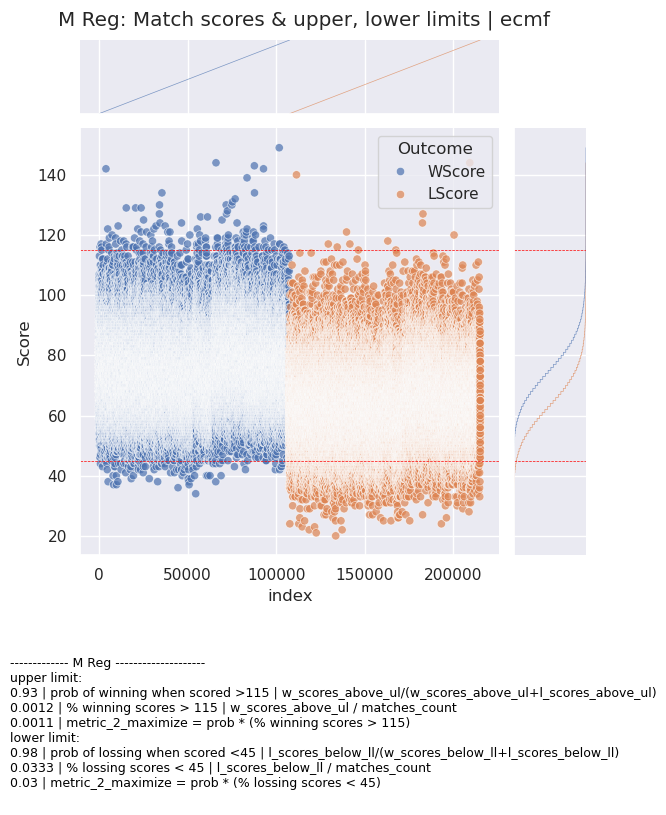

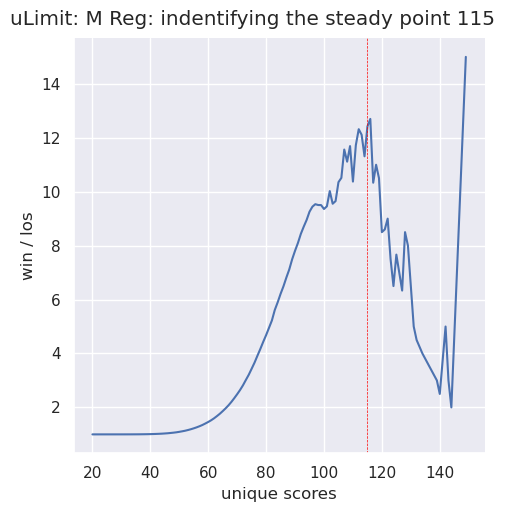

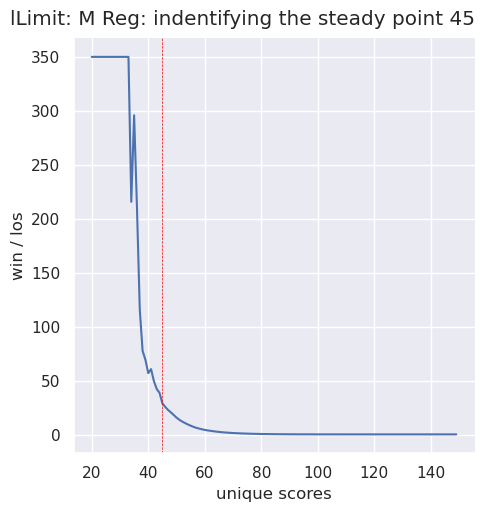

In [9]:
score_ulimit_mreg = 115
score_llimit_mreg = 45
identify_n_show_limits(
    df=matches_mreg_df,
    ul=score_ulimit_mreg,
    ll=score_llimit_mreg,
    ul_larg_num=15,
    ll_larg_num=350,
    label=str_mreg,
)

#### W reg

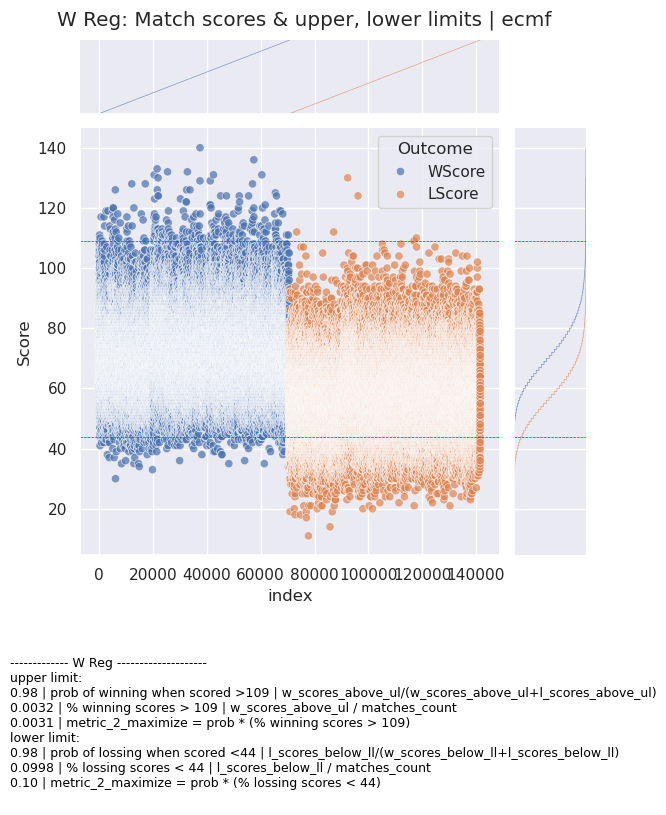

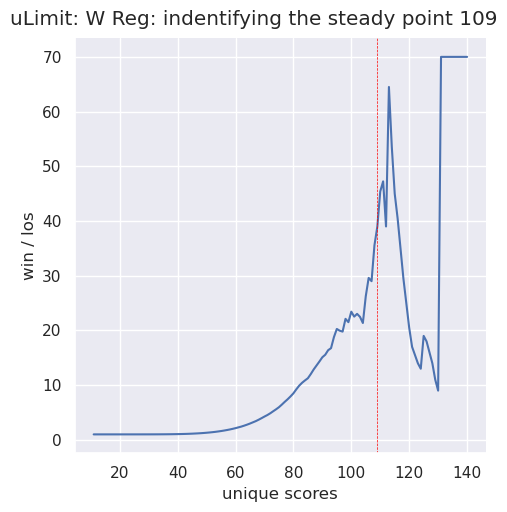

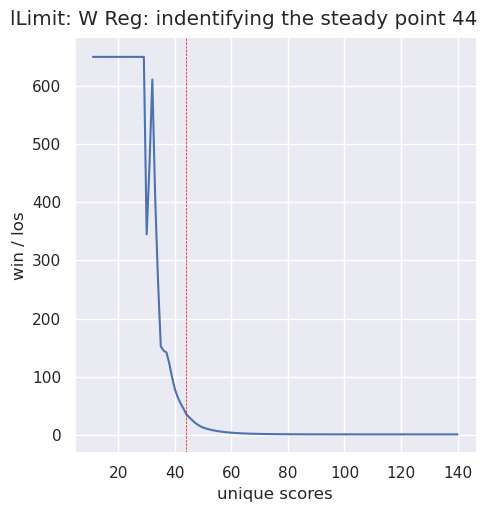

In [10]:
score_ulimit_wreg = 109
score_llimit_wreg = 44
identify_n_show_limits(
    df=matches_wreg_df,
    ul=score_ulimit_wreg,
    ll=score_llimit_wreg,
    ul_larg_num=70,
    ll_larg_num=650,
    label=str_wreg,
)

### Scores summary


metric = prob * density takes maximum value ~60
But its not useful, as we have low prob at this point 0.74 or 0.72 in below wmncaa.

We want to say with high probability either they win or loose.
--> need to filter with high prob say > 0.9

	max ulimit:
	Score 	prob_ul 	percent_ul 	metric_ul 	prob_ll 	percent_ll 	metric_ll
	65 	0.74	 	0.82 		0.61 		0.81	 	0.67 		0.54

	max llimit:
	Score 	prob_ul 	percent_ul 	metric_ul 	prob_ll 	percent_ll 	metric_ll
 	72 	0.84 		0.62 		0.52 		0.72	 	0.86 		0.62



When we look at constrained prob, say prob >.9 --> percent or density is always decreasing (like mncaa below)
i.e, increasing score further we will not have any better results



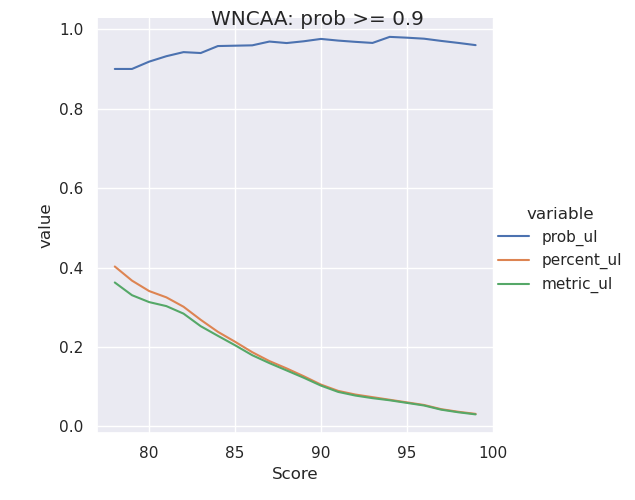

NameError: name 'score_ulimit_mncaa' is not defined

In [28]:
# score_ulimit_mreg=115
# score_llimit_mreg=45
# score_ulimit_wreg=109
# score_llimit_wreg=44
print(
    """
metric = prob * density takes maximum value ~60
But its not useful, as we have low prob at this point 0.74 or 0.72 in below wmncaa.

We want to say with high probability either they win or loose.
--> need to filter with high prob say > 0.9

	max ulimit:
	Score 	prob_ul 	percent_ul 	metric_ul 	prob_ll 	percent_ll 	metric_ll
	65 	0.74	 	0.82 		0.61 		0.81	 	0.67 		0.54

	max llimit:
	Score 	prob_ul 	percent_ul 	metric_ul 	prob_ll 	percent_ll 	metric_ll
 	72 	0.84 		0.62 		0.52 		0.72	 	0.86 		0.62

"""
)
print(
    """
When we look at constrained prob, say prob >.9 --> percent or density is always decreasing (like mncaa below)
i.e, increasing score further we will not have any better results
"""
)
display(Image(filename='plots/score_prob_metric_ul_WNCAA.png'))

summary_txt, _, _ = print_scores_summary(
    matches_mncaa_df, 'MNCAA till 2022', ul=score_ulimit_mncaa, ll=score_llimit_mncaa
)
print(summary_txt)
summary_txt, _, _ = print_scores_summary(
    matches_wncaa_df, 'WNCAA till 2022', ul=score_ulimit_wncaa, ll=score_llimit_wncaa
)
print(summary_txt)
summary_txt, _, _ = print_scores_summary(
    matches_mreg_df, 'M reg till 2023', ul=score_ulimit_mreg, ll=score_llimit_mreg
)
print(summary_txt)
summary_txt, _, _ = print_scores_summary(
    matches_wreg_df, 'W reg till 2023', ul=score_ulimit_wreg, ll=score_llimit_wreg
)
print(summary_txt)

### Optimal prob * density

In [24]:
def optimal_funciton(df: pd.DataFrame, label: str):
    df_optimal_limit = pd.DataFrame({col_score: range(1, 150)})

    def sizes(s):
        _, v1, v2 = print_scores_summary(df, label, ul=s[col_score], ll=s[col_score])
        return v1.prob, v1.percent, v1.metric, v2.prob, v2.percent, v2.metric

    df_optimal_limit[
        [
            col_prob_ul,
            col_percent_ul,
            col_metric_ul,
            col_prob_ll,
            col_percent_ll,
            col_metric_ll,
        ]
    ] = df_optimal_limit.apply(sizes, axis=1, result_type='expand')
    display(df_optimal_limit)

    df_melt = df_optimal_limit.melt(
        id_vars=col_score, value_vars=[col_prob_ul, col_percent_ul, col_metric_ul]
    )
    # sns.relplot(data=df_optimal_limit, x=col_score, y=col_metric_ul, kind='line')
    metric = sns.relplot(
        data=df_melt, x=col_score, y='value', kind='line', hue='variable'
    )
    metric.fig.suptitle(f'{label}: ulimit w.r.t scores')

    max_metric = df_optimal_limit[col_metric_ul].max()
    max_row = df_optimal_limit[df_optimal_limit[col_metric_ul] == max_metric]
    print('max ulimit')
    display(max_row)

    max_metric = df_optimal_limit[col_metric_ll].max()
    max_row = df_optimal_limit[df_optimal_limit[col_metric_ll] == max_metric]
    print('max llimit')
    display(max_row)

    max_row = df_optimal_limit[df_optimal_limit[col_prob_ul] >= 0.85]
    metric = sns.relplot(data=max_row, x=col_prob_ul, y=col_percent_ul, kind='line')
    metric.fig.suptitle(f'{label}: prob vs density')

    max_row = df_optimal_limit[df_optimal_limit[col_prob_ll] >= 0.85]
    metric = sns.relplot(data=max_row, x=col_prob_ll, y=col_percent_ll, kind='line')
    metric.fig.suptitle(f'{label}: prob vs density')

    prob_limit = 0.9
    max_row = df_optimal_limit[df_optimal_limit[col_prob_ul] >= prob_limit]
    max_row = max_row[max_row[col_prob_ul] != 1]
    print(f'prob >= {prob_limit}')
    display(max_row)
    max_row_melt = max_row.melt(
        id_vars=col_score, value_vars=[col_prob_ul, col_percent_ul, col_metric_ul]
    )
    metric = sns.relplot(
        data=max_row_melt, x=col_score, y='value', kind='line', hue='variable'
    )
    metric.fig.suptitle(f'{label}: prob >= {prob_limit}')
    save_fig(file_name=f'score_prob_metric_ul_{label}')

    df_melt = df_optimal_limit.melt(
        id_vars=col_score, value_vars=[col_prob_ll, col_percent_ll, col_metric_ll]
    )
    sns.relplot(data=df_melt, x=col_score, y='value', kind='line', hue='variable')
    max_metric = df_optimal_limit[col_metric_ll].max()
    max_row = df_optimal_limit[df_optimal_limit[col_metric_ll] == max_metric]
    display(max_row)

#### MNCAA

/tmp/ipykernel_927338/1449719315.py:45: RuntimeWarning: invalid value encountered in scalar divide
  prob = l_scores_below_ll / (w_scores_below_ll + l_scores_below_ll)
/tmp/ipykernel_927338/1449719315.py:25: RuntimeWarning: invalid value encountered in scalar divide
  prob = w_scores_above_ul / (w_scores_above_ul+l_scores_above_ul)


Score  prob_ul  percent_ul  metric_ul  prob_ll  percent_ll  metric_ll
0        1      0.5         1.0        0.5      NaN         0.0        NaN
1        2      0.5         1.0        0.5      NaN         0.0        NaN
2        3      0.5         1.0        0.5      NaN         0.0        NaN
3        4      0.5         1.0        0.5      NaN         0.0        NaN
4        5      0.5         1.0        0.5      NaN         0.0        NaN
..     ...      ...         ...        ...      ...         ...        ...
144    145      NaN         0.0        NaN      0.5         1.0        0.5
145    146      NaN         0.0        NaN      0.5         1.0        0.5
146    147      NaN         0.0        NaN      0.5         1.0        0.5
147    148      NaN         0.0        NaN      0.5         1.0        0.5
148    149      NaN         0.0        NaN      0.5         1.0        0.5

[149 rows x 7 columns]

max ulimit


Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
58     59  0.593607      0.9375   0.556507  0.864516    0.322115   0.278474

max llimit


Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
77     78  0.837687    0.359776   0.301379  0.605964    0.911859   0.552554

prob >= 0.9


Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
89      90  0.900901    0.080128   0.072188  0.520675    0.988782   0.514834
90      91  0.913462    0.076122   0.069534  0.518658    0.991186   0.514087
91      92  0.931818    0.065705   0.061225  0.517977    0.992788   0.514241
92      93  0.916667    0.052885   0.048478  0.515781    0.995192   0.513301
93      94  0.919355    0.045673   0.041990  0.512376    0.995192   0.509913
94      95  0.921569    0.037660   0.034707  0.510682    0.995994   0.508636
95      96  0.928571    0.031250   0.029018  0.508793    0.996795   0.507163
96      97  0.918919    0.027244   0.025035  0.507335    0.997596   0.506115
97      98  0.906250    0.023237   0.021059  0.506303    0.997596   0.505086
98      99  0.925926    0.020032   0.018548  0.505276    0.997596   0.504061
99     100  0.954545    0.016827   0.016062  0.504658    0.998397   0.503849
100    101  0.941176    0.012821   0.012066  0.504042    0.999199   0.503638
101    102  0.916667    0.008814   0.008080  0.503025    0.999199   0.502622

Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
77     78  0.837687    0.359776   0.301379  0.605964    0.911859   0.552554

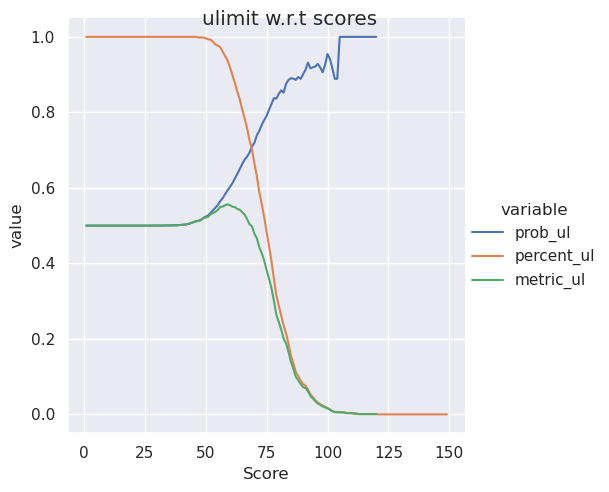

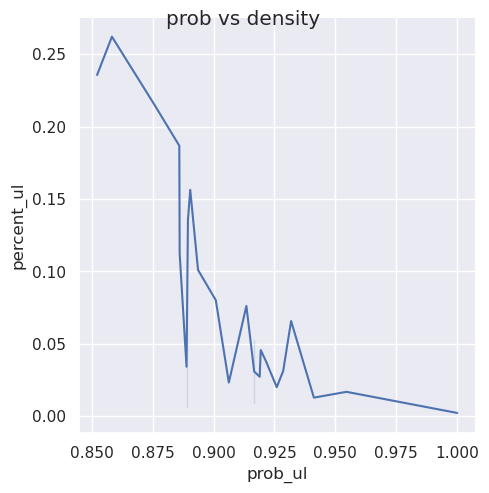

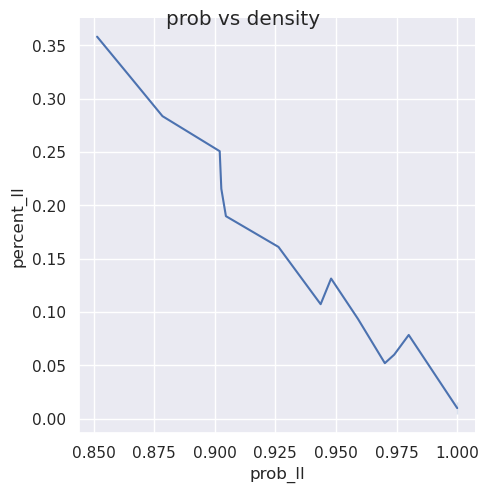

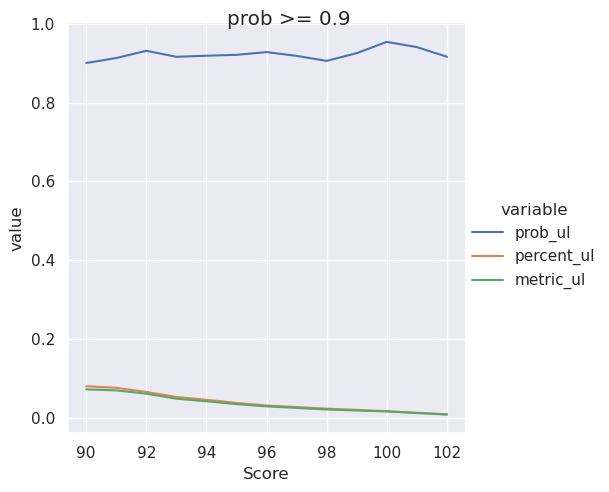

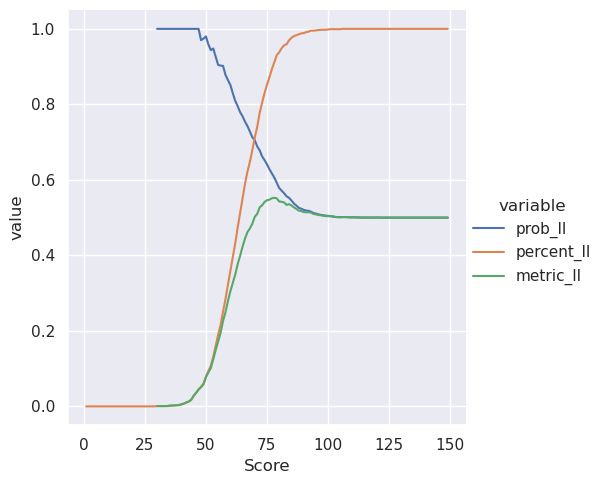

In [96]:
optimal_funciton(df=matches_mncaa_df, label=str_mncaa)

#### WNCAA

/tmp/ipykernel_994328/3974395280.py:44: RuntimeWarning: invalid value encountered in scalar divide
  prob = l_scores_below_ll / (w_scores_below_ll + l_scores_below_ll)
/tmp/ipykernel_994328/3974395280.py:24: RuntimeWarning: invalid value encountered in scalar divide
  prob = w_scores_above_ul / (w_scores_above_ul+l_scores_above_ul)


Score  prob_ul  percent_ul  metric_ul  prob_ll  percent_ll  metric_ll
0        1      0.5         1.0        0.5      NaN         0.0        NaN
1        2      0.5         1.0        0.5      NaN         0.0        NaN
2        3      0.5         1.0        0.5      NaN         0.0        NaN
3        4      0.5         1.0        0.5      NaN         0.0        NaN
4        5      0.5         1.0        0.5      NaN         0.0        NaN
..     ...      ...         ...        ...      ...         ...        ...
144    145      NaN         0.0        NaN      0.5         1.0        0.5
145    146      NaN         0.0        NaN      0.5         1.0        0.5
146    147      NaN         0.0        NaN      0.5         1.0        0.5
147    148      NaN         0.0        NaN      0.5         1.0        0.5
148    149      NaN         0.0        NaN      0.5         1.0        0.5

[149 rows x 7 columns]

max ulimit


Score  prob_ul  percent_ul  metric_ul  prob_ll  percent_ll  metric_ll
64     65     0.74        0.82       0.61     0.81        0.67       0.54

max llimit


Score  prob_ul  percent_ul  metric_ul  prob_ll  percent_ll  metric_ll
71     72     0.84        0.62       0.52     0.72        0.86       0.62

prob >= 0.9


Score  prob_ul  percent_ul  metric_ul  prob_ll  percent_ll  metric_ll
77     78     0.90        0.40       0.36     0.62        0.95       0.59
78     79     0.90        0.37       0.33     0.62        0.96       0.59
79     80     0.92        0.34       0.31     0.60        0.96       0.58
80     81     0.93        0.33       0.30     0.60        0.97       0.58
81     82     0.94        0.30       0.28     0.59        0.98       0.58
82     83     0.94        0.27       0.25     0.58        0.98       0.57
83     84     0.96        0.24       0.23     0.57        0.98       0.56
84     85     0.96        0.21       0.20     0.56        0.99       0.56
85     86     0.96        0.19       0.18     0.56        0.99       0.55
86     87     0.97        0.16       0.16     0.55        0.99       0.55
87     88     0.97        0.15       0.14     0.54        0.99       0.54
88     89     0.97        0.13       0.12     0.54        0.99       0.54
89     90     0.98        0.11       0.10     0.53        1.00       0.53
90     91     0.97        0.09       0.09     0.53        1.00       0.53
91     92     0.97        0.08       0.08     0.52        1.00       0.52
92     93     0.97        0.07       0.07     0.52        1.00       0.52
93     94     0.98        0.07       0.07     0.52        1.00       0.52
94     95     0.98        0.06       0.06     0.52        1.00       0.52
95     96     0.98        0.05       0.05     0.52        1.00       0.51
96     97     0.97        0.04       0.04     0.51        1.00       0.51
97     98     0.97        0.04       0.04     0.51        1.00       0.51
98     99     0.96        0.03       0.03     0.51        1.00       0.51

Score  prob_ul  percent_ul  metric_ul  prob_ll  percent_ll  metric_ll
71     72     0.84        0.62       0.52     0.72        0.86       0.62

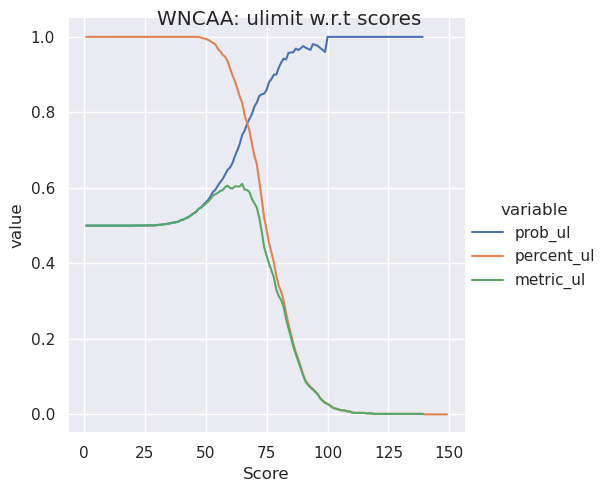

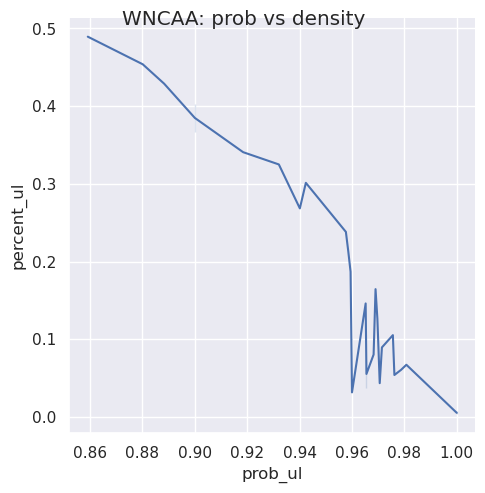

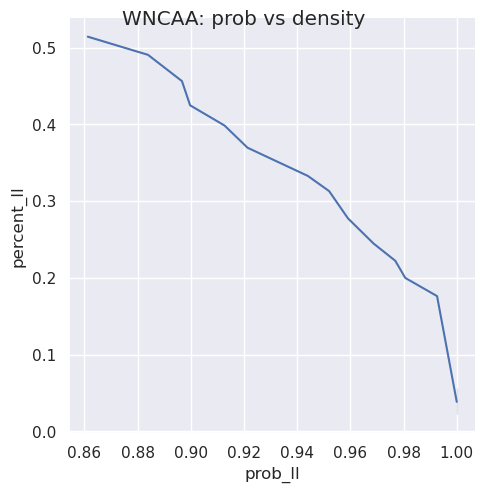

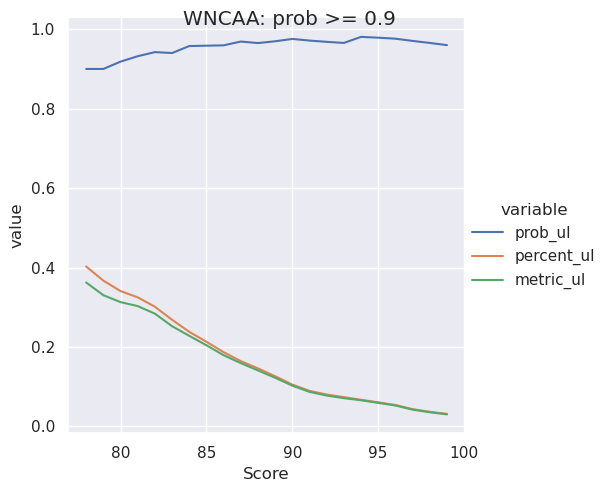

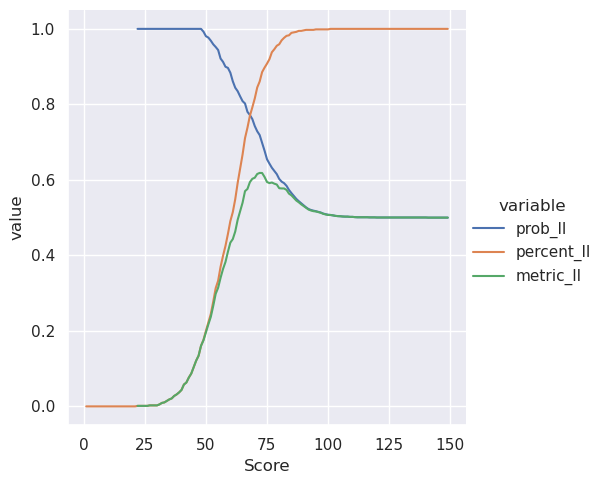

In [25]:
%precision 2
optimal_funciton(df=matches_wncaa_df, label=str_wncaa)

#### M reg

/tmp/ipykernel_927338/1449719315.py:45: RuntimeWarning: invalid value encountered in scalar divide
  prob = l_scores_below_ll / (w_scores_below_ll + l_scores_below_ll)
/tmp/ipykernel_927338/1449719315.py:25: RuntimeWarning: invalid value encountered in scalar divide
  prob = w_scores_above_ul / (w_scores_above_ul+l_scores_above_ul)


Score  prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
0        1      0.5    1.000000   0.500000       NaN         0.0        NaN
1        2      0.5    1.000000   0.500000       NaN         0.0        NaN
2        3      0.5    1.000000   0.500000       NaN         0.0        NaN
3        4      0.5    1.000000   0.500000       NaN         0.0        NaN
4        5      0.5    1.000000   0.500000       NaN         0.0        NaN
..     ...      ...         ...        ...       ...         ...        ...
144    145      1.0    0.000009   0.000009  0.500002         1.0   0.500002
145    146      1.0    0.000009   0.000009  0.500002         1.0   0.500002
146    147      1.0    0.000009   0.000009  0.500002         1.0   0.500002
147    148      1.0    0.000009   0.000009  0.500002         1.0   0.500002
148    149      NaN    0.000000        NaN  0.500002         1.0   0.500002

[149 rows x 7 columns]

max ulimit


Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
60     61  0.614544    0.908096   0.558065  0.837476    0.393194    0.32929

max llimit


Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
76     77  0.806426    0.413643   0.333572  0.616628    0.885166   0.545819

prob >= 0.9


Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
93      94  0.902518    0.049287   0.044483  0.513085    0.993627   0.509815
94      95  0.904251    0.042291   0.038242  0.511299    0.994676   0.508578
95      96  0.905094    0.036150   0.032719  0.509680    0.995522   0.507397
96      97  0.904814    0.030734   0.027808  0.508255    0.996209   0.506328
97      98  0.904792    0.026311   0.023806  0.506994    0.996767   0.505355
98      99  0.903459    0.022084   0.019952  0.505973    0.997231   0.504572
99     100  0.904375    0.018628   0.016847  0.504992    0.997640   0.503800
100    101  0.909283    0.016017   0.014564  0.504208    0.998030   0.503215
101    102  0.905243    0.013314   0.012052  0.503637    0.998402   0.502832
102    103  0.906110    0.011298   0.010237  0.503002    0.998606   0.502301
103    104  0.911922    0.009523   0.008684  0.502548    0.998829   0.501959
104    105  0.913136    0.008009   0.007313  0.502162    0.999080   0.501700
105    106  0.920398    0.006875   0.006328  0.501820    0.999238   0.501437
106    107  0.917445    0.005472   0.005020  0.501576    0.999405   0.501278
107    108  0.921201    0.004562   0.004202  0.501249    0.999508   0.501002
108    109  0.912088    0.003856   0.003517  0.501045    0.999610   0.500850
109    110  0.921409    0.003159   0.002911  0.500873    0.999628   0.500687
110    111  0.924915    0.002518   0.002329  0.500724    0.999731   0.500589
111    112  0.923729    0.002025   0.001871  0.500579    0.999796   0.500477
112    113  0.918782    0.001682   0.001545  0.500465    0.999833   0.500381
113    114  0.925466    0.001384   0.001281  0.500384    0.999851   0.500309
114    115  0.927007    0.001180   0.001094  0.500318    0.999889   0.500263
115    116  0.911765    0.000864   0.000788  0.500272    0.999907   0.500225
116    117  0.916667    0.000715   0.000656  0.500195    0.999916   0.500153
117    118  0.913043    0.000585   0.000534  0.500163    0.999935   0.500130
120    121  0.900000    0.000334   0.000301  0.500088    0.999954   0.500065

Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
76     77  0.806426    0.413643   0.333572  0.616628    0.885166   0.545819

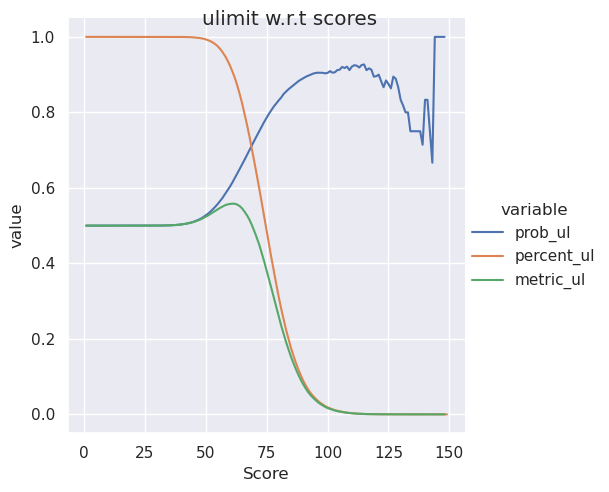

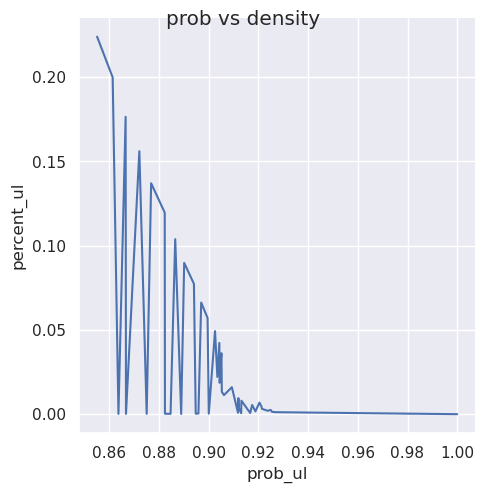

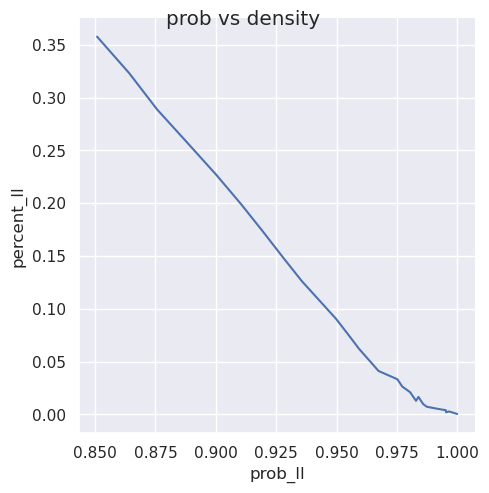

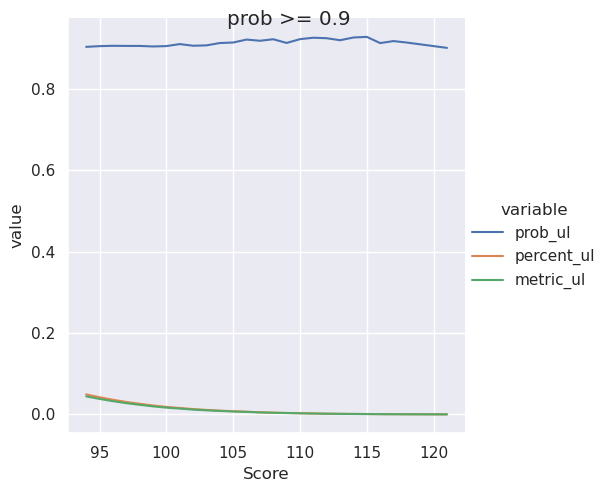

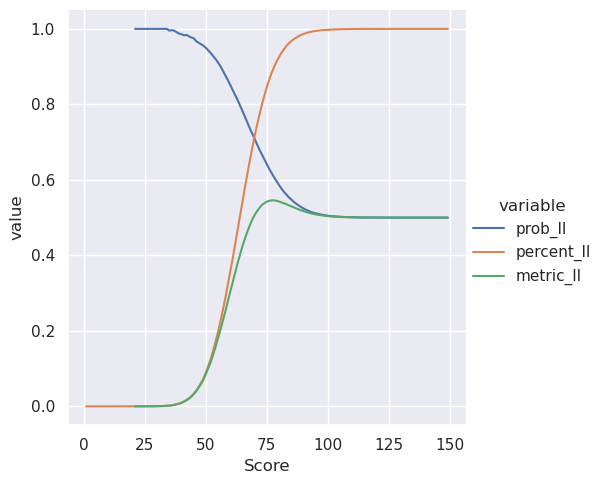

In [98]:
optimal_funciton(df=matches_mreg_df, label=str_mreg)

#### W reg

/tmp/ipykernel_927338/1449719315.py:45: RuntimeWarning: invalid value encountered in scalar divide
  prob = l_scores_below_ll / (w_scores_below_ll + l_scores_below_ll)
/tmp/ipykernel_927338/1449719315.py:25: RuntimeWarning: invalid value encountered in scalar divide
  prob = w_scores_above_ul / (w_scores_above_ul+l_scores_above_ul)


Score  prob_ul  percent_ul  metric_ul  prob_ll  percent_ll  metric_ll
0        1      0.5         1.0        0.5      NaN         0.0        NaN
1        2      0.5         1.0        0.5      NaN         0.0        NaN
2        3      0.5         1.0        0.5      NaN         0.0        NaN
3        4      0.5         1.0        0.5      NaN         0.0        NaN
4        5      0.5         1.0        0.5      NaN         0.0        NaN
..     ...      ...         ...        ...      ...         ...        ...
144    145      NaN         0.0        NaN      0.5         1.0        0.5
145    146      NaN         0.0        NaN      0.5         1.0        0.5
146    147      NaN         0.0        NaN      0.5         1.0        0.5
147    148      NaN         0.0        NaN      0.5         1.0        0.5
148    149      NaN         0.0        NaN      0.5         1.0        0.5

[149 rows x 7 columns]

max ulimit


Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
56     57  0.654206      0.9017   0.589897  0.856507    0.486911   0.417043

max llimit


Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
69     70  0.819204    0.508399   0.416482  0.656849    0.872074    0.57282

prob >= 0.9


Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
79      80  0.902251    0.204993   0.184955  0.558144    0.972974   0.543060
80      81  0.908279    0.183829   0.166968  0.551552    0.977791   0.539303
81      82  0.912517    0.163867   0.149531  0.545968    0.981436   0.535833
82      83  0.915692    0.144851   0.132639  0.540693    0.984290   0.532199
83      84  0.918440    0.128067   0.117622  0.535703    0.986663   0.528558
84      85  0.923193    0.112753   0.104093  0.531360    0.988627   0.525317
85      86  0.927859    0.099939   0.092730  0.527524    0.990619   0.522575
86      87  0.931497    0.087408   0.081420  0.524354    0.992230   0.520279
87      88  0.934767    0.075512   0.070587  0.521242    0.993572   0.517891
88      89  0.937873    0.066541   0.062407  0.518300    0.994730   0.515569
89      90  0.939590    0.057570   0.054092  0.516105    0.995592   0.513830
90      91  0.942480    0.050464   0.047561  0.513893    0.996299   0.511991
91      92  0.943692    0.043330   0.040890  0.512172    0.996920   0.510595
92      93  0.949434    0.037933   0.036015  0.510425    0.997415   0.509106
93      94  0.952984    0.032932   0.031383  0.509161    0.997980   0.508133
94      95  0.952270    0.028750   0.027378  0.507964    0.998375   0.507139
95      96  0.951886    0.024596   0.023413  0.506932    0.998559   0.506201
96      97  0.956743    0.021248   0.020329  0.505915    0.998757   0.505286
97      98  0.955572    0.018536   0.017712  0.505129    0.999039   0.504644
98      99  0.959064    0.016219   0.015555  0.504462    0.999138   0.504027
99     100  0.957490    0.013365   0.012797  0.503915    0.999308   0.503566
100    101  0.958383    0.011387   0.010913  0.503215    0.999407   0.502917
101    102  0.957418    0.009847   0.009428  0.502739    0.999506   0.502491
102    103  0.955272    0.008448   0.008070  0.502364    0.999562   0.502144
103    104  0.963303    0.007417   0.007145  0.502022    0.999604   0.501824
104    105  0.967320    0.006273   0.006068  0.501791    0.999717   0.501649
105    106  0.966667    0.005326   0.005149  0.501520    0.999788   0.501414
106    107  0.972644    0.004521   0.004397  0.501289    0.999816   0.501197
107    108  0.975000    0.003857   0.003760  0.501101    0.999873   0.501037
108    109  0.978448    0.003207   0.003138  0.500941    0.999901   0.500892
109    110  0.979275    0.002670   0.002615  0.500785    0.999929   0.500750
110    111  0.975000    0.002204   0.002149  0.500654    0.999943   0.500626
111    112  0.984733    0.001822   0.001795  0.500537    0.999943   0.500509
112    113  0.981651    0.001512   0.001484  0.500449    0.999972   0.500435
113    114  0.978261    0.001271   0.001244  0.500371    0.999972   0.500357
114    115  0.975904    0.001144   0.001117  0.500311    0.999972   0.500297
115    116  0.972222    0.000989   0.000961  0.500279    0.999972   0.500265
116    117  0.967213    0.000834   0.000806  0.500240    0.999972   0.500226
117    118  0.961538    0.000706   0.000679  0.500201    0.999972   0.500187
118    119  0.953488    0.000579   0.000552  0.500170    0.999972   0.500155
119    120  0.944444    0.000480   0.000454  0.500138    0.999972   0.500124
120    121  0.939394    0.000438   0.000411  0.500113    0.999972   0.500099
121    122  0.933333    0.000396   0.000369  0.500102    0.999972   0.500088
122    123  0.928571    0.000367   0.000341  0.500092    0.999972   0.500078
123    124  0.950000    0.000268   0.000255  0.500085    0.999972   0.500071
124    125  0.947368    0.000254   0.000241  0.500064    0.999986   0.500057
125    126  0.933333    0.000198   0.000185  0.500060    0.999986   0.500053
126    127  0.933333    0.000198   0.000185  0.500046    0.999986   0.500039
127    128  0.916667    0.000155   0.000142  0.500046    0.999986   0.500039
128    129  0.900000    0.000127   0.000114  0.500035    0.999986   0.500028

Score   prob_ul  percent_ul  metric_ul   prob_ll  percent_ll  metric_ll
69     70  0.819204    0.508399   0.416482  0.656849    0.872074    0.57282

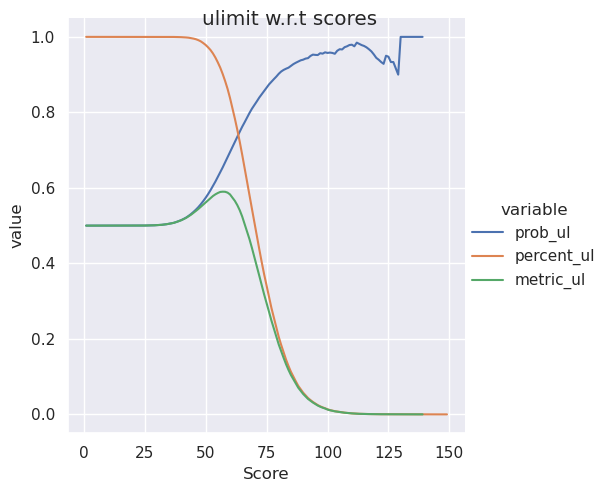

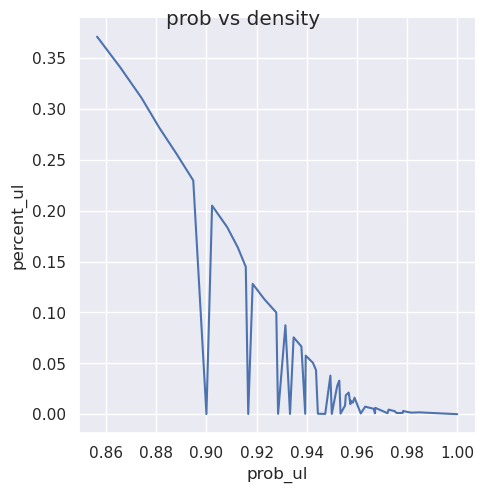

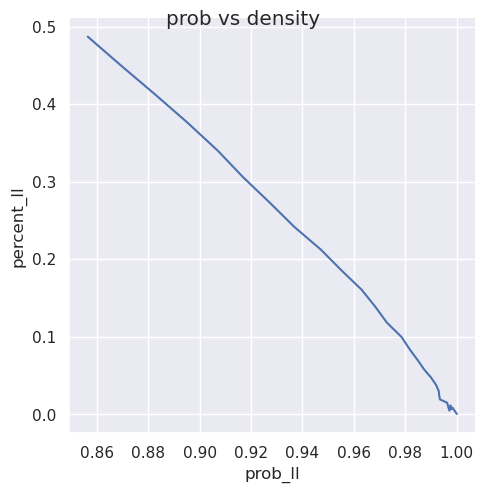

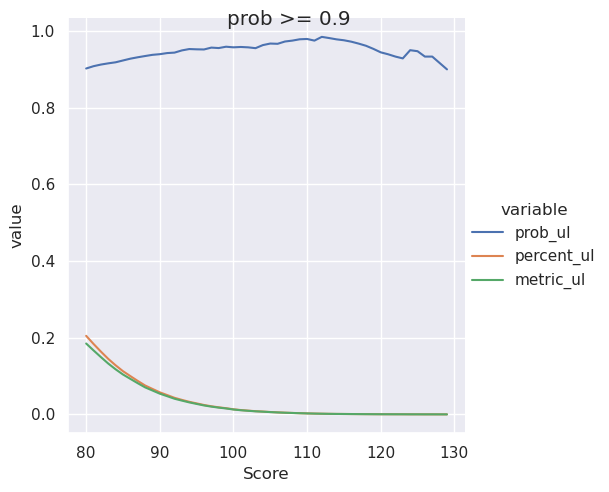

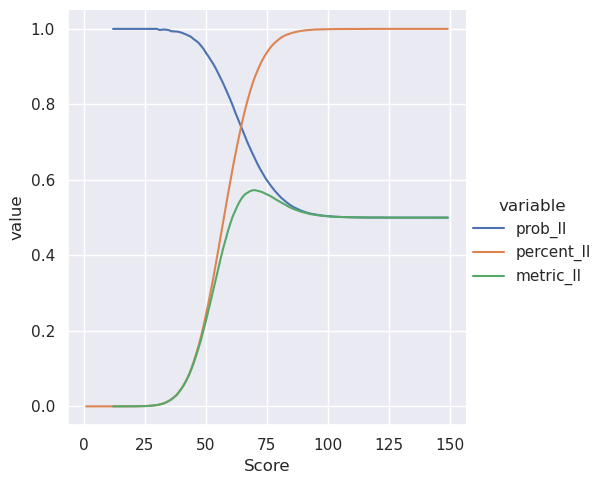

In [99]:
optimal_funciton(df=matches_wreg_df, label=str_wreg)

### saved Insights

In [87]:
a = """
Regular 2022
percent 0.0031588531504914805 | w_scores_above_110 / w_scores_count | 340 / 107634
percent 0.009745991043722244 | l_scores_below_40 / w_scores_count | 1049 / 107634

MNCAA 2022
percent 0.28846153846153844 | w_scores_above_80 / w_scores_count | 360 / 1248
percent 0.18990384615384615 | l_scores_below_55 / w_scores_count | 237 / 1248
"""
print(a)

display(Image(filename=image_scores_dist_regular_2022))


Regular 2022
percent 0.0031588531504914805 | w_scores_above_110 / w_scores_count | 340 / 107634
percent 0.009745991043722244 | l_scores_below_40 / w_scores_count | 1049 / 107634

MNCAA 2022
percent 0.28846153846153844 | w_scores_above_80 / w_scores_count | 360 / 1248
percent 0.18990384615384615 | l_scores_below_55 / w_scores_count | 237 / 1248



FileNotFoundError: [Errno 2] No such file or directory: 'scores_Dist_NCAA_2022.png'

## Y-data: Save report to html

In [25]:
profile = ProfileReport(df, title='Profiling Report')
# profile.to_file(data_file + ".html")

### Correlation

In [1]:
print(pd.get_option('display.width'))
# default is 80
pd.set_option('display.width', 80)

# pd.set_option('display.max_rows',500)
# pd.set_option('display.max_columns',504)
print(pd.get_option('display.max_columns'))
# default is 20
pd.set_option('display.max_columns', 40)

display((df.corr(numeric_only=True)).loc[[col_tru_stnt, col_tru_prob], :])
print((df.corr(numeric_only=True)).loc[:, [col_tru_stnt, col_tru_prob]])

NameError: name 'pd' is not defined

# Visualize data | graphs

In [6]:
%matplotlib inline

# figure size in inches
# default= 6.4, 4.8 | W, H
# rcParams['figure.figsize'] = 10,4.8
# rcParams['figure.figsize'] = 6.4,4.8
# rcParams['figure.figsize'] = 8,7

# rcParams['figure.figsize'] = 72,7 # Scores diff

print('Figure size: ')
print(rcParams['figure.figsize'])

Figure size: 
[6.4, 4.8]


## Univariate

### Gap b/w Winning & Loosing scores

RangeIndex(start=0, stop=107634, step=1)

index  Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  \
0            0    2003      10     1104      68     1328      62    N      0   
1            1    2003      10     1272      70     1393      63    N      0   
2            2    2003      11     1266      73     1437      61    N      0   
3            3    2003      11     1296      56     1457      50    N      0   
4            4    2003      11     1400      77     1208      71    N      0   
...        ...     ...     ...      ...     ...      ...     ...  ...    ...   
107629  107629    2023     132     1104      82     1401      63    N      0   
107630  107630    2023     132     1272      75     1222      65    A      0   
107631  107631    2023     132     1343      74     1463      65    H      0   
107632  107632    2023     132     1345      67     1336      65    N      0   
107633  107633    2023     132     1433      68     1173      56    N      0   

        WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  \
0         27    58      3     14    11    18   14   24    13   23     7     1   
1         26    62      8     20    10    19   15   28    16   13     4     4   
2         24    58      8     18    17    29   17   26    15   10     5     2   
3         18    38      3      9    17    31    6   19    11   12    14     2   
4         30    61      6     14    11    13   17   22    12   14     4     4   
...      ...   ...    ...    ...   ...   ...  ...  ...   ...  ...   ...   ...   
107629    27    66     12     36    16    22   21   29    16   12     6     7   
107630    27    53      6     12    15    21    9   27    11   11     4     2   
107631    23    57      9     23    19    24   11   25    11    5     3     2   
107632    24    62      6     28    13    20   13   25    17    7     5     0   
107633    24    52      8     17    12    20   11   22    17    6     4     3   

        WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  \
0        22    22    53      2     10    16    22   10   22     8   18     9   
1        18    24    67      6     24     9    20   20   25     7   12     8   
2        25    22    73      3     26    14    23   31   22     9   12     2   
3        18    18    49      6     22     8    15   17   20     9   19     4   
4        20    24    62      6     16    17    27   21   15    12   10     7   
...     ...   ...   ...    ...    ...   ...   ...  ...  ...   ...  ...   ...   
107629   19    19    64      5     15    20    24   17   20     6   13     5   
107630   18    20    64      6     25    19    28   22   20    11   10     5   
107631   18    22    50      8     22    13    19    6   25    12   10     3   
107632   14    22    51      7     23    14    15    4   27    14   10     4   
107633   19    18    56      3     22    17    20   16   22    11    8     1   

        LBlk  LPF  Win Score Prob  Strength (W| W,L)  
0          2   20        0.523077           1.096774  
1          6   16        0.526316           1.111111  
2          5   23        0.544776           1.196721  
3          3   23        0.528302           1.120000  
4          1   14        0.520270           1.084507  
...      ...  ...             ...                ...  
107629     2   21        0.565517           1.301587  
107630     4   19        0.535714           1.153846  
107631     7   20        0.532374           1.138462  
107632     2   20        0.507576           1.030769  
107633     6   21        0.548387           1.214286  

[107634 rows x 37 columns]

KeyboardInterrupt: 

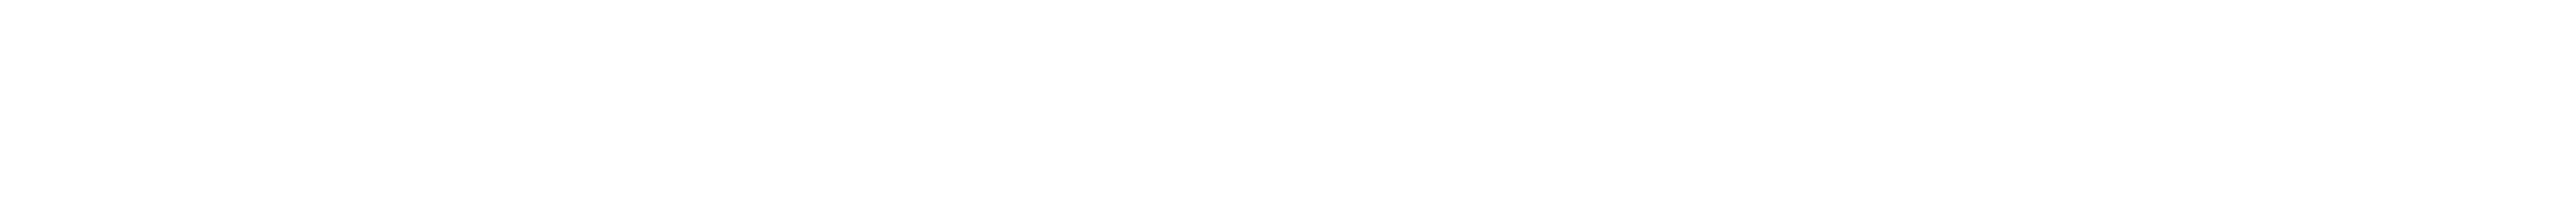

Error in callback <function flush_figures at 0x78a6688e1f80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [11]:
%matplotlib widget
plt.close('all')
plt.figure(figsize=(76, 6))
plt.figure(figsize=(18, 6))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
display(df.index)
display(df)

plt.vlines(data=df, x=col_index, ymin=col_LScore, ymax=col_WScore, colors='g')
# ax.axvline(x="1181",ymin=58,ymax=66)
sns.swarmplot(data=df, x=col_index, y=col_LScore)
# sns.scatterplot(data=df,x=col_index,y=col_LScore)
ax = sns.swarmplot(data=df, x=df.index, y=col_WScore)
# ax.set(xlabel=None)

ax.set(xticklabels=[])
# plt.xticks(ticks=df.index,labels=[])

# plt.vlines(x=1181,ymin=58,ymax=66)
# plt.vlines(x=0,ymin=82,ymax=94)
# ax.refline()
# plt.vlines(data=df, x=col_index,ymin=col_LScore,ymax=col_WScore)
# g.axvline(x=df[col_index],ymin=3,ymax=7)
# plt.axis('off')
plt.show()
# plt.savefig("score_gap.svg", format='svg',dpi=150)

In [30]:
print('Figure size: ')
print(rcParams['figure.figsize'])

Figure size: 
[8.0, 7.0]


## Relation plot

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4


Text(0.5, 0.98, 'Tips Broken Out by Gender')

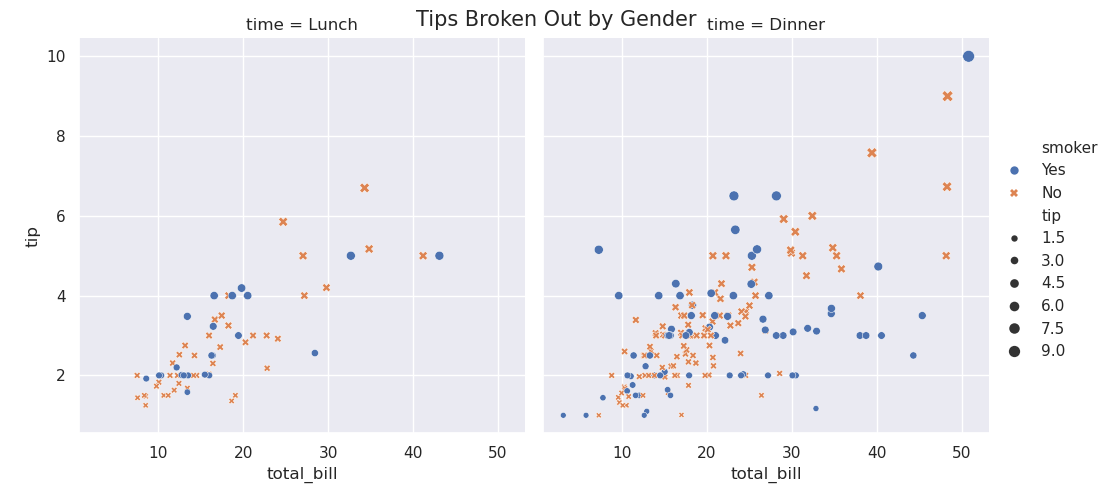

In [31]:
# Load an example dataset
tips = sns.load_dataset('tips')
print(tips.head())

# Create a visualization
# , col="day",
# sns.set(title="bla")
sns.relplot(
    data=tips,
    x='total_bill',
    y='tip',
    col='time',
    hue='smoker',
    style='smoker',
    size='tip',
).fig.suptitle('Tips Broken Out by Gender', size=15)
# .set_title("bla")
# scatter.fig.suptitle('Tips Broken Out by Gender', size=15)

  subject  timepoint event    region    signal
0     s13         18  stim  parietal -0.017552
1      s5         14  stim  parietal -0.080883
2     s12         18  stim  parietal -0.081033
3     s11         18  stim  parietal -0.046134
4     s10         18  stim  parietal -0.037970


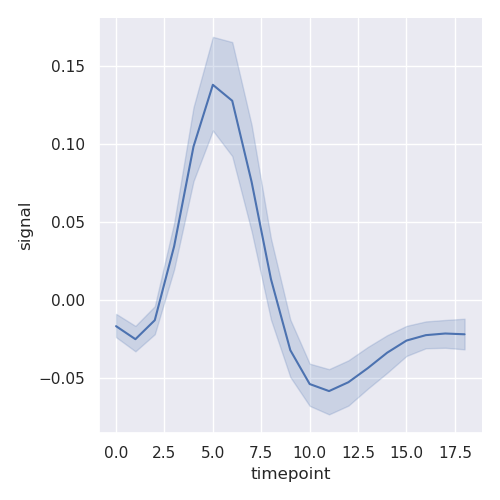

In [32]:
fmri = sns.load_dataset('fmri')
print(fmri.head())
sns.relplot(data=fmri, x='timepoint', y='signal', kind='line')

In [33]:
dots = sns.load_dataset('dots')
print(dots.tail())
dots.query("align == 'dots'").tail()

    align choice  time  coherence  firing_rate
843  sacc     T2   300        3.2    33.281734
844  sacc     T2   300        6.4    27.583979
845  sacc     T2   300       12.8    28.511530
846  sacc     T2   300       25.6    27.009804
847  sacc     T2   300       51.2    30.959302


align choice  time  coherence  firing_rate
389  dots     T2   680        3.2    37.806267
390  dots     T2   700        0.0    43.464959
391  dots     T2   700        3.2    38.994559
392  dots     T2   720        0.0    41.987121
393  dots     T2   720        3.2    41.716057

In [34]:
df = sns.load_dataset('tips')
sns.barplot(data=df, x='day', y='tip', errorbar=None).set_title('Sample Title')

Text(0.5, 1.0, 'Sample Title')

## Bivariate | Distribution plot

### Correlation heatmap

In [35]:
print(df.columns)
# sns.displot(df,x=df.columns, y=df.columns, hue=col_tru_stnt)
# sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)
# sns.heatmap(df.corr(numeric_only=True), cmap=sns.color_palette("coolwarm", as_cmap=True),vmax=1,vmin=-1)
sns.heatmap(
    df.corr(numeric_only=True),
    cmap=sns.color_palette('RdBu', as_cmap=True),
    vmax=1,
    vmin=-1,
    xticklabels=True,
    yticklabels=True,
    square=True,
)

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object')


<Axes: title={'center': 'Sample Title'}>

In [36]:
sns.heatmap(df.corr(numeric_only=True), cmap=sns.color_palette('coolwarm'))

<Axes: title={'center': 'Sample Title'}>

## Different plots

### load data

In [37]:
df = pd.read_csv('nba.csv')
print(df.head())

# import matplotlib.pyplot as plt
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
df.query('Age < 26', inplace=True)
print(df.describe())
print(df.loc[:, ['Age', 'Number']].head())
df.head(n=10)

FileNotFoundError: [Errno 2] No such file or directory: 'nba.csv'

### Plots

In [ ]:
# plotting lineplot
# sns.lineplot(data=df, x='Age', y='Weight').set_title("Line Plot")

# sns.scatterplot(data=df, x='Age', y='Weight', hue ="Position").set_title("Scatter Plot")
# sns.boxplot(data=df, x='Age').set_title("Box Plot")

# Apply the default theme
# sns.set_theme()

# figure size in inches
print(rcParams['figure.figsize'])  # = 11.7,8.27

# rcParams['figure.figsize'] = 10,4.8
# default= 6.4, 4.8
# rcParams['figure.figsize'] = 6.4,4.8

# sns.color_palette('deep')

# sns.boxplot(data=df, x='Age', y='Weight', hue='Age').set_title("Box Plot")
# sns.violinplot(data=df, x='Age', y='Weight', hue='Age').set_title("Violin Plot")
# sns.violinplot(data=df, x='Age').set_title("Violin Plot")
# sns.swarmplot(data=df, x="Age").set_title("Swarm Plot")

# df = pd.read_csv("bi-dir.csv", skipinitialspace= True)
# print(df.head())
# ax=sns.barplot(data=df, x = 'score', y = 'bench', errorbar = None)
# ax.set_title("Bar Plot: Bi-directional")
# ax.bar_label(ax.containers[0])

# df = sns.load_dataset('titanic')
# print(df.head())
# class v / s fare barplot
# without error bars
# sns.barplot(y = 'class', x = 'fare', data = df, errorbar = None)

# class v / s fare barplot with same colour
# sns.barplot(x = 'class', y = 'fare', data = df, color = "salmon").set_title("Bar Plot")
# sns.barplot(x = 'class', y = 'fare', data = df, color = "salmon", errorbar = None)

# sns.relplot(x = "Age", y = "Weight", data = df)
# sns.pointplot(x = "Age", y = "Weight", data = df).set_title('Point Plot')
# df.loc[:,['Age','Weight']].head()
# sns.countplot(data=df, x="Age",hue='Age').set_title('Count Plot')
# sns.kdeplot(data=df, x='Age').set_title('KDE Plot: Uni variate')
sns.kdeplot(data=df, x='Age', y='Number').set_title('KDE Plot: Multi variate')

# ANN

## Preprocess Data

### Form Train, Test: drop loc, create strength

In [10]:
def make_train_test(
    X_reg: pd.DataFrame, X_ncaa: pd.DataFrame, pred_year: int, years_cap: int = None
):
    def only_teamID_day_sth_prb_tru_outcm(X: pd.DataFrame):
        X_tmp = X.copy()  # placeholder with same dimention as "X"
        X_tmp.loc[:, :] = 0
        X_tmp.loc[
            :,
            [
                col_wteam,
                col_lteam,
                col_day_num,
                col_tru_stnt,
                col_tru_prob,
                col_tru_outcome,
            ],
        ] = X.loc[
            :,
            [
                col_wteam,
                col_lteam,
                col_day_num,
                col_tru_stnt,
                col_tru_prob,
                col_tru_outcome,
            ],
        ]
        return X_tmp

    def combine_season_day(X: pd.DataFrame):
        X[col_day_num] += (pred_year - X[col_season]) * 365
        X = X.drop([col_season], axis=1)
        return X

    def append_cols_tru_stnth_tru_prb_tru_outcm(X: pd.DataFrame):
        def calc_strnt(row):
            if row[col_wteam] > row[col_lteam]:
                return row[col_LScore] / row[col_WScore]
            return row[col_WScore] / row[col_LScore]

        def calc_prob(row):
            if row[col_wteam] > row[col_lteam]:
                return row[col_LScore] / (row[col_WScore] + row[col_LScore])
            return row[col_WScore] / (row[col_WScore] + row[col_LScore])

        X[col_tru_stnt] = X.apply(calc_strnt, axis=1)
        X[col_tru_prob] = X.apply(calc_prob, axis=1)
        X[col_tru_outcome] = (X[col_tru_prob] > 0.5).astype(int)
        return X

    # # Filtering so easier to debug
    # X_train = pd.DataFrame(matches_mreg_df.query(f'Season >= {pred_year-5} and Season <= {pred_year}'))
    # X_train.reset_index(inplace=True, drop=True)
    # # full data

    X_train = X_reg.query(f'{col_season} <= {pred_year}').copy().reset_index(drop=True)
    X_train_ncaa = (
        X_ncaa.query(f'{col_season} < {pred_year}').copy().reset_index(drop=True)
    )
    X_train = pd.concat([X_train, X_train_ncaa], axis=0, ignore_index=True)

    X_train.drop(
        [col_wloc, col_index], inplace=True, axis=1
    )  # for now lets drop the location
    if years_cap is not None:
        years_cap = pred_year - years_cap
        # years_cap = str(pred_year-years_cap)
        # dispi(type(years_cap))
        # dispi((years_cap))
    if years_cap is not None:
        X_train = X_train.query(f'{col_season} >= {years_cap}').reset_index(drop=True)
    dispd('X_train concat Reg & NCAA')
    dispd_df(X_train)
    dispd(X_train.describe())

    X_train = combine_season_day(X_train)
    X_train = append_cols_tru_stnth_tru_prb_tru_outcm(X_train)
    # Train for test data format | only having teams & day
    X_train = pd.concat(
        [X_train, only_teamID_day_sth_prb_tru_outcm(X=X_train)],
        ignore_index=True,
        axis=0,
    )

    X_test = X_ncaa.query(f'{col_season} == {pred_year}').copy().reset_index(drop=True)

    X_test.drop(
        [col_wloc, col_index], inplace=True, axis=1
    )  # for now lets drop the location
    if years_cap is not None:
        X_test = X_test.query(f'{col_season} >= {years_cap}').reset_index(drop=True)

    X_test = combine_season_day(X_test)  # just drops season
    X_test = append_cols_tru_stnth_tru_prb_tru_outcm(X_test)
    X_test = only_teamID_day_sth_prb_tru_outcm(X_test)
    X_test.loc[:, col_day_num] = (
        day_ncaa_start  # predicting for all teams on tournment start day itself
    )

    cols_tru_strnt_tru_prob_tru_outcm = [col_tru_stnt, col_tru_prob, col_tru_outcome]
    y_train_st_prb_outcm = pd.DataFrame(X_train[cols_tru_strnt_tru_prob_tru_outcm])
    y_test_st_prb_outcm = pd.DataFrame(X_test[cols_tru_strnt_tru_prob_tru_outcm])
    X_train.drop(cols_tru_strnt_tru_prob_tru_outcm, inplace=True, axis=1)
    X_test.drop(cols_tru_strnt_tru_prob_tru_outcm, inplace=True, axis=1)

    dispd_df(X_train)
    dispd_df(y_train_st_prb_outcm)
    dispd(y_train_st_prb_outcm.describe())
    dispd_df(X_test)
    dispd_df(y_test_st_prb_outcm)
    return X_train, y_train_st_prb_outcm, X_test, y_test_st_prb_outcm

#### Men

In [11]:
pred_year = 2022
years_cap = 10
(X_train_m, y_train_st_prb_outcm_m, X_test_m, y_test_st_prb_outcm_m) = make_train_test(
    matches_mreg_df, matches_mncaa_df, pred_year, years_cap
)

#### Women & combine with men

In [12]:
(X_train_w, y_train_st_prb_outcm_w, X_test_w, y_test_st_prb_outcm_w) = make_train_test(
    matches_wreg_df, matches_wncaa_df, pred_year, years_cap
)

X_train_mw = pd.concat([X_train_m, X_train_w], axis=0, ignore_index=True)
y_train_st_prb_outcm_mw = pd.concat(
    [y_train_st_prb_outcm_m, y_train_st_prb_outcm_w], axis=0, ignore_index=True
)
X_test_mw = pd.concat([X_test_m, X_test_w], axis=0, ignore_index=True)
y_test_st_prb_outcm_mw = pd.concat(
    [y_test_st_prb_outcm_m, y_test_st_prb_outcm_w], axis=0, ignore_index=True
)

### Scale numbericals

In [13]:
# X_train.drop(col_index, inplace=True, axis=1)
dispi(
    Markdown(
        """
1 ht encoder is not properly handling catergory variable teamID  
--> when same teamID is present in both wTeam & lTeam, they are not be treadeted differently | independently  
    --> For teamID 1104 two columns are being generated WTeamID_1104 & LTeamID_1104  
DayNum 	WTeamID	WScore 	LTeamID	LScore 	NumOT  
1836 	1104 	70 	1104 	53 	0  
132 	1463 	66 	1104 	64 	0  

WTeamID_1104	WTeamID_1463	LTeamID_1104	DayNum 	NumOT 	WScore  
1.0 		0.0 		1.0 		1.0	0.0 	1.20  
0.0 		1.0 		1.0 		-1.0	0.0 	1.08  

But scaling is not workign properly.  
wScore & lScore are being scaled independenlty  
in 1st row its 1 & -1, i.e, wsocre is > lScore  
in 2nd row its -1 & 1. i.e, wsocre is < lScore, which is not the case  
"""
    )
)


# this is outside as its needed to scale test data as well
def scale_num_clmns(X: pd.DataFrame, sc: StandardScaler, cols: List[str]):
    X = X.copy()
    for col in cols:
        X[col] = sc.transform(X[col].to_numpy().reshape(-1, 1))
    return X


def fit_n_scale_num_cols(X_train: pd.DataFrame):
    # for easier development: running this cell again & again | Startign from clean slate
    X_trai = X_train.copy()

    def fit_sclr(X: pd.DataFrame, cols: List[str]):
        list_cols = []
        for col in cols:
            list_cols.append(X[col])
        sc = StandardScaler()
        scores = (
            pd.concat(list_cols, ignore_index=True, axis=0).to_numpy().reshape(-1, 1)
        )
        sc.fit(scores)
        return sc

    def fit_n_scale_clms_grp(X: pd.DataFrame, clms_grps: List[List[str]]):
        """
        Seperate fit & scale, as on test data only scaling is done
        """
        for cols in clms_grps:
            sclr = fit_sclr(X, cols)
            scale_num_clmns(X, sclr, cols)
        return X

    # generic rule: no problem in splitting & scaling them individually
    # We don't know if clubbing them losses any data
    # --> lets split them
    cols_grps = [
        [col_WScore, col_LScore],
        # field goals | lets split 3 pt & 1 pt as mean is different ---------------
        [col_wfgm, col_lfgm],
        [col_wfga, col_lfga],  # field goals | 1 pt
        [col_wfgm3, col_lfgm3],
        [col_wfga3, col_lfga3],  # field goals | 3 pt
        [col_wftm, col_lftm],
        [col_wfta, col_lfta],  # free throws
        [col_wor, col_lor],
        [col_wdr, col_ldr],  # Rebounds | offencive
        # rest
        [col_wast, col_last],
        [col_wto, col_lto],
        [col_wstl, col_lstl],  # Assist | Turn overs | Steals
        [col_wblk, col_lblk],
        [col_wpf, col_lpf],  # Blocks | personal fouls
        [col_num_ot],  # max is 4, most of them are 0. | keep it as its or to scale ?
    ]

    X_trai = fit_n_scale_clms_grp(X_trai, cols_grps)

    # daynum | Only thing to scale in test is day num rest all are 0
    # doing seperately as scalar needed to be saved to use on test data as well
    sclr_day_num = StandardScaler()
    X_trai[col_day_num] = sclr_day_num.fit_transform(
        X_trai[col_day_num].to_numpy().reshape(-1, 1)
    )

    dispd('After Scale')
    dispd_df(X_trai)
    dispd('orig X_train')
    dispd_df(X_train)

    return X_trai, sclr_day_num  # sclr_day_num to scale test data


X_train_s_mw, sclr_day_num_mw = fit_n_scale_num_cols(X_train_mw)
X_test_s_mw = scale_num_clmns(X_test_mw, sclr_day_num_mw, [col_day_num])


1 ht encoder is not properly handling catergory variable teamID  
--> when same teamID is present in both wTeam & lTeam, they are not be treadeted differently | independently  
    --> For teamID 1104 two columns are being generated WTeamID_1104 & LTeamID_1104  
DayNum 	WTeamID	WScore 	LTeamID	LScore 	NumOT  
1836 	1104 	70 	1104 	53 	0  
132 	1463 	66 	1104 	64 	0  

WTeamID_1104	WTeamID_1463	LTeamID_1104	DayNum 	NumOT 	WScore  
1.0 		0.0 		1.0 		1.0	0.0 	1.20  
0.0 		1.0 		1.0 		-1.0	0.0 	1.08  

But scaling is not workign properly.  
wScore & lScore are being scaled independenlty  
in 1st row its 1 & -1, i.e, wsocre is > lScore  
in 2nd row its -1 & 1. i.e, wsocre is < lScore, which is not the case  


### Encode categroies

In [14]:
# team ID
dispi(
    Markdown(
        """  
 for X_trai  
 2362 rows × 33 columns    default  
 2362x539 sparse matrix    encoder on 2 column, 539-33 = 506 additions  
 2362x286 sparse matrix    encoder on 1 column, 286-33 = 253 additions
 """
    )
)


# transform function is needed to encode test data as well
def ohe_transform(X: pd.DataFrame, ohe: OneHotEncoder, cols: List[str]):
    if len(cols) != 2:
        display('Error')
        return
    teams = pd.concat([X[cols[0]], X[cols[1]]], ignore_index=True, axis=0)
    teams = teams.to_numpy().reshape(-1, 1)
    teams = ohe.transform(teams)

    # ohe_teams_names = list(ohe.get_feature_names_out(['team']))
    ohe_teams_names = list(ohe.get_feature_names_out())
    encoded_df = pd.DataFrame(teams, columns=ohe_teams_names)
    # Split the encoded DataFrame back into two parts to match the original rows of lbl1 and lbl2
    encoded_df1 = encoded_df.iloc[: len(X)].reset_index(drop=True)
    encoded_df2 = encoded_df.iloc[len(X) :].reset_index(drop=True)

    comb_df = encoded_df1 + encoded_df2
    comb_df = pd.concat([X, comb_df], axis=1)
    comb_df = comb_df.drop(columns=cols_teams)
    return comb_df


def fit_n_encode_cat(X_trai: pd.DataFrame):
    def ohe_fit(X: pd.DataFrame, cols: List[str]):
        if len(cols) != 2:
            display('Error: len != 2')
            return
        teams = pd.concat([X[cols[0]], X[cols[1]]], ignore_index=True, axis=0)
        teams = teams.to_numpy().reshape(-1, 1)

        def custom_combiner(feature, category):
            return str(category)

        ohe = OneHotEncoder(
            handle_unknown='error',
            sparse_output=False,
            dtype=int,
            feature_name_combiner=custom_combiner,
        )
        ohe.fit(teams)
        return ohe

    ohe = ohe_fit(X_trai, cols_teams)
    X_trai = ohe_transform(X_trai, ohe, cols_teams)

    dispd('After encode')
    dispd_df(X_trai)
    return X_trai, ohe  # ohe is needed to encode test data as well


X_train_se_mw, ohe_mw = fit_n_encode_cat(X_train_s_mw)
X_test_se_mw = ohe_transform(X_test_s_mw, ohe_mw, cols_teams)
X_train_e_mw = ohe_transform(X_train_mw, ohe_mw, cols_teams)
X_test_e_mw = ohe_transform(X_test_mw, ohe_mw, cols_teams)
dispi('done encode')

  
 for X_trai  
 2362 rows × 33 columns    default  
 2362x539 sparse matrix    encoder on 2 column, 539-33 = 506 additions  
 2362x286 sparse matrix    encoder on 1 column, 286-33 = 253 additions
 

'done encode'

## Build ANN model & Fit

### Build

'fit_ann'

'0.68174 Loss (binary_crossentropy) 0.69142 val_loss | 0.24441 mse (Brier score) 0.24752 val_mse | Epoch 1 / 2'

'0.66629 Loss (binary_crossentropy) 0.67978 val_loss | 0.23725 mse (Brier score) 0.24200 val_mse | Epoch 2 / 2'

'Time taken to fit the model: 0:00:15'

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 50)             │        37,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,255 (501.00 KB)

 Trainable params: 42,751 (167.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,504 (334.00 KB)

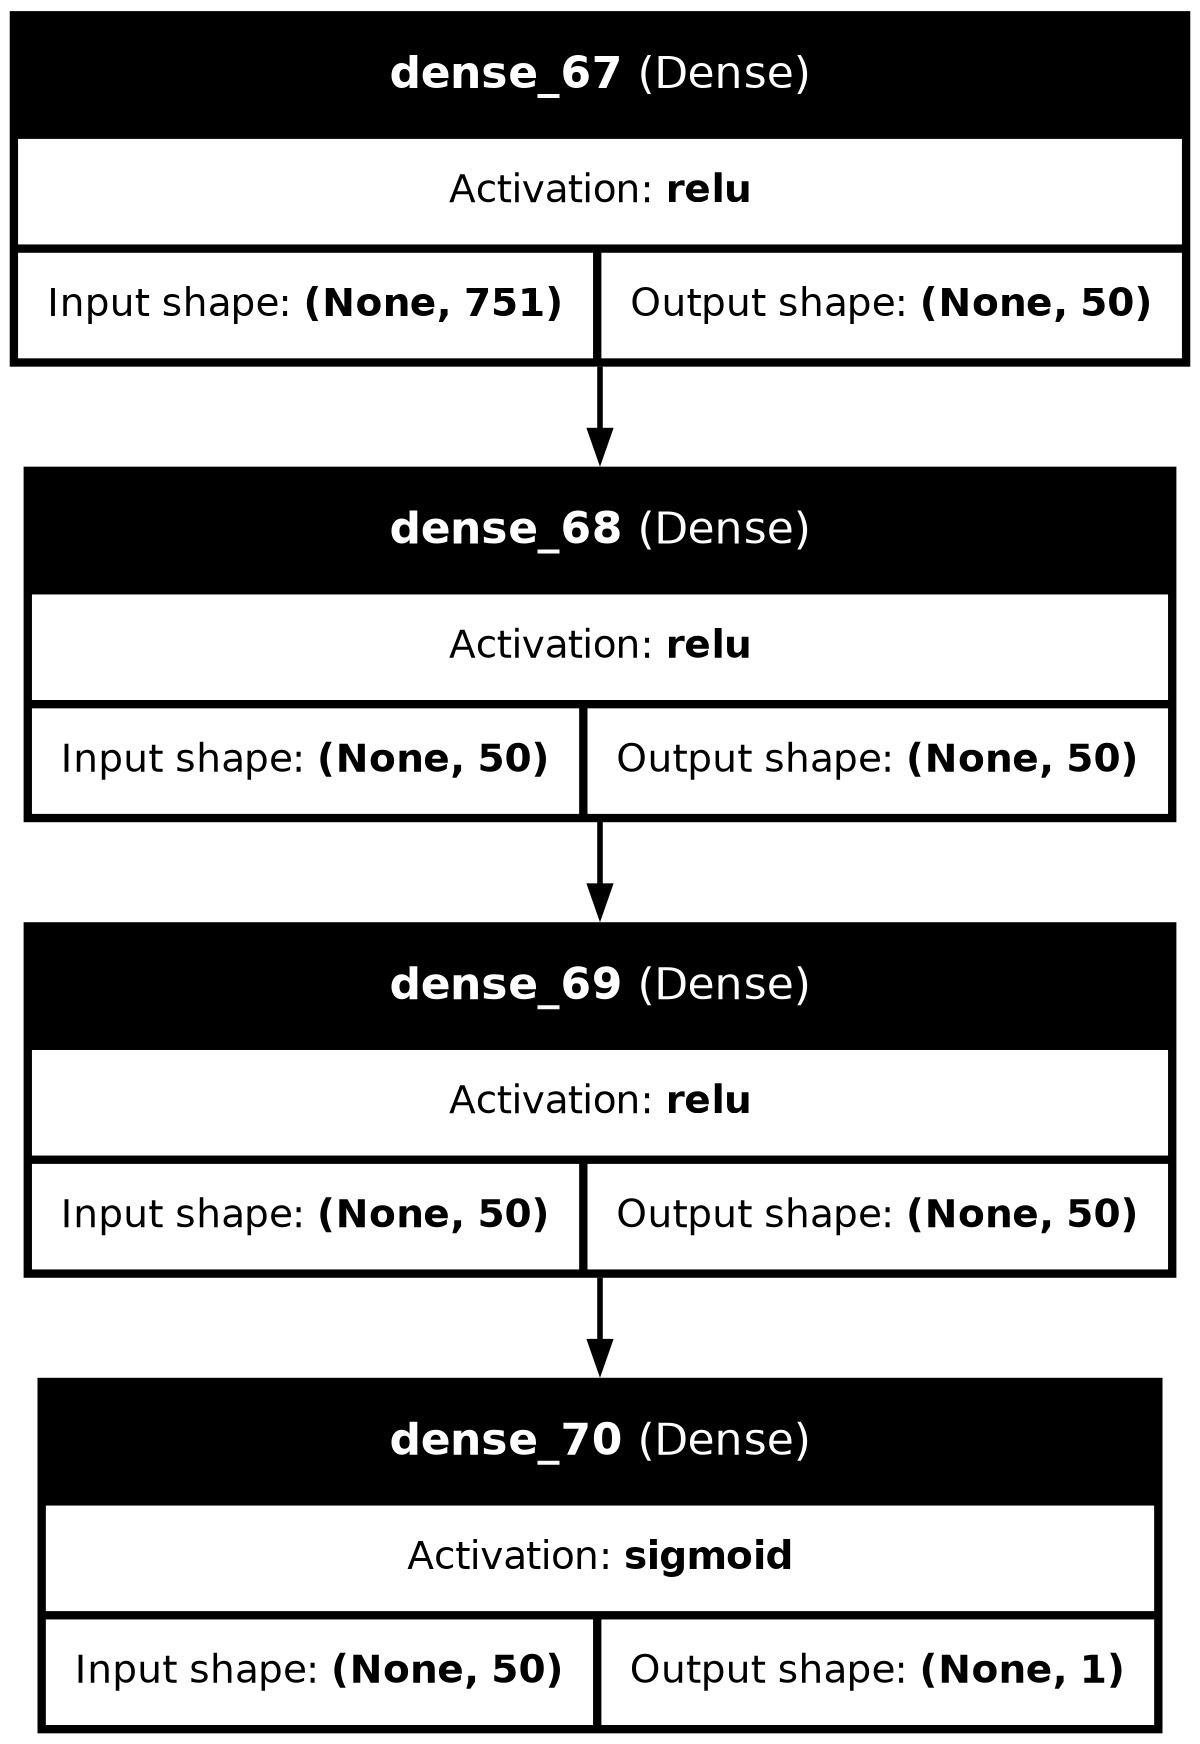

'saved model'


**Approach 5** | Kaggle score: **0.24850**  
 | Refit with updated variable names  
 | Correcting the Mis predictions query  
 | Most of the predictions are around 0.5 only !! like 0.52 | 0.48 ...  
 
2023  
Epoch 100 / 200, Loss: 0.027276    
Epoch 150 / 200, Loss: 0.026409  
Epoch 200 / 200, Loss: 0.025902  

2023 run2  
Epoch 50 / 200, Loss: 0.029774  
Epoch 100 / 200, Loss: 0.027688  
Epoch 150 / 200, Loss: 0.026750  
Epoch 200 / 200, Loss: 0.026219  

2022  
Epoch 50 / 200, Loss: 0.030186  
Epoch 100 / 200, Loss: 0.028387  
Epoch 150 / 200, Loss: 0.027530  
Epoch 200 / 200, Loss: 0.027078

**Approach 5** | Kaggle score: **0.24850**  
 | Refit with updated variable names  
 | Correcting the Mis predictions query  
 | Most of the predictions are around 0.5 only !! like 0.52 | 0.48 ...  
 
2023  
Epoch 100 / 200, Loss: 0.027276  
Epoch 150 / 200, Loss: 0.026409  
Epoch 200 / 200, Loss: 0.025902  

2022  
Epoch 50 / 200, Loss: 0.030186  
Epoch 100 / 200, Loss: 0.028387  
Epoch 150 / 200, Loss: 0.027530  
Epoch 200 / 200, Loss: 0.027078  

**Approach 4** | 11% -- good for submission | score: 0.24748, leaderboard: 940 / 1033 = 91%  
 | Strength ordered by default = its of small teamID  
 | scaled, 1hot encoded  
 | combined M & W  
 | How is score: 0.24748 is coming ?  
 50 = neuron's count  
 02 = hidden layer's count  
Epoch 50/200   mse: 0.0287  
Epoch 100/200  mse: 0.0266  
Epoch 143/200  mse: 0.0254  
Had run for 200, after connection lost rest is not available !!!!!!!!!!!!!!!!!!!!!!!!!!

**Approach 3** | To submit need to predict for Women as well  
 | Strength by default is ordered = its of small teamID  
 | scaled, encoded  
 | only men  
 50 = neuron's count  
 02 = hidden layer's count  
Stabilises at ~ epoch 150  
Epoch 50/400  mse: 0.0155  
Epoch 100/400  mse: 0.0130  
Epoch 150/400  mse: 0.0120  
Epoch 400/400  mse: 0.0123  

**Approach 2** | 25%  
 | Strength by default is ordered = its of small teamID  
 | unscaled & not encoded  
 50 = neuron's count  
 02 = hidden layer's count  
Stabilises at ~ epoch 150  
Epoch 50/400  mse: 0.0196  
Epoch 100/400  mse: 0.0151  
Epoch 150/400  mse: 0.0137  
Epoch 200/400  mse: 0.0133  
Epoch 250/400  mse: 0.0130  
Epoch 300/400  mse: 0.0136  
Epoch 350/400  mse: 0.0126  
Epoch 400/400  mse: 0.0123

**Approach 1** | 50% -- Failed: Could predict with only prob 0.5%  
 | Using inverted strength for the order.  
 16 = neuron's count  
 02 = hidden layer's count  
  
x, x_0, x_0 inverted, accuray did go > 0  
after 316 epoch loss < 10.0, after 500 epoch --> loss < 5.0  
Epoch 998/1000  accuracy: 0.0000e+00 - loss: 0.4796  
Epoch 999/1000  accuracy: 0.0000e+00 - loss: 0.0853  
Epoch 1000/1000  accuracy: 0.0000e+00 - loss: 0.0979  


In [124]:
str_prcnt_miss_preds = 'prcnt_miss_preds'


@keras.saving.register_keras_serializable()
class CustomMetric(keras.metrics.Metric):
    def __init__(self, name=str_prcnt_miss_preds, **kwargs):
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self.result_var = self.add_weight(name='result_var', initializer='zeros')

    # @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Vectorized operation for misprediction count
        mis_pred_count = tf.reduce_sum(
            tf.cast(
                tf.logical_or(
                    tf.logical_and(y_true <= 1.0, y_pred >= 1.0),
                    tf.logical_and(y_true >= 1.0, y_pred <= 1.0),
                ),
                tf.float32,
            )
        )
        total_count = tf.cast(
            tf.shape(y_true)[0], tf.float32
        )  # Total number of samples
        # result = mis_pred_count / total_count if total_count > 0 else 0.0
        result = tf.cond(
            total_count > 0,
            lambda: mis_pred_count / total_count,  # If total_count > 0
            lambda: tf.constant(0.0),  # If total_count == 0
        )
        self.result_var.assign(result)

    def result(self):
        return self.result_var

    def reset_states(self):
        self.result_var.assign(0.0)

    def get_config(self):
        # Return the config for saving the model
        base_config = super(CustomMetric, self).get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
        # Deserialize the custom metric from its config
        return cls(**config)


@keras.saving.register_keras_serializable()
class CustomMetric_Prob(keras.metrics.Metric):
    def __init__(self, name=str_prcnt_miss_preds, **kwargs):
        super(CustomMetric_Prob, self).__init__(name=name, **kwargs)
        self.result_var = self.add_weight(name='result_var', initializer='zeros')

    # @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Vectorized operation for misprediction count
        mis_pred_count = tf.reduce_sum(
            tf.cast(
                tf.logical_or(
                    tf.logical_and(y_true <= 0.5, y_pred >= 0.5),
                    tf.logical_and(y_true >= 0.5, y_pred <= 0.5),
                ),
                tf.float32,
            )
        )
        total_count = tf.cast(
            tf.shape(y_true)[0], tf.float32
        )  # Total number of samples
        # result = mis_pred_count / total_count if total_count > 0 else 0.0
        result = tf.cond(
            total_count > 0,
            lambda: mis_pred_count / total_count,  # If total_count > 0
            lambda: tf.constant(0.0),  # If total_count == 0
        )
        self.result_var.assign(result)

    def result(self):
        return self.result_var

    def reset_states(self):
        self.result_var.assign(0.0)

    def get_config(self):
        # Return the config for saving the model
        base_config = super(CustomMetric_Prob, self).get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
        # Deserialize the custom metric from its config
        return cls(**config)


def fit_ann(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    epochs: int,
    nodes_hidn_lyr: int,
    file_best_loss: str,
    prgrs_rprt_intrvl: int,
    val_data: Tuple[pd.DataFrame, pd.DataFrame],
):
    dispi(inspect.currentframe().f_code.co_name)
    # dispi(pd.DataFrame(X_train.columns).head(46))
    # dispi_df(X_train)
    # return
    ann = keras.models.Sequential()
    ann.add(
        keras.layers.Dense(units=nodes_hidn_lyr, activation='relu')
    )  # hidden layer 1
    ann.add(
        keras.layers.Dense(units=nodes_hidn_lyr, activation='relu')
    )  # hidden layer 2
    ann.add(
        keras.layers.Dense(units=nodes_hidn_lyr, activation='relu')
    )  # hidden layer 3

    # output layer no actication funcion ==> regression
    ann.add(keras.layers.Dense(units=1, activation='sigmoid'))  # For Brier
    # ann.add(keras.layers.Dense(units=1))

    # ann.add(keras.layers.Dense(units=1, activation='linear'))
    # ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy']) # compile

    # ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])
    # tf did not take 'prcnt_miss_preds_strnt' for loss function
    # ValueError: No gradients provided for any variable.
    # loss function needs to be differentiable
    #  the logic you are using (boolean comparisons) may not be differentiable.
    # TensorFlow cannot calculate gradients for non-differentiable
    # especially for functions tf.cond, tf.logical_and, etc.
    # ann.compile(optimizer = 'adam', loss = prcnt_miss_preds_strnt, metrics = ['mse'])
    # ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', prcnt_miss_preds_strnt])

    # Brier
    ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
    # ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [CustomMetric()])
    # # Lets stick to strength
    # ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [CustomMetric_Prob()])

    # ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [metrics_kr.MeanSquaredError])
    # MeanSquaredError

    # Saving model during fit so its not lost
    save_best_model = ModelCheckpoint(
        filepath=file_best_loss,  # Path to save the model file
        monitor='loss',  # Monitor validation loss
        save_best_only=True,  # Save only the best model
        mode='min',  # Save when the loss decreases
        verbose=0,  # Show saving message
    )

    class ReportProgrsEveryNthEpoch(Callback):
        def __init__(self, n, epochs, file_name: str):
            super(ReportProgrsEveryNthEpoch, self).__init__()
            self.n = n
            self.epochs = epochs
            self.best_loss = 500
            self.file_name = file_name

        def on_epoch_end(self, epoch, logs=None):
            loss = logs.get('loss')
            val_loss = logs.get('val_loss')
            # dispi(logs.keys())
            if (epoch + 1) % self.n == 0:
                dispi(
                    f'{loss:.5f} Loss (binary_crossentropy) {val_loss:.5f} val_loss | '
                    + f"{logs.get('mse'):.5f} mse (Brier score) {logs.get('val_mse'):.5f} val_mse | "
                    + f'Epoch {epoch + 1} / {self.epochs}'
                )

    report_progrs = ReportProgrsEveryNthEpoch(prgrs_rprt_intrvl, epochs, file_best_loss)

    start_time = int(time.time())  # ignore fractional seconds
    history = ann.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=epochs,
        verbose=0,
        callbacks=[report_progrs, save_best_model],
        validation_data=val_data,
    )
    end_time = int(time.time())
    time_taken = timedelta(seconds=end_time - start_time)
    dispi(f'Time taken to fit the model: {time_taken}')
    ann = load_model(file_best_loss)

    ann.summary(expand_nested=True)
    file_plot = file_best_loss + '.png'
    plot_model(
        model=ann,
        to_file=file_plot,
        show_shapes=True,
        show_layer_names=True,
        show_layer_activations=True,
    )
    display(Image(file_plot, width=300, height=300))
    dispi('saved model')

    return ann, history


aprch = 999  # debug
file_best_loss = f'models/ap{aprch}_{pred_year}_best_loss.keras'
ann, fit_history_mw = fit_ann(
    X_train=X_train_se_mw,
    y_train=y_train_st_prb_outcm_mw[col_tru_outcome],
    epochs=2,
    nodes_hidn_lyr=50,
    file_best_loss=file_best_loss,
    prgrs_rprt_intrvl=1,
    val_data=(X_test_se_mw, y_test_st_prb_outcm_mw[col_tru_outcome]),
)

dispi(
    Markdown(
        f"""
{str_aprch_5}
2023  
Epoch 100 / 200, Loss: 0.027276    
Epoch 150 / 200, Loss: 0.026409  
Epoch 200 / 200, Loss: 0.025902  

2023 run2  
Epoch 50 / 200, Loss: 0.029774  
Epoch 100 / 200, Loss: 0.027688  
Epoch 150 / 200, Loss: 0.026750  
Epoch 200 / 200, Loss: 0.026219  

2022  
Epoch 50 / 200, Loss: 0.030186  
Epoch 100 / 200, Loss: 0.028387  
Epoch 150 / 200, Loss: 0.027530  
Epoch 200 / 200, Loss: 0.027078

{str_aprch_5}
2023  
Epoch 100 / 200, Loss: 0.027276  
Epoch 150 / 200, Loss: 0.026409  
Epoch 200 / 200, Loss: 0.025902  

2022  
Epoch 50 / 200, Loss: 0.030186  
Epoch 100 / 200, Loss: 0.028387  
Epoch 150 / 200, Loss: 0.027530  
Epoch 200 / 200, Loss: 0.027078  

{str_aprch_4}
Epoch 50/200   mse: 0.0287  
Epoch 100/200  mse: 0.0266  
Epoch 143/200  mse: 0.0254  
Had run for 200, after connection lost rest is not available !!!!!!!!!!!!!!!!!!!!!!!!!!

{str_aprch_3}
Stabilises at ~ epoch 150  
Epoch 50/400  mse: 0.0155  
Epoch 100/400  mse: 0.0130  
Epoch 150/400  mse: 0.0120  
Epoch 400/400  mse: 0.0123  

{str_aprch_2}
Stabilises at ~ epoch 150  
Epoch 50/400  mse: 0.0196  
Epoch 100/400  mse: 0.0151  
Epoch 150/400  mse: 0.0137  
Epoch 200/400  mse: 0.0133  
Epoch 250/400  mse: 0.0130  
Epoch 300/400  mse: 0.0136  
Epoch 350/400  mse: 0.0126  
Epoch 400/400  mse: 0.0123

{str_aprch_1}
  
x, x_0, x_0 inverted, accuray did go > 0  
after 316 epoch loss < 10.0, after 500 epoch --> loss < 5.0  
Epoch 998/1000  accuracy: 0.0000e+00 - loss: 0.4796  
Epoch 999/1000  accuracy: 0.0000e+00 - loss: 0.0853  
Epoch 1000/1000  accuracy: 0.0000e+00 - loss: 0.0979  
"""
    )
)

### Predict & Evaluate Test data | Win Prob & Strength

In [12]:
def cnvrt_strnt_2_prob(X: pd.DataFrame, cols: List[str]):
    for col in cols:
        X[col] = X[col] / (X[col] + 1)
    return X


def cnvrt_prb_2_strnt(X: pd.DataFrame, cols: List[str]):
    for col in cols:
        X[col] = X[col] / (1 - X[col])
    return X


def predict_stnt_ann(ann, X_test_se):
    """
    Returns prob & strength (if predicted)
    """
    dispd(inspect.currentframe().f_code.co_name)
    # dispd_df(X_test_se)
    y_pred = ann.predict(X_test_se)
    y_pred_st_n_prb = pd.DataFrame(
        np.concatenate((y_pred, y_pred), axis=1), columns=[col_pred_st, col_pred_prb]
    )
    y_pred_st_n_prb = cnvrt_strnt_2_prob(y_pred_st_n_prb, [col_pred_prb])
    return y_pred_st_n_prb


def predict_prob_ann(ann, X_test_se):
    """
    Returns prob & strength (if predicted)
    """
    dispd(inspect.currentframe().f_code.co_name)
    # dispd_df(X_test_se)
    y_pred = ann.predict(X_test_se)
    y_pred_st_n_prb = pd.DataFrame(
        np.concatenate((y_pred, y_pred), axis=1), columns=[col_pred_st, col_pred_prb]
    )
    y_pred_st_n_prb = cnvrt_prb_2_strnt(y_pred_st_n_prb, [col_pred_st])
    return y_pred_st_n_prb


def eval_stnt_prob_on_test_data(ann, X_test_se, y_test_st_n_prb):
    """
    When ann predicts strength it needs to be converted to probability
    """
    y_test_st_n_prb = y_test_st_n_prb.copy()
    dispd(inspect.currentframe().f_code.co_name)
    # dispd_df(X_test_se)

    y_pred_st_n_prb = predict_stnt_ann(ann, X_test_se)
    # y_pred_st_n_prb = predict_prob_ann(ann, X_test_se)  # Lets stick to strength

    y_pred_n_true_strnt = pd.DataFrame(
        {
            col_pred_st: y_pred_st_n_prb[col_pred_st],
            col_tru_stnt: y_test_st_n_prb[col_tru_stnt],
        }
    ).copy()

    y_pred_n_true_prob = pd.DataFrame(
        {
            col_pred_prb: y_pred_st_n_prb[col_pred_prb],
            col_tru_prob: y_test_st_n_prb[col_tru_prob],
        }
    ).copy()

    # y_pred_n_true_prob[col_pred_prb]=0.5
    # y_pred_n_true_prob[col_tru_outcome] = (y_pred_n_true_prob[col_tru_prob] >= 0.5).astype(int)
    # >= or just > 0.5 does not matter as there are no draws in basket ball
    y_pred_n_true_prob[col_tru_outcome] = (
        y_pred_n_true_prob[col_tru_prob] > 0.5
    ).astype(int)
    dispd('Predicted vs actual | Strength | Winning prob')
    # printd(pd.concat([y_pred_n_true_strnt, y_pred_n_true_prob], axis=1).to_string())

    mse = metrics_sk.mean_squared_error(
        y_true=y_pred_n_true_prob[col_tru_prob], y_pred=y_pred_n_true_prob[col_pred_prb]
    )
    dispi(f'{mse:.4f} | Metric mean_squared_error on Probability')
    mse = metrics_sk.mean_squared_error(
        y_true=y_pred_n_true_strnt[col_tru_stnt],
        y_pred=y_pred_n_true_strnt[col_pred_st],
    )
    dispi(f'{mse:.4f} | Metric mean_squared_error on Strength')

    # No concept of draw in Basketball, it will go to over time indefinitely untill no clear winner
    mis_pred_prb = y_pred_n_true_prob.query(
        f'({col_pred_prb} <= 0.5 and {col_tru_prob} >= 0.5)'
        + 'or'
        + f'({col_pred_prb} >= 0.5 and {col_tru_prob} <= 0.5)'
    )
    mis_prd_cwnt = len(mis_pred_prb)
    machs_cwnt = len(y_pred_n_true_strnt)
    dispi(
        f'{mis_prd_cwnt/machs_cwnt:.4f} | {mis_prd_cwnt}/{machs_cwnt} | '
        + "Mis predicted Match's outcome | Probabilities"
    )

    brier_score = metrics_sk.brier_score_loss(
        y_true=y_pred_n_true_prob[col_tru_outcome],
        y_proba=y_pred_n_true_prob[col_pred_prb],
    )
    dispi(f'{brier_score} | Briar score | Probabilities')
    brier_thrgh_mse = metrics_sk.mean_squared_error(
        y_true=y_pred_n_true_prob[col_tru_outcome],
        y_pred=y_pred_n_true_prob[col_pred_prb],
    )
    dispi(f'{brier_thrgh_mse} | Briar score through mse | Probabilities')

    # # at the end we want to compare mis predicted probability than the mis pred strength
    # mis_pred_st = y_pred_n_true_strnt.query(
    #     f'({col_pred_st} <= 1 and {col_tru_stnt} >= 1)'
    #     + 'or' +
    #     f'({col_pred_st} >= 1 and {col_tru_stnt} <= 1)')
    # mis_prd_cwnt = len(mis_pred_st)
    # machs_cwnt = len(y_pred_st_n_prb)
    # dispi(f'{mis_prd_cwnt/machs_cwnt:.4f} | {mis_prd_cwnt}/{machs_cwnt} | ' +
    #        'Mis predicted Match\'s outcome | Strength')

    dispi('Mis predictions:')
    dispd(mis_pred_prb.head(5))
    return mis_pred_prb


# For briar it can be evaluated directly
# ann.evaluate()

# # printd(y_test_st_prb_outcm_mw.to_string())
# ap=12
# model_best_loss = f'models/ap{aprch}_{pred_year}_best_loss.keras'
# ann=load_model(model_best_loss)
# mis_pred_ap12 = eval_stnt_prob_on_test_data(ann, X_test_se_mw, y_test_st_prb_outcm_mw)
# # printd('mis pred 12')
# # printd(mis_pred_ap12.to_string())
# ap=11
# model_best_loss = f'models/ap{aprch}_{pred_year}_best_loss.keras'
# ann=load_model(model_best_loss)
# mis_pred_ap11 = eval_stnt_prob_on_test_data(ann, X_test_e_mw, y_test_st_prb_outcm_mw)
# # printd('mis pred 11')
# # printd(mis_pred_ap11.to_string())
# # printd(pd.concat([mis_pred_ap11, mis_pred_ap12], axis=1).to_string())
# # printd(y_test_st_prb_outcm_mw.to_string())

dispi(
    Markdown(
        f"""
{str_aprch_next}  
{str_aprch_13}  
{str_aprch_12}  
{str_aprch_11}  
{str_aprch_10}  
{str_aprch_9}  
{str_aprch_8}  
{str_aprch_7}  
{str_aprch_6}  
{str_aprch_5}  
2023  
0.0042 | Metric mean_squared_error on Probability  
0.0832 | Metric mean_squared_error on Strength  
0.3657 | 49/134 | Mis predicted Probabilities  
0.3657 | 49/134 | Mis predicted Strength  
{str_aprch_4}  
2023  
0.0047 | Metric mean_squared_error on Winning probability  
0.0895 | Metric mean_squared_error on Strength  
Mis predicted outcomes:   
0.2164 mis_pred ratio 29/134  
2022  
0.0047 | Metric mean_squared_error on Winning probability  
0.0768 | Metric mean_squared_error on Strength  
Mis predicted outcomes:   
0.1119 mis_pred ratio 15/134  
{str_aprch_2}  
mis_pred probab  
0.003799185036681644 | mean_squared_error | Winning probability  
0.2537313432835821 mis_pred ratio 17/67  
"""
    )
)


**Approach next** | Some questions?  
 | using other functions than relu?  
 | Training & predicting men & women seperately?  
 | How does unscaled data looks?  
 | Not supposed to use 2024 data. What metric compares with score? mse is far off!!  
  
**Approach 13** |  
 | Sample Submission (prediction=0.5) for all matches | Kaggle score: **0.2500**  
 | our prediction 0.24xx is better only **1  
 | mse on sample submission 0.5 is '**0.0048** | Metric mean_squared_error on Probability'  
 | Kaggle score is different than mse, though on its website is clamis to be mse  
 | or some calculation in this notebooks is wrong  
  
**Approach 12** | check again kaggle score on unscaled | Kaggle score: **0.24811**  
'4m callback | best Loss: 0.025430 | corresponding miss_pred: 0.222222'  
"Evaluating best_loss model's predictions for year 2023 ..."  
'**0.0057** | Metric mean_squared_error on Probability' | **metric not matching with score**  
'0.0990 | Metric mean_squared_error on Strength'  
"0.4627 | 62/134 | Mis predicted Match's outcome | Probabilities"  

11 vs 12 | **NAN is present in 12 but not in 11 !!**  
**Why is tru prob is NAN as well?**  
Pred_Prob 	True_Prob 	Pred_Prob 	True_Prob  
 	1.17 	0.43 	NaN 	NaN  
 	1.15 	0.49 	NaN 	NaN  
 	1.16 	0.45 	NaN 	NaN  
 	1.17 	0.34 	NaN 	NaN  
 	1.15 	0.34 	NaN 	NaN  

**NaN is coming due to concat**  | **Not a prediction issue**
Final concat  
Pred_Prob  True_Prob  Pred_Prob  True_Prob  
0         0.51       0.50       0.57       0.50  
1         0.51       0.49       0.60       0.49  
**10**        0.51       0.41        NaN        NaN  

**index 10** is **present in only 1 mis pred**  
     Pred_Prob  True_Prob  
0         0.51       0.50  
1         0.51       0.49  
**10**        0.51       0.41  

 Pred_Prob  True_Prob  
0         0.57       0.50  
1         0.60       0.49  
8         0.39       0.50  
**11**        0.46       0.51  

**Intersting** thing is with **appr 11 | unscaled** most of the **predictions are same = 0.51 | 1.04 **  
**Scaling is the way to go**  
Looking in apr11 submition most of the predictions are **2023_1158_1396│0.5098786**
>**apr 11 | Scaled**  
'Predicted vs actual | Strength | Winning prob'  
     Pred_Strength  True_Strength  Pred_Prob  True_Prob  
0             1.04           0.98       **0.51**       0.50  
1             1.04           0.95       **0.51**       0.49  
2             1.04           1.34       **0.51**       0.57  
3             1.04           1.38       0.51       0.58  
4             1.04           1.28       **0.51**       0.56  
5             1.04           1.16       0.51       0.54  
6             1.04           1.11       **0.51**       0.53  
7             1.04           1.45       0.51       0.59  
8             1.04           1.01       **0.51**       0.50  
9             1.04           1.21       0.51       0.55  
10            1.04           0.71       0.51       0.41  

>**apr 12 | UnScaled**  
'Predicted vs actual | Strength | Winning prob'  
     Pred_Strength  True_Strength  Pred_Prob  True_Prob  
0             1.34           0.98       **0.57**       0.50  
1             1.48           0.95       **0.60**       0.49  
2             1.04           1.34       **0.51**       0.57  
3             1.05           1.38       0.51       0.58  
4             2.04           1.28       **0.67**       0.56  
5             1.30           1.16       0.57       0.54  
6             1.41           1.11       **0.59**       0.53  
7             2.10           1.45       0.68       0.59  
8             0.64           1.01       **0.39**       0.50  
9             1.55           1.21       0.61       0.55  
10            0.84           0.71       0.46       0.41  
  
**Approach 11** | Unscaled | Kaggle score: **0.24988**  
'4m callback | best Loss: 0.072745 | corresponding miss_pred: 0.555556'  
"Evaluating best_loss model's predictions for year 2023 ..."  
'**0.2848** | Metric mean_squared_error on Probability' | **metric is close to kaggle score**  
'804.3482 | Metric mean_squared_error on Strength'  
"0.4851 | 65/134 | Mis predicted Match's outcome | Probabilities"  
"0.5373 | 72/134 | Mis predicted Match's outcome | Strength"  
  
**Approach 10** |  How does **training with probablity** compare with strength?  
 | Train on probability  
 | How does it compare with Strength?  
 | Save best miss pred when loss < 0.00146  
 | **Looks probability & strength are similar**: Probability is slightly worst **kaggle score 0.28 vs 0.24**  
 | **Its varying run to run** *Lets stick to Strength*  
'4m callback | best Loss: 0.001445 | corresponding miss_pred: 0.166667'  
'4m callback | best miss_pred: 0.055556 | corresponding loss: 0.001450'  
"Evaluating best_loss model's predictions for year 2023 ... | Kaggle score: **0.28311**"  
'0.0035 | Metric mean_squared_error on Probability'  
'0.0737 | Metric mean_squared_error on Strength'  
"0.3731 | 50/134 | Mis predicted Match's outcome | Probabilities"  
"0.3731 | 50/134 | Mis predicted Match's outcome | Strength"  
"Evaluating best_mis_pred model's predictions for year 2023 ...| Kaggle score: **0.2826**"  
'0.0036 | Metric mean_squared_error on Probability'  
'0.0736 | Metric mean_squared_error on Strength'  
"0.3806 | 51/134 | Mis predicted Match's outcome | Probabilities"  
"0.3806 | 51/134 | Mis predicted Match's outcome | Strength"  
  
**Approach 9** |  How does **training with probablity** compare with strength?  
 | Train on probability  
 | How does it compare with Strength?  
  
**Approach 8** |  **optimize mis calculations than mse** it failed to differntiate  
 | Save the best_fit & best_mis_pred models (constrained such that loss <0.26 as well)  
 | **May be predictions did not improve**  
 | all the ANN predictions scores are **0.24ish**  
 | May be **need a drastically new approach** to better scores further  
 "Evaluating best_loss model's predictions for year 2023 ... | Kaggle score: **0.24310**"  
'0.0040 | Metric mean_squared_error on Probability'  
'0.0792 | Metric mean_squared_error on Strength'  
"0.4104 | 55/134 | Mis predicted Match's outcome | Probabilities"  
"0.4104 | 55/134 | Mis predicted Match's outcome | Strength"  

"Evaluating best_mis_pred model's predictions for year 2023 ... | Kaggle score: **0.24270**"  
'0.0039 | Metric mean_squared_error on Probability'  
'0.0790 | Metric mean_squared_error on Strength'  
"0.4030 | 54/134 | Mis predicted Match's outcome | Probabilities"  
"0.4030 | 54/134 | Mis predicted Match's outcome | Strength"  
   
**Approach 7** | Kaggle score: ****  
 | Save the best_fit & best_mis_pred models  
 "Evaluating best_loss model's predictions for year 2023 ..."  
'0.0046 | Metric mean_squared_error on Probability'  
'0.0909 | Metric mean_squared_error on Strength'  
"0.4328 | 58/134 | Mis predicted Match's outcome | Probabilities"  
"0.4328 | 58/134 | Mis predicted Match's outcome | Strength"  

"Evaluating best_mis_pred model's predictions for year 2023 ..."  
'0.0042 | Metric mean_squared_error on Probability'  
'0.0824 | Metric mean_squared_error on Strength'  
"0.4030 | 54/134 | Mis predicted Match's outcome | Probabilities"  
"0.4030 | 54/134 | Mis predicted Match's outcome | Strength"  
   
**Approach 6** | Kaggle score: ****  
 | Save the best model  
 'Loss: 0.026098 | mse: 0.026098 | prcnt_miss_preds_strnt: **0.055556** | Epoch 180 / 200'  
'Loss: 0.026028 | mse: 0.026028 | prcnt_miss_preds_strnt: 0.166667 | Epoch 190 / 200'  
'Loss: 0.025889 | mse: 0.025889 | prcnt_miss_preds_strnt: 0.333333 | Epoch 200 / 200'  
'Loss: 0.025889 | Best loss | save_best_model.best'  
'4m callback | best Loss: 0.025889 | miss_pred_corsp_best_loss: 0.333333'  
How about **saving best prcnt_miss_preds_strnt ** | even though it can't be used as loss function
   
**Approach 5** | Kaggle score: **0.24850**  
 | Refit with updated variable names  
 | Correcting the Mis predictions query  
 | Most of the predictions are around 0.5 only !! like 0.52 | 0.48 ...  
   
2023  
0.0042 | Metric mean_squared_error on Probability  
0.0832 | Metric mean_squared_error on Strength  
0.3657 | 49/134 | Mis predicted Probabilities  
0.3657 | 49/134 | Mis predicted Strength  
**Approach 4** | 11% -- good for submission | score: 0.24748, leaderboard: 940 / 1033 = 91%  
 | Strength ordered by default = its of small teamID  
 | scaled, 1hot encoded  
 | combined M & W  
 | How is score: 0.24748 is coming ?  
 50 = neuron's count  
 02 = hidden layer's count    
2023  
0.0047 | Metric mean_squared_error on Winning probability  
0.0895 | Metric mean_squared_error on Strength  
Mis predicted outcomes:   
0.2164 mis_pred ratio 29/134  
2022  
0.0047 | Metric mean_squared_error on Winning probability  
0.0768 | Metric mean_squared_error on Strength  
Mis predicted outcomes:   
0.1119 mis_pred ratio 15/134  
**Approach 2** | 25%  
 | Strength by default is ordered = its of small teamID  
 | unscaled & not encoded  
 50 = neuron's count  
 02 = hidden layer's count    
mis_pred probab  
0.003799185036681644 | mean_squared_error | Winning probability  
0.2537313432835821 mis_pred ratio 17/67  


### Evaluate Brier score

In [137]:
logging.getLogger().setLevel(logging.INFO)


def eval_brier(
    pred_year: int,
    ann: keras.Sequential,
    sclr_day_num: StandardScaler,
    ohe: OneHotEncoder,
):
    for val_year in range(
        (pred_year), 2024
    ):  # 2024 results are not available | 2015 year
        # 2023 results are present in 2024 tournament's data files
        matches_mncaa_df_24 = csv_df(
            path=path_data_24, file='MNCAATourneyDetailedResults'
        )
        matches_wncaa_df_24 = csv_df(
            path=path_data_24, file='WNCAATourneyDetailedResults'
        )

        _, _, X_test_m_val, y_test_st_prb_outcm_m_val = make_train_test(
            matches_mreg_df, matches_mncaa_df_24, val_year
        )
        _, _, X_test_w_val, y_test_st_prb_outcm_w_val = make_train_test(
            matches_wreg_df, matches_wncaa_df_24, val_year
        )
        X_test_mw_val = pd.concat(
            [X_test_m_val, X_test_w_val], axis=0, ignore_index=True
        )
        y_test_st_prb_outcm_mw_val = pd.concat(
            [y_test_st_prb_outcm_m_val, y_test_st_prb_outcm_w_val],
            axis=0,
            ignore_index=True,
        )

        X_test_s_mw_val = scale_num_clmns(X_test_mw_val, sclr_day_num, [col_day_num])
        X_test_se_mw_val = ohe_transform(X_test_s_mw_val, ohe, cols_teams)

        loss, brier_score = ann.evaluate(
            X_test_se_mw_val, y_test_st_prb_outcm_mw_val[col_tru_outcome], verbose=0
        )
        dispi(f'{brier_score:.6f} brier_score for year {val_year}')

        y_pred = ann.predict(X_test_se_mw_val, verbose=0)
        # y_pred_n_true_prob = pd.DataFrame(
        #     np.concatenate((y_pred, y_test_st_prb_outcm_mw_val[col_tru_outcome]), axis=1),
        #     columns=[col_pred_prb, col_tru_outcome])
        y_pred_n_true_prob = pd.DataFrame(y_pred, columns=[col_pred_prb])
        y_pred_n_true_prob[col_tru_outcome] = y_test_st_prb_outcm_mw_val[
            col_tru_outcome
        ]
        dispi(y_pred_n_true_prob)


logging.getLogger().setLevel(logging.INFO)
pred_year = 2022
file_best_loss = f'models/ap{aprch}_{pred_year}_best_loss.keras'
ann = load_model(file_best_loss)
eval_brier(pred_year, ann, sclr_day_num_mw, ohe_mw)
logging.getLogger().setLevel(logging.DEBUG)

dispi(
    Markdown(
        f"""
{str_aprch_next}
{str_aprch_18}
{str_aprch_17}
{str_aprch_16}
{str_aprch_15}
{str_aprch_14}
"""
    )
)

'0.293086 brier_score for year 2022'

Pred_Prob       float32
True_Outcome      int64
dtype: object

Pred_Prob  True_Outcome
0         0.49             1
1         0.00             0
2         0.49             1
3         0.49             0
4         0.49             1
..         ...           ...
129       0.49             1
130       1.00             1
131       0.49             1
132       0.00             0
133       0.00             0

[134 rows x 2 columns]

'0.394866 brier_score for year 2023'

Pred_Prob       float32
True_Outcome      int64
dtype: object

Pred_Prob  True_Outcome
0         0.64             0
1         1.00             0
2         0.00             1
3         0.00             1
4         1.00             1
..         ...           ...
129       0.00             0
130       0.00             0
131       1.00             1
132       0.49             1
133       0.49             0

[134 rows x 2 columns]


___
##### **Approach next** | Some questions?
 | using other functions than relu?  
 | Training & predicting men & women seperately?  
 | How does unscaled data looks?  
 | Not supposed to use 2024 data.  
 | Using softmax & cross entropy as its more meaningfull  

___
##### **Approach 18** | **increase memory further** of model  
'Training for year: 2022 | epochs: 200 | years_cap: None | aprch: 18 ...'  
'0.58858 Loss (binary_crossentropy) 0.65344 val_loss | 0.20607 mse (Brier score) 0.22818 val_mse | Epoch 10 / 200'  
'0.55379 Loss (binary_crossentropy) 0.96637 val_loss | 0.19416 mse (Brier score) 0.27326 val_mse | Epoch 20 / 200'  
'0.53477 Loss (binary_crossentropy) 1.83196 val_loss | 0.18755 mse (Brier score) 0.30468 val_mse | Epoch 30 / 200'  
'0.48131 Loss (binary_crossentropy) 18.48592 val_loss | 0.16889 mse (Brier score) 0.28990 val_mse | Epoch 180 / 200  
'0.48008 Loss (binary_crossentropy) 17.63218 val_loss | 0.16898 mse (Brier score) 0.29508 val_mse | Epoch 190 / 200  
'0.48789 Loss (binary_crossentropy) 23.29853 val_loss | 0.16906 mse (Brier score) 0.34621 val_mse | Epoch 200 / 200  
'Time taken to fit the model: 6:34:22'  
Model: "sequential_21"  
| Layer (type)  | Output Shape   |Param # |
|------|------|------|
|dense_71 (Dense) | (None, 760) | 571,520 |
|dense_72 (Dense) | (None, 760) | 578,360 |
|dense_73 (Dense) | (None, 760) | 578,360 |
|dense_74 (Dense) | (None, 1) | 101 |

 Total params: 5,187,005 (19.79 MB)  
 Trainable params: 1,729,001 (6.60 MB)  
 Non-trainable params: 0 (0.00 B)  
 Optimizer params: 3,458,004 (13.19 MB)
 
why its printing in **scientific notation?**

'0.293086 brier_score for year 2022'
||Pred_Prob| 	True_Outcome|
|-|-|-|
|0 	4.95e-01| 	1|
|1| 	2.46e-12| 	0|
|2 	|4.95e-01 	|1|
|3 	|4.95e-01 	|0|
|4 	|4.95e-01 	|1|

'0.394866 brier_score for year 2023'
||	Pred_Prob| 	True_Outcome|
|-|-|-|
|0| 	6.41e-01 	|0|
|1| 	1.00e+00 	|0|
|2| 	1.56e-06 	|1|
|3| 	1.18e-16 	|1|
|4| 	1.00e+00| 	1|

___
##### **Approach 17** | **increase memory of model**  
 >| **model should have memory**: for prediction it need to remember the teams & their weights  
 | 364 men + 361 woment ==> total = 725 teams  
 | Say 3 hidden layers with 100 nodes each ==> (100*100)+(100*100) = 20,000 weigths
 
'Training for year: 2022 | epochs: 200 | years_cap: None | aprch: 16  ...'  
'0.60741 Loss (binary_crossentropy) 0.70025 val_loss | 0.21298 mse (Brier score) 0.23602 val_mse | Epoch 10 / 200'  
'0.51047 Loss (binary_crossentropy) 2.77062 val_loss | 0.17848 mse (Brier score) 0.35104 val_mse | Epoch 200 / 200   
Model: "sequential_14"
| Layer (type)  | Output Shape   |Param # |
|------|------|------|
|dense_43 (Dense) | (None, 100) | 75,200 |
|dense_44 (Dense) | (None, 100) | 10,100 |
|dense_45 (Dense) | (None, 100) | 10,100 |
|dense_46 (Dense) | (None, 1) | 101 |

Total params: 286,505 (1.09 MB)  
 Trainable params: 95,501 (373.05 KB)  
 Non-trainable params: 0 (0.00 B)  
 Optimizer params: 191,004 (746.11 KB)  

'0.360923 brier_score for year 2022'
||Pred_Prob| 	True_Outcome|
|-|-|-|
|3| 	0.06| 	0|
|4 	|0.90| 	1|

'0.400066 brier_score for year 2023'
||Pred_Prob| 	True_Outcome|
|-|-|-|
|0| 	7.53e-01| 	0|
|1| 	9.69e-01 |	0|
|2 |	5.44e-01 	|1|
|3 	|2.87e-02| 	1|
|4 	|1.63e-01 |	1|

___
##### **Approach 16** | train full data  
 'Training for year: 2022 | epochs: 200 | years_cap: None | nodes_hidn_lyr: 50 | aprch: 16 ...'  
 Model: "sequential_12"  
| Layer (type)  | Output Shape   |Param # |
|------|------|------|
|dense_36 (Dense) | (None, 50) | 37,600 |
|dense_37 (Dense) | (None, 50) | 2,550 |
|dense_38 (Dense) | (None, 1) | 51 |

 Total params: 120,605 (471.12 KB)  
 Trainable params: 40,201 (157.04 KB)  
 Non-trainable params: 0 (0.00 B)  
 Optimizer params: 80,404 (314.08 KB)  

'0.61877 Loss (binary_crossentropy) 0.64040 val_loss | 0.21722 mse (Brier score) 0.21811 val_mse | Epoch 10 / 200'  
'0.60193 Loss (binary_crossentropy) 0.61871 val_loss | 0.21066 mse (Brier score) 0.20955 val_mse | Epoch 20 / 200'  
'0.55719 Loss (binary_crossentropy) 0.86180 val_loss | 0.19384 mse (Brier score) 0.25455 val_mse | Epoch 200 / 200'  
'0.254551 brier_score for year 2022'  
'0.343427 brier_score for year 2023'  
>optimizing cross entropy (this) vs mse  (aproch 14)  
training brier score is similar (0.1938 vs 0.1988) | val loss improved a bit (0.254 vs 0.275)  
**worse score** due to **capped training data**

___
##### **Approach 15** | output node = Sigmoid, **cross entropy for loss function**  
| training data **restricted to 2 years**  
| 2 hidden layers with 100 nodes each ==> 50 x 50 = 2500 weigths  
'Training for year: 2022 | epochs: 200 | years_cap: 2 | nodes_hidn_lyr: 50 | aprch: 15 ...'  
 2022  
'0.43268 Loss (binary_crossentropy) 2.79712 val_loss | 0.15513 mse (Brier score) 0.42693 val_mse | Epoch 200 / 200'  
**worse score** than optimizing with mse (0.4269 vs 0.245)

___
##### **Approach 14** | Correct **Briar score** (outcome than probability)  
| What metric compares with score? mse is far off!! **Briar score matches it**  
'Training for year 2022 ...'  
'0.198936 Loss | 0.267952 val_loss | Brier score with mse | Epoch 195 / 200'  
'0.198883 Loss | 0.291184 val_loss | Brier score with mse | Epoch 196 / 200'  
'0.198833 Loss | 0.279018 val_loss | Brier score with mse | Epoch 197 / 200'  
'0.198817 Loss | 0.282074 val_loss | Brier score with mse | Epoch 198 / 200'  
'0.198847 Loss | 0.280075 val_loss | Brier score with mse | Epoch 199 / 200'  
'0.198808 Loss | 0.275084 val_loss | Brier score with mse | Epoch 200 / 200'  
'0.198808 | Best loss '  
**training loss went down** (0.19) but not the **evaluation loss** (0.24)  
'0.245065 brier_score for year 2022'  
'0.267237 brier_score for year 2023'  



## Loop for different years

In [ ]:
%%capture captured_output

logging.getLogger().setLevel(logging.INFO)
# logging.getLogger().setLevel(logging.DEBUG)

for pred_year in range(2022, 2023):  # 22
    # for pred_year in range(2023, 2024): # 23
    # for pred_year in range(2022, 2024): # 22, 23
    # years_cap=10
    years_cap = None
    # years_cap=2

    (X_train_m, y_train_st_prb_outcm_m, X_test_m, y_test_st_prb_outcm_m) = (
        make_train_test(matches_mreg_df, matches_mncaa_df, pred_year, years_cap)
    )
    (X_train_w, y_train_st_prb_outcm_w, X_test_w, y_test_st_prb_outcm_w) = (
        make_train_test(matches_wreg_df, matches_wncaa_df, pred_year, years_cap)
    )
    X_train_mw = pd.concat([X_train_m, X_train_w], axis=0, ignore_index=True)
    y_train_st_prb_outcm_mw = pd.concat(
        [y_train_st_prb_outcm_m, y_train_st_prb_outcm_w], axis=0, ignore_index=True
    )
    X_test_mw = pd.concat([X_test_m, X_test_w], axis=0, ignore_index=True)
    y_test_st_prb_outcm_mw = pd.concat(
        [y_test_st_prb_outcm_m, y_test_st_prb_outcm_w], axis=0, ignore_index=True
    )

    # Scaled
    X_train_s_mw, sclr_day_num_mw = fit_n_scale_num_cols(X_train_mw)
    X_train_se_mw, ohe_mw = fit_n_encode_cat(X_train_s_mw)
    # # Unscaled
    # X_train_e_mw, ohe_mw = fit_n_encode_cat(X_train_mw)

    # Scaled
    X_test_s_mw = scale_num_clmns(X_test_mw, sclr_day_num_mw, [col_day_num])
    X_test_se_mw = ohe_transform(X_test_s_mw, ohe_mw, cols_teams)
    # # UnScaled
    X_test_e_mw = ohe_transform(X_test_mw, ohe_mw, cols_teams)

    epochs = 200
    aprch = 18
    # aprch, epochs = 999, 20 # debug

    file_best_loss = f'models/ap{aprch}_{pred_year}_best_loss.keras'
    # model_best_mis_pred = f'models/ap{aprch}_{pred_year}_best_miss_pred.keras'

    dispi(
        f'Training for year: {pred_year} | epochs: {epochs} | years_cap: {years_cap} | aprch: {aprch} ...'
    )
    # Brier
    ann, fit_history_mw = fit_ann(
        X_train=X_train_se_mw,
        y_train=y_train_st_prb_outcm_mw[col_tru_outcome],
        epochs=epochs,
        nodes_hidn_lyr=760,
        file_best_loss=file_best_loss,
        prgrs_rprt_intrvl=10,
        val_data=(X_test_se_mw, y_test_st_prb_outcm_mw[col_tru_outcome]),
    )
    # Verify wheter file is saved properly
    ann = load_model(file_best_loss)

    # Strength
    # ann, fit_history_mw = fit_ann(X_train_se_mw, y_train_st_prb_outcm_mw[col_tru_stnt], 200,
    #                               model_best_loss, model_best_mis_pred)
    # # Probability
    # ann, fit_history_mw = fit_ann(X_train_se_mw, y_train_st_prb_outcm_mw[col_tru_prob], 200,
    #                               model_best_loss, model_best_mis_pred)

    # # Unscaled Stnt
    # ann, fit_history_mw = fit_ann(X_train_e_mw, y_train_st_prb_outcm_mw[col_tru_stnt], 200,
    #                               model_best_loss, model_best_mis_pred)

    # eval_stnt_prob_on_test_data(ann, X_test_se_mw, y_test_st_prb_outcm_mw)  # Scaled
    # eval_stnt_prob_on_test_data(ann, X_test_e_mw, y_test_st_prb_outcm_mw)  # UnScaled

    # # Not adding significant improvement lets ignore
    # dispi(f'Evaluating best_mis_pred model\'s predictions for year {pred_year} ...')
    # ann = load_model(model_best_mis_pred)
    # eval_stnt_prob_on_test_data(ann, X_test_se_mw, y_test_st_prb_outcm_mw)

    eval_brier(pred_year, ann, sclr_day_num_mw, ohe_mw)

dispi('done looping')
logging.getLogger().setLevel(logging.DEBUG)

### View captrued loop logs

'Training for year: 2022 | epochs: 200 | years_cap: None | aprch: 18 ...'

'fit_ann'

'0.58858 Loss (binary_crossentropy) 0.65344 val_loss | 0.20607 mse (Brier score) 0.22818 val_mse | Epoch 10 / 200'

'0.55379 Loss (binary_crossentropy) 0.96637 val_loss | 0.19416 mse (Brier score) 0.27326 val_mse | Epoch 20 / 200'

'0.53477 Loss (binary_crossentropy) 1.83196 val_loss | 0.18755 mse (Brier score) 0.30468 val_mse | Epoch 30 / 200'

'0.52151 Loss (binary_crossentropy) 1.89238 val_loss | 0.18313 mse (Brier score) 0.28928 val_mse | Epoch 40 / 200'

'0.51231 Loss (binary_crossentropy) 2.86967 val_loss | 0.17991 mse (Brier score) 0.30186 val_mse | Epoch 50 / 200'

'0.50381 Loss (binary_crossentropy) 3.68682 val_loss | 0.17729 mse (Brier score) 0.29673 val_mse | Epoch 60 / 200'

'0.49845 Loss (binary_crossentropy) 5.20211 val_loss | 0.17549 mse (Brier score) 0.28067 val_mse | Epoch 70 / 200'

'0.49389 Loss (binary_crossentropy) 4.69537 val_loss | 0.17383 mse (Brier score) 0.29403 val_mse | Epoch 80 / 200'

'0.49106 Loss (binary_crossentropy) 8.99677 val_loss | 0.17267 mse (Brier score) 0.27889 val_mse | Epoch 90 / 200'

'0.49022 Loss (binary_crossentropy) 7.72976 val_loss | 0.17192 mse (Brier score) 0.28128 val_mse | Epoch 100 / 200'

'0.48470 Loss (binary_crossentropy) 11.35884 val_loss | 0.17109 mse (Brier score) 0.29984 val_mse | Epoch 110 / 200'

'0.48344 Loss (binary_crossentropy) 9.98909 val_loss | 0.17053 mse (Brier score) 0.28369 val_mse | Epoch 120 / 200'

'0.48306 Loss (binary_crossentropy) 9.25020 val_loss | 0.17010 mse (Brier score) 0.28533 val_mse | Epoch 130 / 200'

'0.48301 Loss (binary_crossentropy) 11.55791 val_loss | 0.16984 mse (Brier score) 0.27955 val_mse | Epoch 140 / 200'

'0.48078 Loss (binary_crossentropy) 13.68687 val_loss | 0.16945 mse (Brier score) 0.29399 val_mse | Epoch 150 / 200'

'0.48090 Loss (binary_crossentropy) 15.53399 val_loss | 0.16924 mse (Brier score) 0.29415 val_mse | Epoch 160 / 200'

'0.47835 Loss (binary_crossentropy) 16.78797 val_loss | 0.16890 mse (Brier score) 0.31884 val_mse | Epoch 170 / 200'

'0.48131 Loss (binary_crossentropy) 18.48592 val_loss | 0.16889 mse (Brier score) 0.28990 val_mse | Epoch 180 / 200'

'0.48008 Loss (binary_crossentropy) 17.63218 val_loss | 0.16898 mse (Brier score) 0.29508 val_mse | Epoch 190 / 200'

'0.48789 Loss (binary_crossentropy) 23.29853 val_loss | 0.16906 mse (Brier score) 0.34621 val_mse | Epoch 200 / 200'

'Time taken to fit the model: 6:34:22'

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                │ (None, 760)            │       571,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 760)            │       578,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 760)            │       578,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │           761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,187,005 (19.79 MB)

 Trainable params: 1,729,001 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,458,004 (13.19 MB)

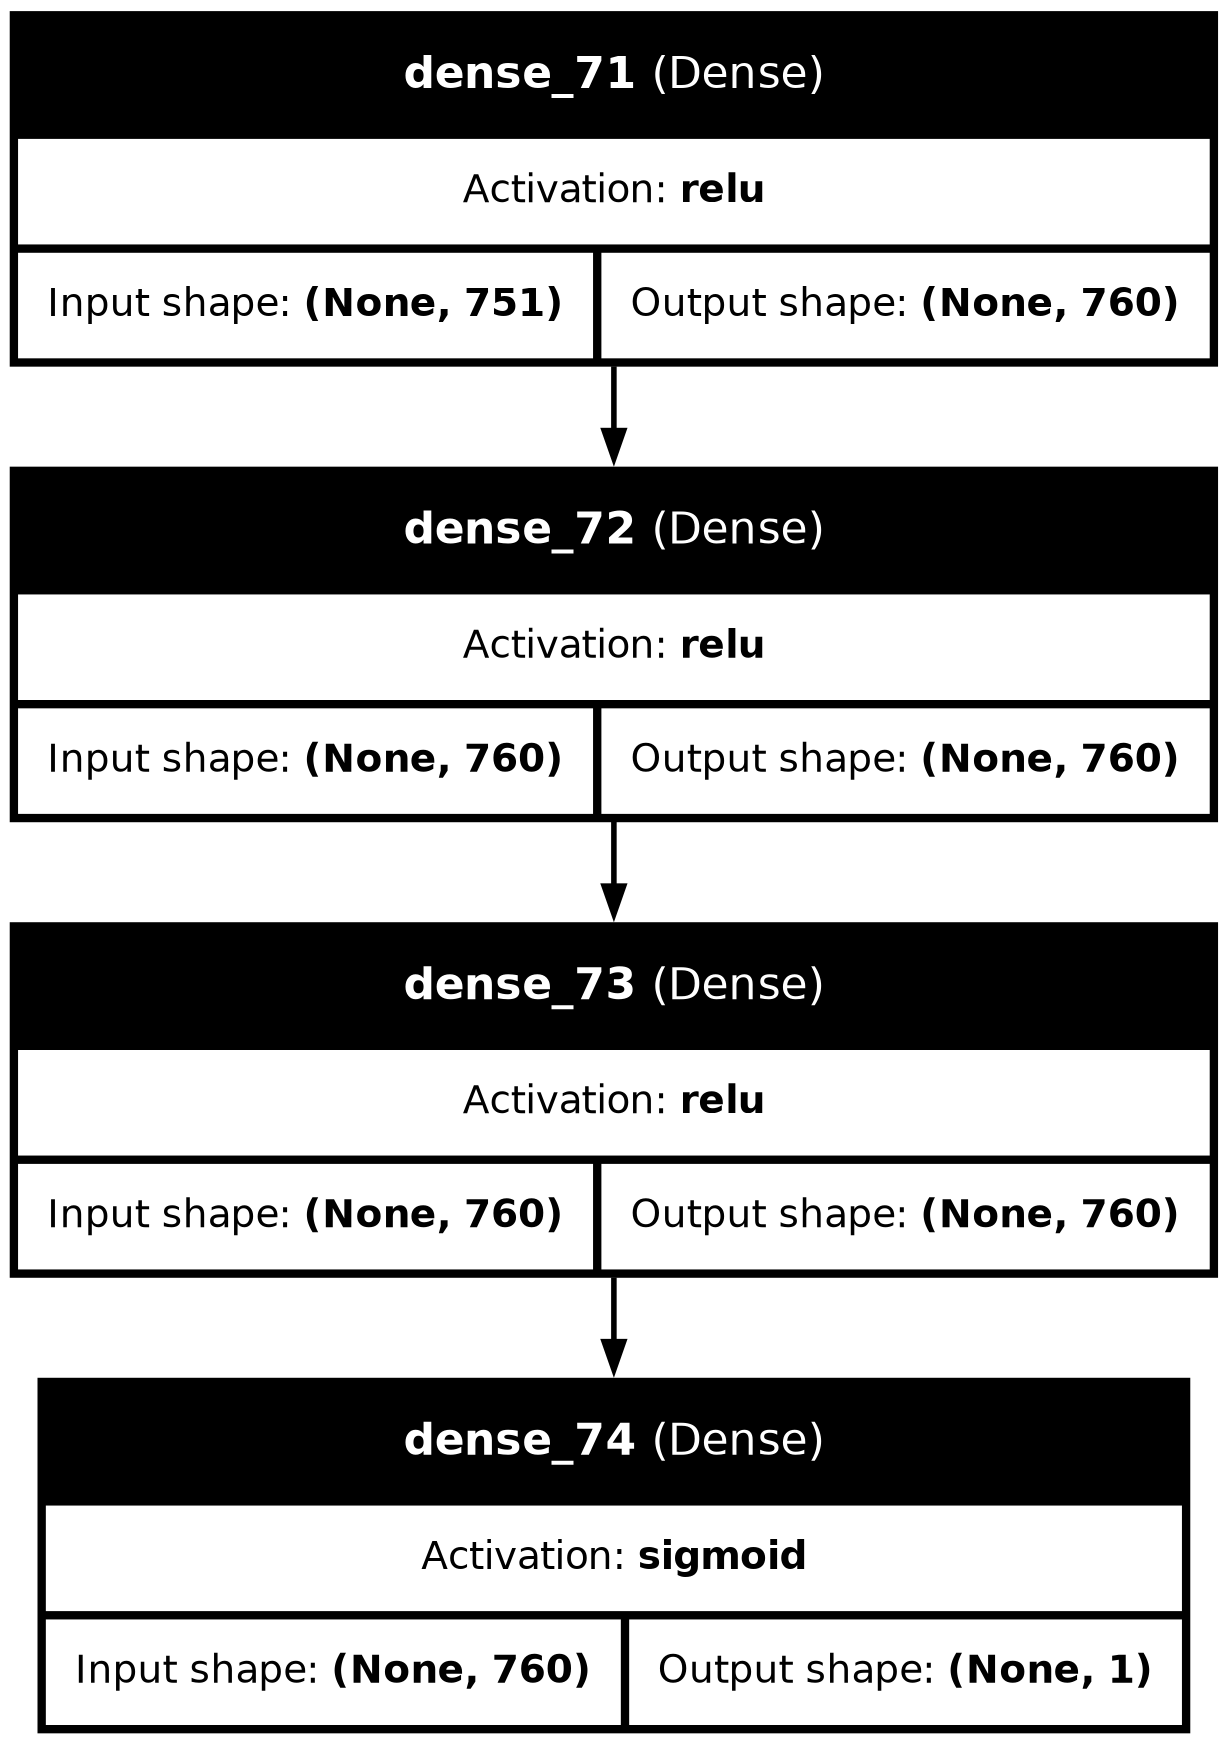

'saved model'

'0.293086 brier_score for year 2022'

Pred_Prob  True_Outcome
0     4.95e-01             1
1     2.46e-12             0
2     4.95e-01             1
3     4.95e-01             0
4     4.95e-01             1
..         ...           ...
129   4.95e-01             1
130   1.00e+00             1
131   4.95e-01             1
132   9.08e-38             0
133   2.87e-03             0

[134 rows x 2 columns]

'0.394866 brier_score for year 2023'

Pred_Prob  True_Outcome
0     6.41e-01             0
1     1.00e+00             0
2     1.56e-06             1
3     1.18e-16             1
4     1.00e+00             1
..         ...           ...
129   2.25e-04             0
130   0.00e+00             0
131   1.00e+00             1
132   4.95e-01             1
133   4.95e-01             0

[134 rows x 2 columns]

'done looping'

In [126]:
# captured_output.show()

### Plot history

loss  val_loss
0  0.26      0.25
1  0.24      0.25

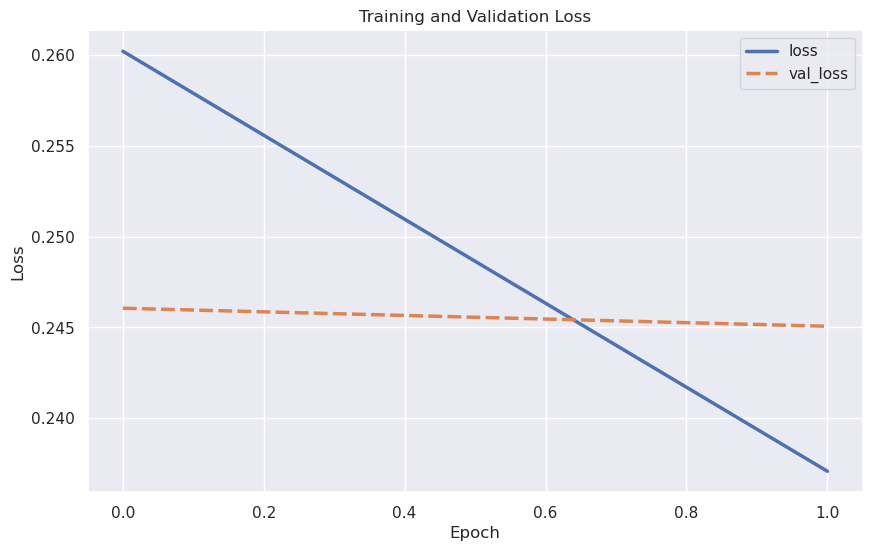

In [41]:
history_df = pd.DataFrame(fit_history_mw.history)
dispi(history_df)
plt.figure(figsize=(10, 6))
sns.lineplot(data=history_df[['loss', 'val_loss']], linewidth=2.5)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

'Evaluating in loop ...'

'0.245065 brier_score for year 2022'

'0.267237 brier_score for year 2023'

### Evaluate in loop

### Conclusion | Notes


**Approach next** | Some questions?  
 | using other functions than relu?  
 | Training & predicting men & women seperately?  
 | How does unscaled data looks?  
 | Not supposed to use 2024 data. What metric compares with score? mse is far off!!  
  
**Approach 14** | **Briar score**  
  


### History

In [ ]:
dispd(fit_history_mw)
# dispd(fit_history_mw.history['prcnt_miss_preds_strnt'])
hist_df = pd.DataFrame(fit_history_mw.history['prcnt_miss_preds_strnt'])
dispd(hist_df.min())
dispd_df(hist_df)

# Submission

## Predict 4 all possible matches combinations

In [115]:
col_teams = 'TeamID'


def predict_4_all_psbl_comb(
    tm_cnfr: pd.DataFrame,
    ann,
    cols: List[str],
    pred_year: int,
    sclr_day_num: StandardScaler,
    ohe: OneHotEncoder,
):
    tm_cur_yr = tm_cnfr.query(f'{col_season} == {pred_year}').reset_index(drop=True)

    # Generate all combinations of two elements from the column
    teams_cmbnts = list(itertools.combinations(tm_cur_yr[col_teams], 2))
    teams_cmbnts_df = pd.DataFrame(teams_cmbnts, columns=cols_teams)

    X = new_df(len(teams_cmbnts_df), cols)
    X[col_wteam], X[col_lteam] = teams_cmbnts_df[col_wteam], teams_cmbnts_df[col_lteam]
    X[col_day_num] = day_ncaa_start
    X = scale_num_clmns(X, sclr_day_num, [col_day_num])
    X = ohe_transform(X, ohe, cols_teams)

    dispd(pd.DataFrame([X_test_se_mw.columns, X.columns, X_train_se_mw]))
    y_pred_st_prob = predict_stnt_ann(ann, X)
    return y_pred_st_prob, teams_cmbnts_df


# ann = load_model(model_best_mis_pred)
dispi(f'Loading model {file_best_loss}')
ann = load_model(file_best_loss)
y_pred_st_prob_m, teams_cmbnts_df_m = predict_4_all_psbl_comb(
    mtm_cnfr, ann, X_test_m.columns, pred_year, sclr_day_num_mw, ohe_mw
)
y_pred_st_prob_w, teams_cmbnts_df_w = predict_4_all_psbl_comb(
    wtm_cnfr, ann, X_test_w.columns, pred_year, sclr_day_num_mw, ohe_mw
)

'Loading model models/ap999_2023_best_loss.keras'

0       1       2      3     4     5      6      7     8     9    10   \
0  DayNum  WScore  LScore  NumOT  WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR   
1  DayNum  WScore  LScore  NumOT  WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR   
2  DayNum  WScore  LScore  NumOT  WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR   

   11    12   13    14    15   16    17    18     19     20    21    22   23   \
0  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR   
1  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR   
2  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR   

   24    25   26    27    28   29    30    31    32    33    34    35    36   \
0  LDR  LAst  LTO  LStl  LBlk  LPF  1101  1102  1103  1104  1105  1106  1107   
1  LDR  LAst  LTO  LStl  LBlk  LPF  1101  1102  1103  1104  1105  1106  1107   
2  LDR  LAst  LTO  LStl  LBlk  LPF  1101  1102  1103  1104  1105  1106  1107   

    37    38    39    40    41    42    43    44    45    46    47    48   \
0  1108  1110  1111  1112  1113  1114  1115  1116  1117  1119  1120  1122   
1  1108  1110  1111  1112  1113  1114  1115  1116  1117  1119  1120  1122   
2  1108  1110  1111  1112  1113  1114  1115  1116  1117  1119  1120  1122   

    49    50    51    52    53    54    55    56    57    58    59    60   \
0  1123  1124  1125  1126  1127  1128  1129  1130  1131  1132  1133  1135   
1  1123  1124  1125  1126  1127  1128  1129  1130  1131  1132  1133  1135   
2  1123  1124  1125  1126  1127  1128  1129  1130  1131  1132  1133  1135   

    61    62    63    64    65    66    67    68    69    70    71    72   \
0  1136  1137  1138  1139  1140  1141  1142  1143  1144  1145  1146  1147   
1  1136  1137  1138  1139  1140  1141  1142  1143  1144  1145  1146  1147   
2  1136  1137  1138  1139  1140  1141  1142  1143  1144  1145  1146  1147   

    73    74    75    76    77    78    79    80    81    82    83    84   \
0  1148  1149  1150  1151  1152  1153  1154  1155  1156  1157  1158  1159   
1  1148  1149  1150  1151  1152  1153  1154  1155  1156  1157  1158  1159   
2  1148  1149  1150  1151  1152  1153  1154  1155  1156  1157  1158  1159   

    85    86    87    88    89    90    91    92    93    94    95    96   \
0  1160  1161  1162  1163  1164  1165  1166  1167  1168  1169  1170  1171   
1  1160  1161  1162  1163  1164  1165  1166  1167  1168  1169  1170  1171   
2  1160  1161  1162  1163  1164  1165  1166  1167  1168  1169  1170  1171   

    97    98    99    100   101   102   103   104   105   106   107   108  \
0  1172  1173  1174  1175  1176  1177  1178  1179  1180  1181  1182  1183   
1  1172  1173  1174  1175  1176  1177  1178  1179  1180  1181  1182  1183   
2  1172  1173  1174  1175  1176  1177  1178  1179  1180  1181  1182  1183   

    109   110   111   112   113   114   115   116   117   118   119   120  \
0  1184  1185  1186  1187  1188  1189  1190  1191  1192  1193  1194  1195   
1  1184  1185  1186  1187  1188  1189  1190  1191  1192  1193  1194  1195   
2  1184  1185  1186  1187  1188  1189  1190  1191  1192  1193  1194  1195   

    121   122   123   124   125   126   127   128   129   130   131   132  \
0  1196  1197  1198  1199  1200  1201  1202  1203  1204  1205  1206  1207   
1  1196  1197  1198  1199  1200  1201  1202  1203  1204  1205  1206  1207   
2  1196  1197  1198  1199  1200  1201  1202  1203  1204  1205  1206  1207   

    133   134   135   136   137   138   139   140   141   142   143   144  \
0  1208  1209  1210  1211  1212  1213  1214  1216  1217  1218  1219  1220   
1  1208  1209  1210  1211  1212  1213  1214  1216  1217  1218  1219  1220   
2  1208  1209  1210  1211  1212  1213  1214  1216  1217  1218  1219  1220   

    145   146   147   148   149   150   151   152   153   154   155   156  \
0  1221  1222  1223  1224  1225  1226  1227  1228  1229  1230  1231  1232   
1  1221  1222  1223  1224  1225  1226  1227  1228  1229  1230  1231  1232   
2  1221  1222  1223  1224  1225

'predict_stnt_ann'

['X_test_se']

DayNum  WScore  LScore  NumOT  WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  \
0       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
1       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
2       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
3       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
4       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
...       ...     ...     ...    ...   ...   ...    ...    ...   ...   ...   
65698   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
65699   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
65700   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
65701   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
65702   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   

       WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  \
0      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
1      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
2      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
3      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
4      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
...    ...  ...   ...  ...   ...   ...  ...   ...   ...    ...    ...   ...   
65698  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
65699  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
65700  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
65701  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
65702  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   

       LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  1101  1102  1103  1104  \
0       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     1     1     0     0   
1       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     1     0     1     0   
2       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     1     0     0     1   
3       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     1     0     0     0   
4       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     1     0     0     0   
...     ...  ...  ...   ...  ...   ...   ...  ...   ...   ...   ...   ...   
65698   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
65699   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
65700   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
65701   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
65702   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   

       1105  1106  1107  1108  1110  1111  1112  1113  1114  1115  1116  1117  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2         0     0     0     0     0     0     0     0     0     0     0     0   
3         1     0     0     0     0     0     0     0     0     0     0     0   
4         0     1     0     0     0     0     0     0     0     0     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
65698     0     0     0     0     0     0     0     0     0     0     0     0   
65699     0     0     0     0     0     0     0     0     0     0     0     0   
65700     0     0     0     0     0     0     0     0     0     0     0     0   
65701     0     0     0     0     0     0     0     0     0     0     0     0   
65702     0     0     0     0     0     0     0     0     0     0     0     0   

       1119  1120  1122  1123  1124  1125  1126  1127  1128  1129  1130  1131  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0  

2054/2054 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step


0       1       2      3     4     5      6      7     8     9    10   \
0  DayNum  WScore  LScore  NumOT  WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR   
1  DayNum  WScore  LScore  NumOT  WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR   
2  DayNum  WScore  LScore  NumOT  WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR   

   11    12   13    14    15   16    17    18     19     20    21    22   23   \
0  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR   
1  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR   
2  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR   

   24    25   26    27    28   29    30    31    32    33    34    35    36   \
0  LDR  LAst  LTO  LStl  LBlk  LPF  1101  1102  1103  1104  1105  1106  1107   
1  LDR  LAst  LTO  LStl  LBlk  LPF  1101  1102  1103  1104  1105  1106  1107   
2  LDR  LAst  LTO  LStl  LBlk  LPF  1101  1102  1103  1104  1105  1106  1107   

    37    38    39    40    41    42    43    44    45    46    47    48   \
0  1108  1110  1111  1112  1113  1114  1115  1116  1117  1119  1120  1122   
1  1108  1110  1111  1112  1113  1114  1115  1116  1117  1119  1120  1122   
2  1108  1110  1111  1112  1113  1114  1115  1116  1117  1119  1120  1122   

    49    50    51    52    53    54    55    56    57    58    59    60   \
0  1123  1124  1125  1126  1127  1128  1129  1130  1131  1132  1133  1135   
1  1123  1124  1125  1126  1127  1128  1129  1130  1131  1132  1133  1135   
2  1123  1124  1125  1126  1127  1128  1129  1130  1131  1132  1133  1135   

    61    62    63    64    65    66    67    68    69    70    71    72   \
0  1136  1137  1138  1139  1140  1141  1142  1143  1144  1145  1146  1147   
1  1136  1137  1138  1139  1140  1141  1142  1143  1144  1145  1146  1147   
2  1136  1137  1138  1139  1140  1141  1142  1143  1144  1145  1146  1147   

    73    74    75    76    77    78    79    80    81    82    83    84   \
0  1148  1149  1150  1151  1152  1153  1154  1155  1156  1157  1158  1159   
1  1148  1149  1150  1151  1152  1153  1154  1155  1156  1157  1158  1159   
2  1148  1149  1150  1151  1152  1153  1154  1155  1156  1157  1158  1159   

    85    86    87    88    89    90    91    92    93    94    95    96   \
0  1160  1161  1162  1163  1164  1165  1166  1167  1168  1169  1170  1171   
1  1160  1161  1162  1163  1164  1165  1166  1167  1168  1169  1170  1171   
2  1160  1161  1162  1163  1164  1165  1166  1167  1168  1169  1170  1171   

    97    98    99    100   101   102   103   104   105   106   107   108  \
0  1172  1173  1174  1175  1176  1177  1178  1179  1180  1181  1182  1183   
1  1172  1173  1174  1175  1176  1177  1178  1179  1180  1181  1182  1183   
2  1172  1173  1174  1175  1176  1177  1178  1179  1180  1181  1182  1183   

    109   110   111   112   113   114   115   116   117   118   119   120  \
0  1184  1185  1186  1187  1188  1189  1190  1191  1192  1193  1194  1195   
1  1184  1185  1186  1187  1188  1189  1190  1191  1192  1193  1194  1195   
2  1184  1185  1186  1187  1188  1189  1190  1191  1192  1193  1194  1195   

    121   122   123   124   125   126   127   128   129   130   131   132  \
0  1196  1197  1198  1199  1200  1201  1202  1203  1204  1205  1206  1207   
1  1196  1197  1198  1199  1200  1201  1202  1203  1204  1205  1206  1207   
2  1196  1197  1198  1199  1200  1201  1202  1203  1204  1205  1206  1207   

    133   134   135   136   137   138   139   140   141   142   143   144  \
0  1208  1209  1210  1211  1212  1213  1214  1216  1217  1218  1219  1220   
1  1208  1209  1210  1211  1212  1213  1214  1216  1217  1218  1219  1220   
2  1208  1209  1210  1211  1212  1213  1214  1216  1217  1218  1219  1220   

    145   146   147   148   149   150   151   152   153   154   155   156  \
0  1221  1222  1223  1224  1225  1226  1227  1228  1229  1230  1231  1232   
1  1221  1222  1223  1224  1225  1226  1227  1228  1229  1230  1231  1232   
2  1221  1222  1223  1224  1225

'predict_stnt_ann'

['X_test_se']

DayNum  WScore  LScore  NumOT  WFGM  WFGA  WFGM3  WFGA3  WFTM  WFTA  \
0       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
1       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
2       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
3       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
4       -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
...       ...     ...     ...    ...   ...   ...    ...    ...   ...   ...   
64975   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
64976   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
64977   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
64978   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
64979   -1.52     0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   

       WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  LFGM3  LFGA3  LFTM  \
0      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
1      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
2      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
3      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
4      0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
...    ...  ...   ...  ...   ...   ...  ...   ...   ...    ...    ...   ...   
64975  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
64976  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
64977  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
64978  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   
64979  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0   0.0    0.0    0.0   0.0   

       LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  1101  1102  1103  1104  \
0       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
1       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
2       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
3       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
4       0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
...     ...  ...  ...   ...  ...   ...   ...  ...   ...   ...   ...   ...   
64975   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
64976   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
64977   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
64978   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   
64979   0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0     0     0     0     0   

       1105  1106  1107  1108  1110  1111  1112  1113  1114  1115  1116  1117  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2         0     0     0     0     0     0     0     0     0     0     0     0   
3         0     0     0     0     0     0     0     0     0     0     0     0   
4         0     0     0     0     0     0     0     0     0     0     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
64975     0     0     0     0     0     0     0     0     0     0     0     0   
64976     0     0     0     0     0     0     0     0     0     0     0     0   
64977     0     0     0     0     0     0     0     0     0     0     0     0   
64978     0     0     0     0     0     0     0     0     0     0     0     0   
64979     0     0     0     0     0     0     0     0     0     0     0     0   

       1119  1120  1122  1123  1124  1125  1126  1127  1128  1129  1130  1131  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0  

2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step


## Create submission file

In [66]:
def create_sbmtn_cols_id_pred(teams_cmbnts: pd.DataFrame, y_pred_st_prob: pd.DataFrame):
    teams_cmbnts[col_id] = f'{pred_year}_' + (
        teams_cmbnts[col_wteam].astype(str) + '_' + teams_cmbnts[col_lteam].astype(str)
    )
    teams_cmbnts[col_pred] = y_pred_st_prob[col_pred_prb]
    return teams_cmbnts


teams_cmbnts_df_m = create_sbmtn_cols_id_pred(teams_cmbnts_df_m, y_pred_st_prob_m)
teams_cmbnts_df_w = create_sbmtn_cols_id_pred(teams_cmbnts_df_w, y_pred_st_prob_w)
teams_cmbnts_df_mw = pd.concat(
    [teams_cmbnts_df_m, teams_cmbnts_df_w], axis=0, ignore_index=True
)

file_subm = f'pred/ap{aprch}_{pred_year}_best_loss.csv'
teams_cmbnts_df_mw[[col_id, col_pred]].to_csv(
    f'pred/ap{aprch}_{pred_year}_best_loss.csv', index=False
)
# teams_cmbnts_df[[col_id, col_pred]].to_csv(f'pred/ap10_{pred_year}_best_miss_pred.csv', index=False)

NameError: name 'teams_cmbnts_df_m' is not defined

## Submit to Kaggle

In [65]:
!kaggle competitions submit march-machine-learning-mania-2023 -f {file_subm} -m ""

Traceback (most recent call last):
  File "/home/dattakru/miniforge3/bin/kaggle", line 10, in <module>
    sys.exit(main())
  File "/home/dattakru/miniforge3/lib/python3.10/site-packages/kaggle/cli.py", line 63, in main
    out = args.func(**command_args)
  File "/home/dattakru/miniforge3/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 817, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/home/dattakru/miniforge3/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 768, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/home/dattakru/miniforge3/lib/python3.10/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: '{file_subm}'


# Tmp

In [135]:
# pd.options.display.float_format = '{:.4f}'.format
display(pd.options.display.float_format)

None